## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()


## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

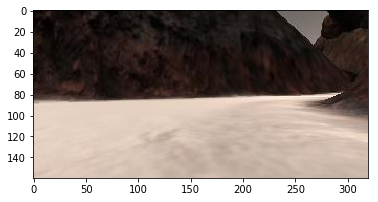

In [3]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

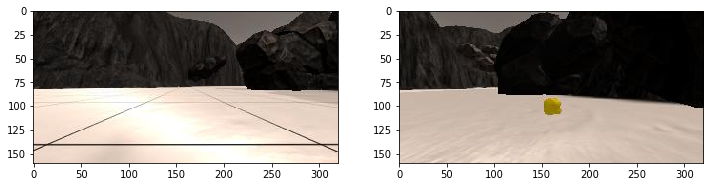

In [4]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

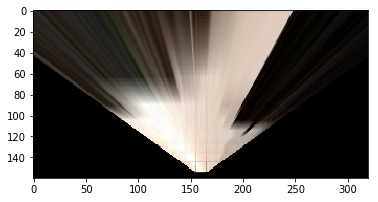

In [5]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped

# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Hints and Suggestion:** 
* For obstacles you can just invert your color selection that you used to detect ground pixels, i.e., if you've decided that everything above the threshold is navigable terrain, then everthing below the threshold must be an obstacle!


* For rocks, think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  You can investigate the colors of the rocks (the RGB pixel values) in an interactive matplotlib window to get a feel for the appropriate threshold range (keep in mind you may want different ranges for each of R, G and B!).  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  

* **Beware However:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

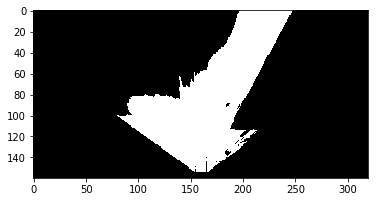

In [6]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

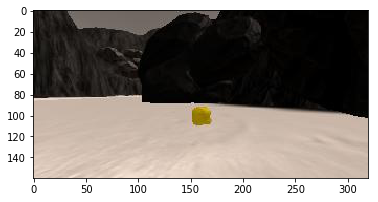

In [7]:
plt.imshow(rock_img)

In [8]:
def rock_thresh(img):
    obs = color_thresh(img)
    lower = np.array([110,90,0])
    upper = np.array([250,240,80])
    mask = cv2.inRange(img,lower,upper)
    return mask

def obstacle_thresh(img,rgb_thresh=(160,160,160)):
    color_select = np.zeros_like(img[:,:,0])
    thresh = (img[:,:,0] <= rgb_thresh[0]) & (img[:,:,1] <= rgb_thresh[1]) & (img[:,:,2] <= rgb_thresh[2])
    color_select[thresh] = 1
    return color_select

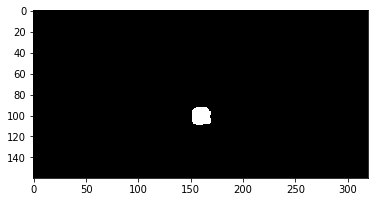

In [9]:
rock_thresh_img = rock_thresh(rock_img)
plt.imshow(rock_thresh_img, cmap = 'gray')

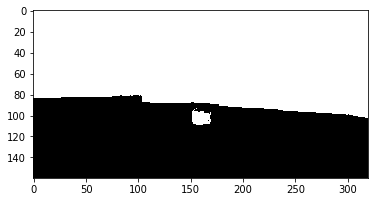

In [10]:
obstacle_thresh_img = obstacle_thresh(rock_img)
plt.imshow(obstacle_thresh_img,cmap = 'gray')

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

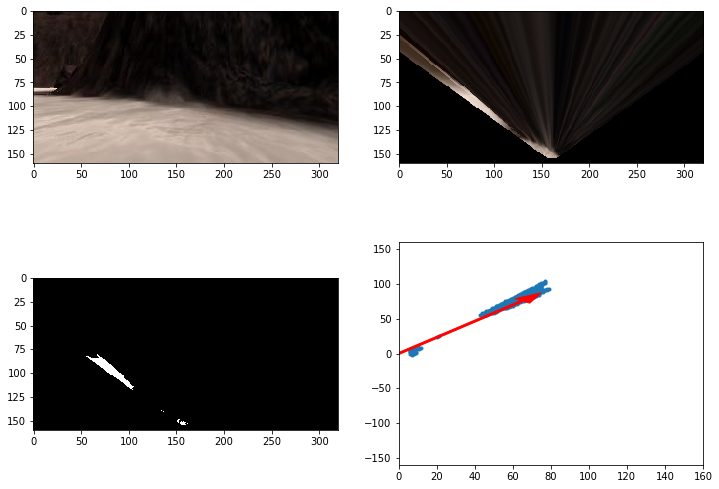

In [11]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [12]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()

## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

source and destination done
perspective warped
(160, 320)
(160, 320)
(160, 320)
threshed
mean_dir0 is : -0.006527124473206302
mean_dir1 is : 119.46153846153847
mean_dir2 is : 0.8613005110513503
worldmap size is : (200, 200, 3)
121.7033    51.82202    197.8148   
xpi0-2, ypix0-2 , conver to world coordinate


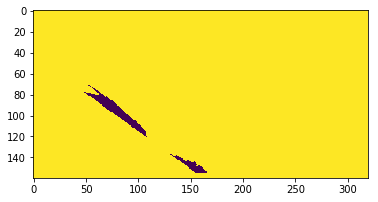

In [13]:
dst_size = 5 
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
print('source and destination done')

# 2) Apply perspective transform
warped = perspect_transform(image, source, destination)
print('perspective warped')

# 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
threshed_navigable = color_thresh(warped)
print(threshed_navigable.shape)
threshed_obstacle = obstacle_thresh(warped)
print(threshed_obstacle.shape)
plt.imshow(threshed_obstacle)
threshed_rock = rock_thresh(warped)
print(threshed_rock.shape)
print('threshed')

# fig = plt.figure(figsize=(12,9))
# plt.subplot(231)
# plt.imshow(image)
# plt.subplot(232)
# plt.imshow(threshed_obstacle)
# plt.subplot(233)
# plt.imshow(threshed_rock, cmap='gray')
# plt.subplot(234)
# plt.plot(xpix, ypix, '.')
# plt.subplot(235)
# plt.imshow(threshed_navigable)
# plt.ylim(-160, 160)
# plt.xlim(0, 160)

# 5) Convert map image pixel values to rover-centric coords
xpix0, ypix0 = rover_coords(threshed_obstacle)
dist0,angles0 = to_polar_coords(xpix0, ypix0)
mean_dir0 = np.mean(angles0)

xpix1, ypix1 = rover_coords(threshed_rock)
dist1, angles1 = rover_coords(threshed_rock)
mean_dir1 = np.mean(angles1)

xpix2, ypix2 = rover_coords(threshed_navigable)
dist2, angles2 = to_polar_coords(xpix2, ypix2)
mean_dir2 = np.mean(angles2)

print('mean_dir0 is : ' + str(mean_dir0))
print('mean_dir1 is : ' + str(mean_dir1))
print('mean_dir2 is : ' + str(mean_dir2))

# 6) Convert rover-centric pixel values to world coordinates

scale= 10
xpos, ypos = data.xpos[data.count],data.ypos[data.count]
yaw = data.yaw[data.count]
worldmap = data.worldmap
print('worldmap size is : ' + str(worldmap.shape))
print(xpos, '  ',ypos, '  ',yaw, '  ')
x_pix0_world, y_pix0_world = pix_to_world(xpix0, ypix0, xpos, ypos, yaw, worldmap.shape[0],scale)
x_pix1_world, y_pix1_world = pix_to_world(xpix1, ypix1, xpos, ypos, yaw, worldmap.shape[0], scale)
x_pix2_world, y_pix2_world = pix_to_world(xpix2, ypix2, xpos, ypos, yaw, worldmap.shape[0], scale)

print('xpi0-2, ypix0-2 , conver to world coordinate')

# 7) Update Rover worldmap (to be displayed on right side of screen)
    # Example: Rover.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
    #          Rover.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    #          Rover.worldmap[rock_y_world, rock_x_world, 1] += 1
data.worldmap[y_pix0_world, x_pix0_world, 0] += 1
data.worldmap[y_pix1_world, x_pix1_world, 1] += 1
data.worldmap[y_pix2_world, x_pix2_world, 2] += 1

In [14]:
def process_image(img):
    image = img
    dst_size = 5 
    bottom_offset = 6
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                      [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                      [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                      [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                      ])
    print('source and destination done')
    
    # 2) Apply perspective transform
    warped = perspect_transform(image, source, destination)
    print('perspective warped')
    
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    threshed_obstacle = obstacle_thresh(warped)
    threshed_rock = rock_thresh(warped)
    threshed_navigable = color_thresh(warped)

    # 4) Update Rover.vision_image (this will be displayed on left side of screen)
        # Example: Rover.vision_image[:,:,0] = obstacle color-thresholded binary image
        #          Rover.vision_image[:,:,1] = rock_sample color-thresholded binary image
        #          Rover.vision_image[:,:,2] = navigable terrain color-thresholded binary image
        #          Rover.vision_image[:,:,2] = warped - threshed
    #data.worldmap[:,:,0] = threshed_obstacle * 255
    #data.worldmap[:,:,1] = threshed_rock * 255
    #data.worldmap[:,:,2] = threshed_navigable * 255
    
    # 5) Convert map image pixel values to rover-centric coords
    xpix0, ypix0 = rover_coords(threshed_obstacle)
    dist0,angles0 = to_polar_coords(xpix0, ypix0)
    mean_dir0 = np.mean(angles0)

    xpix1, ypix1 = rover_coords(threshed_rock)
    dist1, angles1 = rover_coords(threshed_rock)
    mean_dir1 = np.mean(angles1)

    xpix2, ypix2 = rover_coords(threshed_navigable)
    dist2, angles2 = to_polar_coords(xpix2, ypix2)
    mean_dir2 = np.mean(angles2)

    print('mean_dir0 is : ' + str(mean_dir0))
    print('mean_dir1 is : ' + str(mean_dir1))
    print('mean_dir2 is : ' + str(mean_dir2))
    
    # 6) Convert rover-centric pixel values to world coordinates
    scale= 10
    xpos, ypos = data.xpos[data.count],data.ypos[data.count]
    yaw = data.yaw[data.count]
    worldmap = data.worldmap
    print('worldmap size is : ' + str(worldmap.shape))
    print(xpos, '  ',ypos, '  ',yaw, '  ')
    x_pix0_world, y_pix0_world = pix_to_world(xpix0, ypix0, xpos, ypos, yaw, worldmap.shape[0],scale)
    x_pix1_world, y_pix1_world = pix_to_world(xpix1, ypix1, xpos, ypos, yaw, worldmap.shape[0], scale)
    x_pix2_world, y_pix2_world = pix_to_world(xpix2, ypix2, xpos, ypos, yaw, worldmap.shape[0], scale)

    print('xpi0-2, ypix0-2 , conver to world coordinate')
    
    # 7) Update Rover worldmap (to be displayed on right side of screen)
        # Example: Rover.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          Rover.worldmap[navigable_y_world, navigable_x_world, 2] += 1
        #          Rover.worldmap[rock_y_world, rock_x_world, 1] += 1
    data.worldmap[y_pix0_world, x_pix0_world, 0] += 1
    data.worldmap[y_pix1_world, x_pix1_world, 1] += 1
    data.worldmap[y_pix2_world, x_pix2_world, 2] += 1
    
        # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

In [15]:
print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

121.7033 51.82202 197.8148


## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip

# Define pathname to save the output video
output = '../output/test_mapping_linming.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=25) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25

In [17]:
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

source and destination done
perspective warped
mean_dir0 is : -0.0011192423579292547
mean_dir1 is : 16.986666666666668
mean_dir2 is : 0.062068681705498494
worldmap size is : (200, 200, 3)
121.7033    51.82202    197.8148   
xpi0-2, ypix0-2 , conver to world coordinate
[MoviePy] >>>> Building video ../output/test_mapping_linming.mp4
[MoviePy] Writing video ../output/test_mapping_linming.mp4


  0%|                                                 | 0/1347 [00:00<?, ?it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0011192423579292547
mean_dir1 is : 16.986666666666668
mean_dir2 is : 0.062068681705498494
worldmap size is : (200, 200, 3)
121.7033    51.82202    197.8148   
xpi0-2, ypix0-2 , conver to world coordinate


  0%|                                         | 1/1347 [00:00<02:20,  9.57it/s]

source and destination done
perspective warped
mean_dir0 is : -0.001132796859845635
mean_dir1 is : 17.278688524590162
mean_dir2 is : 0.06286394359370479
worldmap size is : (200, 200, 3)
121.7033    51.82202    195.1149   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0038052000326024476
mean_dir1 is : 28.03076923076923
mean_dir2 is : 0.10658487046520175
worldmap size is : (200, 200, 3)
121.7033    51.82202    192.2617   
xpi0-2, ypix0-2 , conver to world coordinate


  0%|                                         | 3/1347 [00:00<01:43, 13.01it/s]

source and destination done
perspective warped
mean_dir0 is : -0.006464638110909502
mean_dir1 is : 24.20408163265306
mean_dir2 is : 0.1795034970978963
worldmap size is : (200, 200, 3)
121.7033    51.82202    189.7032   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.009460775636209767
mean_dir1 is : 46.833333333333336
mean_dir2 is : 0.2320887663962973
worldmap size is : (200, 200, 3)
121.7033    51.82202    187.0031   
xpi0-2, ypix0-2 , conver to world coordinate


  0%|▏                                        | 5/1347 [00:00<01:46, 12.58it/s]

source and destination done
perspective warped
mean_dir0 is : -0.012472128752809406
mean_dir1 is : 37.92307692307692
mean_dir2 is : 0.29794558077227207
worldmap size is : (200, 200, 3)
121.7033    51.82202    183.4031   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.01668973464061497
mean_dir1 is : 55.6875
mean_dir2 is : 0.3828664169334398
worldmap size is : (200, 200, 3)
121.7033    51.82202    180.7032   
xpi0-2, ypix0-2 , conver to world coordinate


  1%|▏                                        | 7/1347 [00:00<01:35, 13.98it/s]

source and destination done
perspective warped
mean_dir0 is : -0.02079523802201518
mean_dir1 is : 70.09782608695652
mean_dir2 is : 0.4343793740587014
worldmap size is : (200, 200, 3)
121.7033    51.82202    178.1197   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.023730025268269322
mean_dir1 is : 70.21951219512195
mean_dir2 is : 0.4735881645749687
worldmap size is : (200, 200, 3)
121.7033    51.82202    176.2529   
xpi0-2, ypix0-2 , conver to world coordinate


  1%|▎                                        | 9/1347 [00:00<01:37, 13.70it/s]

source and destination done
perspective warped
mean_dir0 is : -0.02549342051797251
mean_dir1 is : 80.34146341463415
mean_dir2 is : 0.4751671607624406
worldmap size is : (200, 200, 3)
121.7033    51.82202    174.7775   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.026427468226684514
mean_dir1 is : 97.47368421052632
mean_dir2 is : 0.4772923700544185
worldmap size is : (200, 200, 3)
121.7033    51.82202    174.3542   
xpi0-2, ypix0-2 , conver to world coordinate


  1%|▎                                       | 11/1347 [00:00<01:36, 13.79it/s]

source and destination done
perspective warped
mean_dir0 is : -0.026841064084054903
mean_dir1 is : 89.45
mean_dir2 is : 0.4720147022695242
worldmap size is : (200, 200, 3)
121.7033    51.82202    174.8327   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.02657667240187712
mean_dir1 is : 90.14285714285714
mean_dir2 is : 0.4724498418370147
worldmap size is : (200, 200, 3)
121.7033    51.82202    175.4839   
xpi0-2, ypix0-2 , conver to world coordinate


  1%|▍                                       | 13/1347 [00:00<01:33, 14.22it/s]

source and destination done
perspective warped
mean_dir0 is : -0.025921142762652356
mean_dir1 is : 81.77551020408163
mean_dir2 is : 0.4787462096940773
worldmap size is : (200, 200, 3)
121.7033    51.82202    175.7748   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.02607870644449464
mean_dir1 is : 82.70786516853933
mean_dir2 is : 0.4765320316402792
worldmap size is : (200, 200, 3)
121.7033    51.82202    177.2035   
xpi0-2, ypix0-2 , conver to world coordinate


  1%|▍                                       | 15/1347 [00:01<01:30, 14.68it/s]

source and destination done
perspective warped
mean_dir0 is : -0.024885804288493876
mean_dir1 is : 70.8
mean_dir2 is : 0.4732279912781496
worldmap size is : (200, 200, 3)
121.7033    51.82202    179.0571   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.02267682309583579
mean_dir1 is : 64.8529411764706
mean_dir2 is : 0.4656702716791056
worldmap size is : (200, 200, 3)
121.7033    51.82202    181.5109   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.019480930960991575
mean_dir1 is : 69.01369863013699
mean_dir2 is : 0.41622734723955557
worldmap size is : (200, 200, 3)
121.7033    51.82202    185.111   
xpi0-2, ypix0-2 , conver to world coordinate


  1%|▌                                       | 18/1347 [00:01<01:24, 15.66it/s]

source and destination done
perspective warped
mean_dir0 is : -0.014952429261330875
mean_dir1 is : 52.89565217391304
mean_dir2 is : 0.344383593145547
worldmap size is : (200, 200, 3)
121.7031    51.82184    185.1243   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.014894333096023983
mean_dir1 is : 53.44915254237288
mean_dir2 is : 0.3420165100187237
worldmap size is : (200, 200, 3)
121.7011    51.821509999999996    185.2863   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.014977599267817046
mean_dir1 is : 55.00909090909091
mean_dir2 is : 0.3283617097536254
worldmap size is : (200, 200, 3)
121.6976    51.82092    185.3452   
xpi0-2, ypix0-2 , conver to world coordinate


  2%|▌                                       | 21/1347 [00:01<01:20, 16.49it/s]

source and destination done
perspective warped
mean_dir0 is : -0.016189831185427193
mean_dir1 is : 52.14705882352941
mean_dir2 is : 0.3172117818287211
worldmap size is : (200, 200, 3)
121.6883    51.818909999999995    185.6892   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.008467531744752253
mean_dir1 is : 36.439655172413794
mean_dir2 is : 0.250366353677599
worldmap size is : (200, 200, 3)
121.6772    51.8166    185.9457   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.023259885487561208
mean_dir1 is : 13.0
mean_dir2 is : 0.27925309748332133
worldmap size is : (200, 200, 3)
121.6633    51.81365    186.2549   
xpi0-2, ypix0-2 , conver to world coordinate


  2%|▋                                       | 24/1347 [00:01<01:16, 17.25it/s]

source and destination done
perspective warped
mean_dir0 is : -0.027060064362922027
mean_dir1 is : nan
mean_dir2 is : 0.37354966850105537
worldmap size is : (200, 200, 3)
121.6402    51.80885    186.7972   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.04994584274696859
mean_dir1 is : nan
mean_dir2 is : 0.2809106677576194
worldmap size is : (200, 200, 3)
121.6187    51.80375    187.1516   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.04243617438239148
mean_dir1 is : nan
mean_dir2 is : 0.19070596023653505
worldmap size is : (200, 200, 3)
121.5923    51.79654    187.74200000000002   
xpi0-2, ypix0-2 , conver to world coordinate


  2%|▊                                       | 27/1347 [00:01<01:14, 17.82it/s]

source and destination done
perspective warped
mean_dir0 is : -0.04128772979276121
mean_dir1 is : -10.8125
mean_dir2 is : 0.22626513854645341
worldmap size is : (200, 200, 3)
121.5698    51.79072    188.2158   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.04242950318325599
mean_dir1 is : -11.666666666666666
mean_dir2 is : 0.22464854614809177
worldmap size is : (200, 200, 3)
121.5431    51.78363    188.5643   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.04228326907615511
mean_dir1 is : -12.555555555555555
mean_dir2 is : 0.2243499428726894
worldmap size is : (200, 200, 3)
121.5015    51.77237    189.0742   
xpi0-2, ypix0-2 , conver to world coordinate


  2%|▉                                       | 30/1347 [00:01<01:12, 18.23it/s]

source and destination done
perspective warped
mean_dir0 is : -0.039455047211076004
mean_dir1 is : -14.333333333333334
mean_dir2 is : 0.2080612683017468
worldmap size is : (200, 200, 3)
121.4671    51.76294    189.6819   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.036343862321495043
mean_dir1 is : -18.25
mean_dir2 is : 0.19849114946483623
worldmap size is : (200, 200, 3)
121.4307    51.75253    190.3396   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.03317095094276669
mean_dir1 is : nan
mean_dir2 is : 0.19001592990403096
worldmap size is : (200, 200, 3)
121.3783    51.73679    191.2836   
xpi0-2, ypix0-2 , conver to world coordinate


  2%|▉                                       | 33/1347 [00:01<01:10, 18.63it/s]

source and destination done
perspective warped
mean_dir0 is : -0.030728289411788994
mean_dir1 is : nan
mean_dir2 is : 0.17600871402222534
worldmap size is : (200, 200, 3)
121.3355    51.724740000000004    191.9038   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.02875830491346907
mean_dir1 is : 44.333333333333336
mean_dir2 is : 0.1644534238893937
worldmap size is : (200, 200, 3)
121.2903    51.71137    192.6253   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.026473460477446153
mean_dir1 is : 44.4
mean_dir2 is : 0.13804610875787307
worldmap size is : (200, 200, 3)
121.226    51.689640000000004    193.8162   
xpi0-2, ypix0-2 , conver to world coordinate


  3%|█                                       | 36/1347 [00:01<01:08, 19.01it/s]

source and destination done
perspective warped
mean_dir0 is : -0.02211390732070426
mean_dir1 is : -26.16
mean_dir2 is : 0.11246129426480446
worldmap size is : (200, 200, 3)
121.1752    51.67136    194.8315   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.018377240439514532
mean_dir1 is : -31.0
mean_dir2 is : 0.09348792111273409
worldmap size is : (200, 200, 3)
121.1218    51.65198    195.7623   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.01517737740627259
mean_dir1 is : nan
mean_dir2 is : 0.07344167319778924
worldmap size is : (200, 200, 3)
121.0453    51.62487    196.5763   
xpi0-2, ypix0-2 , conver to world coordinate


  3%|█▏                                      | 39/1347 [00:02<01:07, 19.41it/s]

source and destination done
perspective warped
mean_dir0 is : -0.011518192178685088
mean_dir1 is : -24.0
mean_dir2 is : 0.059243660608334164
worldmap size is : (200, 200, 3)
120.9842    51.60452    196.8833   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.010227578685956843
mean_dir1 is : nan
mean_dir2 is : 0.05212215257174256
worldmap size is : (200, 200, 3)
120.9207    51.58466    196.9178   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.010245242491864067
mean_dir1 is : nan
mean_dir2 is : 0.0510632540618591
worldmap size is : (200, 200, 3)
120.8314    51.55767    196.8828   
xpi0-2, ypix0-2 , conver to world coordinate


  3%|█▏                                      | 42/1347 [00:02<01:06, 19.71it/s]

source and destination done
perspective warped
mean_dir0 is : -0.010841572529398921
mean_dir1 is : nan
mean_dir2 is : 0.04954131135416449
worldmap size is : (200, 200, 3)
120.76100000000001    51.536609999999996    196.85   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.011791003682273971
mean_dir1 is : nan
mean_dir2 is : 0.0438718123304543
worldmap size is : (200, 200, 3)
120.68799999999999    51.51477    196.8277   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.011924260346228288
mean_dir1 is : nan
mean_dir2 is : 0.041801614505571134
worldmap size is : (200, 200, 3)
120.5863    51.48442    196.7887   
xpi0-2, ypix0-2 , conver to world coordinate


  3%|█▎                                      | 45/1347 [00:02<01:05, 19.87it/s]

source and destination done
perspective warped
mean_dir0 is : -0.012445785772992997
mean_dir1 is : nan
mean_dir2 is : 0.04011056624694783
worldmap size is : (200, 200, 3)
120.5068    51.460770000000004    196.7689   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.012924897440617311
mean_dir1 is : nan
mean_dir2 is : 0.03994330049128174
worldmap size is : (200, 200, 3)
120.4246    51.43636    196.7526   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.013748854433367454
mean_dir1 is : 54.0
mean_dir2 is : 0.04235223043144422
worldmap size is : (200, 200, 3)
120.3109    51.402590000000004    196.7368   
xpi0-2, ypix0-2 , conver to world coordinate


  4%|█▍                                      | 48/1347 [00:02<01:04, 20.14it/s]

source and destination done
perspective warped
mean_dir0 is : -0.014295270672217138
mean_dir1 is : 38.5
mean_dir2 is : 0.038364864596771624
worldmap size is : (200, 200, 3)
120.2223    51.37634    196.7225   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.015674579140422723
mean_dir1 is : -43.464285714285715
mean_dir2 is : 0.029798706104238303
worldmap size is : (200, 200, 3)
120.1311    51.34933    196.7124   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.017061812106930314
mean_dir1 is : -40.26315789473684
mean_dir2 is : 0.020745113879232207
worldmap size is : (200, 200, 3)
120.0054    51.31212    196.6977   
xpi0-2, ypix0-2 , conver to world coordinate


  4%|█▌                                      | 51/1347 [00:02<01:03, 20.34it/s]

source and destination done
perspective warped
mean_dir0 is : -0.018931312637278687
mean_dir1 is : -58.84615384615385
mean_dir2 is : 0.018302461875739705
worldmap size is : (200, 200, 3)
119.90799999999999    51.28331    196.6857   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.019710034081007233
mean_dir1 is : nan
mean_dir2 is : 0.01965258428805347
worldmap size is : (200, 200, 3)
119.8079    51.25377    196.676   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.021179264425401703
mean_dir1 is : nan
mean_dir2 is : 0.015091679573445196
worldmap size is : (200, 200, 3)
119.6703    51.21317    196.6603   
xpi0-2, ypix0-2 , conver to world coordinate


  4%|█▌                                      | 54/1347 [00:02<01:03, 20.46it/s]

source and destination done
perspective warped
mean_dir0 is : -0.022588077238541972
mean_dir1 is : nan
mean_dir2 is : 0.025309656903171406
worldmap size is : (200, 200, 3)
119.5641    51.18184    196.6489   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.024441460817347833
mean_dir1 is : 37.0
mean_dir2 is : 0.03224868195371194
worldmap size is : (200, 200, 3)
119.4553    51.14978    196.6379   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.025062910777589965
mean_dir1 is : -47.0
mean_dir2 is : 0.048971462947675515
worldmap size is : (200, 200, 3)
119.3061    51.10587    196.6245   
xpi0-2, ypix0-2 , conver to world coordinate


  4%|█▋                                      | 57/1347 [00:02<01:02, 20.56it/s]

source and destination done
perspective warped
mean_dir0 is : -0.026937010334362986
mean_dir1 is : -26.894736842105264
mean_dir2 is : 0.051552639972597375
worldmap size is : (200, 200, 3)
119.1912    51.072070000000004    196.6134   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.02925438928156683
mean_dir1 is : 2.7142857142857144
mean_dir2 is : 0.052611851848149205
worldmap size is : (200, 200, 3)
119.0736    51.03752    196.6007   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.030129138065205063
mean_dir1 is : -41.285714285714285
mean_dir2 is : 0.0521570976779531
worldmap size is : (200, 200, 3)
118.913    50.99033    196.58599999999998   
xpi0-2, ypix0-2 , conver to world coordinate


  4%|█▊                                      | 60/1347 [00:02<01:02, 20.68it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0340394149336858
mean_dir1 is : -42.2
mean_dir2 is : 0.05201142842844405
worldmap size is : (200, 200, 3)
118.7895    50.9541    196.575   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.03708088117318052
mean_dir1 is : -32.5
mean_dir2 is : 0.06332338771949496
worldmap size is : (200, 200, 3)
118.6634    50.91735    196.5244   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.04002686167110899
mean_dir1 is : -34.5
mean_dir2 is : 0.04710437272381285
worldmap size is : (200, 200, 3)
118.4907    50.870470000000005    195.8719   
xpi0-2, ypix0-2 , conver to world coordinate


  5%|█▊                                      | 63/1347 [00:03<01:01, 20.79it/s]

source and destination done
perspective warped
mean_dir0 is : -0.05276310341339623
mean_dir1 is : -36.72222222222222
mean_dir2 is : 0.07623780299378283
worldmap size is : (200, 200, 3)
118.3574    50.83878    194.8428   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0762295755235553
mean_dir1 is : -40.666666666666664
mean_dir2 is : 0.10837629746841783
worldmap size is : (200, 200, 3)
118.2213    50.81149    193.3475   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.11486277601159836
mean_dir1 is : -14.6
mean_dir2 is : 0.1687906456951436
worldmap size is : (200, 200, 3)
118.0366    50.77916    191.2854   
xpi0-2, ypix0-2 , conver to world coordinate


  5%|█▉                                      | 66/1347 [00:03<01:01, 20.91it/s]

source and destination done
perspective warped
mean_dir0 is : -0.047919657192797054
mean_dir1 is : 125.1923076923077
mean_dir2 is : 0.12062842591648938
worldmap size is : (200, 200, 3)
117.8945    50.7561    190.1824   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.03750004272141742
mean_dir1 is : 79.11855670103093
mean_dir2 is : 0.18217466278605413
worldmap size is : (200, 200, 3)
117.7491    50.73274    189.5321   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.060370937480400934
mean_dir1 is : 44.033078880407125
mean_dir2 is : 0.20558837408968603
worldmap size is : (200, 200, 3)
117.5504    50.699009999999994    189.3502   
xpi0-2, ypix0-2 , conver to world coordinate


  5%|██                                      | 69/1347 [00:03<01:00, 21.04it/s]

source and destination done
perspective warped
mean_dir0 is : -0.05758544707130043
mean_dir1 is : 41.54653937947494
mean_dir2 is : 0.2168801403582503
worldmap size is : (200, 200, 3)
117.3986    50.67318    189.34799999999998   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.058928066111231324
mean_dir1 is : 41.431654676258994
mean_dir2 is : 0.22964336870386884
worldmap size is : (200, 200, 3)
117.2452    50.64714    189.3632   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.042147327835193774
mean_dir1 is : 52.8375
mean_dir2 is : 0.20273977788339506
worldmap size is : (200, 200, 3)
117.0404    50.60955    189.7608   
xpi0-2, ypix0-2 , conver to world coordinate


  5%|██▏                                     | 72/1347 [00:03<01:00, 21.08it/s]

source and destination done
perspective warped
mean_dir0 is : -0.04925724364165239
mean_dir1 is : 52.59718969555035
mean_dir2 is : 0.2160033812400631
worldmap size is : (200, 200, 3)
116.8864    50.5811    190.013   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.05866968901646005
mean_dir1 is : 48.273109243697476
mean_dir2 is : 0.22329078003289962
worldmap size is : (200, 200, 3)
116.7311    50.55343    190.0648   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.06857224563468046
mean_dir1 is : 41.94769874476987
mean_dir2 is : 0.22556005416307662
worldmap size is : (200, 200, 3)
116.5736    50.526    190.0629   
xpi0-2, ypix0-2 , conver to world coordinate


  6%|██▏                                     | 75/1347 [00:03<01:00, 21.06it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0682316208265078
mean_dir1 is : 43.39688715953307
mean_dir2 is : 0.20674869677060412
worldmap size is : (200, 200, 3)
116.4134    50.50014    189.6776   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.06308004392666337
mean_dir1 is : 40.083941605839414
mean_dir2 is : 0.18732625368176048
worldmap size is : (200, 200, 3)
116.25    50.477579999999996    188.8109   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.044613251045395486
mean_dir1 is : 53.17494600431966
mean_dir2 is : 0.14930942736250635
worldmap size is : (200, 200, 3)
116.0287    50.455490000000005    186.8086   
xpi0-2, ypix0-2 , conver to world coordinate


  6%|██▎                                     | 78/1347 [00:03<01:00, 21.15it/s]

source and destination done
perspective warped
mean_dir0 is : 0.021987848500633154
mean_dir1 is : 59.805845511482254
mean_dir2 is : -0.017832511675827986
worldmap size is : (200, 200, 3)
115.8627    50.44342    185.0104   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.026548777091103856
mean_dir1 is : 27.43069306930693
mean_dir2 is : 0.017881902188977783
worldmap size is : (200, 200, 3)
115.6943    50.43963    182.9391   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.04283460612872302
mean_dir1 is : 18.099526066350712
mean_dir2 is : -0.07887331164623577
worldmap size is : (200, 200, 3)
115.4669    50.44126    180.4272   
xpi0-2, ypix0-2 , conver to world coordinate


  6%|██▍                                     | 81/1347 [00:03<01:00, 21.04it/s]

source and destination done
perspective warped
mean_dir0 is : 0.03746555332628013
mean_dir1 is : -47.00653594771242
mean_dir2 is : -0.16024330958612482
worldmap size is : (200, 200, 3)
115.2937    50.44567    179.046   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.032658194449989575
mean_dir1 is : -75.9424778761062
mean_dir2 is : -0.19917568729531362
worldmap size is : (200, 200, 3)
115.1176    50.451859999999996    178.1538   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03165250869228896
mean_dir1 is : -70.2560975609756
mean_dir2 is : -0.22994522412359658
worldmap size is : (200, 200, 3)
114.8773    50.461090000000006    177.6075   
xpi0-2, ypix0-2 , conver to world coordinate


  6%|██▍                                     | 84/1347 [00:03<01:00, 21.00it/s]

source and destination done
perspective warped
mean_dir0 is : 0.039525996238022915
mean_dir1 is : -92.02463054187191
mean_dir2 is : -0.30798669370491505
worldmap size is : (200, 200, 3)
114.6936    50.470859999999995    177.109   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.04851090784289789
mean_dir1 is : -89.09550561797752
mean_dir2 is : -0.3743056106938065
worldmap size is : (200, 200, 3)
114.5069    50.48048    176.8516   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0601682317186273
mean_dir1 is : -87.72916666666667
mean_dir2 is : -0.44561541894577733
worldmap size is : (200, 200, 3)
114.2527    50.49368    176.7783   
xpi0-2, ypix0-2 , conver to world coordinate


  6%|██▌                                     | 87/1347 [00:04<01:00, 20.94it/s]

source and destination done
perspective warped
mean_dir0 is : 0.08041000140151723
mean_dir1 is : -111.07936507936508
mean_dir2 is : -0.5234034739929992
worldmap size is : (200, 200, 3)
114.0582    50.50407    176.7773   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.1011099826043393
mean_dir1 is : -120.97142857142858
mean_dir2 is : -0.5665050241073994
worldmap size is : (200, 200, 3)
113.8608    50.514509999999994    176.7891   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.10462695268337799
mean_dir1 is : -109.77173913043478
mean_dir2 is : -0.565425041893028
worldmap size is : (200, 200, 3)
113.5932    50.52957    176.702   
xpi0-2, ypix0-2 , conver to world coordinate


  7%|██▋                                     | 90/1347 [00:04<00:59, 21.03it/s]

source and destination done
perspective warped
mean_dir0 is : 0.10968541625327485
mean_dir1 is : -66.41772151898734
mean_dir2 is : -0.5531841700592259
worldmap size is : (200, 200, 3)
113.3901    50.54441    176.1716   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.12042866370946989
mean_dir1 is : -76.44654088050315
mean_dir2 is : -0.5489230639272401
worldmap size is : (200, 200, 3)
113.186    50.5638    175.1141   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.12944395968872646
mean_dir1 is : -87.70472440944881
mean_dir2 is : -0.5510607017669996
worldmap size is : (200, 200, 3)
112.9144    50.60021    172.7622   
xpi0-2, ypix0-2 , conver to world coordinate


  7%|██▊                                     | 93/1347 [00:04<00:59, 21.09it/s]

source and destination done
perspective warped
mean_dir0 is : 0.1358831069949488
mean_dir1 is : -73.45033112582782
mean_dir2 is : -0.5720178131381154
worldmap size is : (200, 200, 3)
112.7115    50.63695    170.5371   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.1391174469587456
mean_dir1 is : -67.36274509803921
mean_dir2 is : -0.5920491447743391
worldmap size is : (200, 200, 3)
112.5095    50.68144    168.2049   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.14179575879430947
mean_dir1 is : -69.93827160493827
mean_dir2 is : -0.6148503019481022
worldmap size is : (200, 200, 3)
112.2421    50.75308    165.0756   
xpi0-2, ypix0-2 , conver to world coordinate


  7%|██▊                                     | 96/1347 [00:04<00:59, 21.07it/s]

source and destination done
perspective warped
mean_dir0 is : 0.1382954932859327
mean_dir1 is : -40.2
mean_dir2 is : -0.623068353066571
worldmap size is : (200, 200, 3)
112.0433    50.81604    162.76   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.13150908165404337
mean_dir1 is : -52.0
mean_dir2 is : -0.6257318795490597
worldmap size is : (200, 200, 3)
111.8413    50.885220000000004    160.6885   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.13171543761613919
mean_dir1 is : -85.83333333333333
mean_dir2 is : -0.6182059002287057
worldmap size is : (200, 200, 3)
111.569    50.98877    157.9754   
xpi0-2, ypix0-2 , conver to world coordinate


  7%|██▉                                     | 99/1347 [00:04<00:59, 21.11it/s]

source and destination done
perspective warped
mean_dir0 is : 0.14359620006314155
mean_dir1 is : -104.84615384615384
mean_dir2 is : -0.5966491460224881
worldmap size is : (200, 200, 3)
111.3686    51.07454    155.7855   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.10748739724558998
mean_dir1 is : -12.5
mean_dir2 is : -0.5451994019405378
worldmap size is : (200, 200, 3)
111.1702    51.1741    153.4953   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.09804932041571689
mean_dir1 is : -97.19354838709677
mean_dir2 is : -0.5223443297930827
worldmap size is : (200, 200, 3)
110.9099    51.31904    150.5045   
xpi0-2, ypix0-2 , conver to world coordinate


  8%|██▉                                    | 102/1347 [00:04<00:58, 21.18it/s]

source and destination done
perspective warped
mean_dir0 is : 0.09520667440906125
mean_dir1 is : -63.806451612903224
mean_dir2 is : -0.5130161572036467
worldmap size is : (200, 200, 3)
110.7174    51.436609999999995    148.2601   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.08038787737988479
mean_dir1 is : -79.20370370370371
mean_dir2 is : -0.48759269111684694
worldmap size is : (200, 200, 3)
110.5282    51.563179999999996    146.0182   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0738266822781607
mean_dir1 is : -98.86666666666666
mean_dir2 is : -0.470511127187772
worldmap size is : (200, 200, 3)
110.2822    51.74334    143.0358   
xpi0-2, ypix0-2 , conver to world coordinate


  8%|███                                    | 105/1347 [00:04<00:58, 21.23it/s]

source and destination done
perspective warped
mean_dir0 is : 0.05223862179151513
mean_dir1 is : -98.47560975609755
mean_dir2 is : -0.4373885175662771
worldmap size is : (200, 200, 3)
110.1037    51.887029999999996    140.7879   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.046998464055241024
mean_dir1 is : -94.89855072463769
mean_dir2 is : -0.4147939060937629
worldmap size is : (200, 200, 3)
109.93    52.03683    138.7358   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0455811644428499
mean_dir1 is : -23.4
mean_dir2 is : -0.41247473492315706
worldmap size is : (200, 200, 3)
109.7053    52.2433    136.702   
xpi0-2, ypix0-2 , conver to world coordinate


  8%|███▏                                   | 108/1347 [00:05<00:58, 21.22it/s]

source and destination done
perspective warped
mean_dir0 is : 0.04287452872573967
mean_dir1 is : -81.08974358974359
mean_dir2 is : -0.3942421478283249
worldmap size is : (200, 200, 3)
109.5434    52.40397    135.2747   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.035297278669154664
mean_dir1 is : -39.142857142857146
mean_dir2 is : -0.3845745418954075
worldmap size is : (200, 200, 3)
109.3866    52.567859999999996    133.5229   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03457325084580884
mean_dir1 is : -37.755102040816325
mean_dir2 is : -0.3764252140358225
worldmap size is : (200, 200, 3)
109.1875    52.792790000000004    130.8742   
xpi0-2, ypix0-2 , conver to world coordinate


  8%|███▏                                   | 111/1347 [00:05<00:58, 21.28it/s]

source and destination done
perspective warped
mean_dir0 is : 0.029541530296471885
mean_dir1 is : -33.395833333333336
mean_dir2 is : -0.35411941517277223
worldmap size is : (200, 200, 3)
109.0464    52.96685    128.9887   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.028462850040868157
mean_dir1 is : -28.695652173913043
mean_dir2 is : -0.342545098030689
worldmap size is : (200, 200, 3)
108.9119    53.144740000000006    126.9272   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.026071019409048667
mean_dir1 is : -50.55769230769231
mean_dir2 is : -0.32499762957154193
worldmap size is : (200, 200, 3)
108.7441    53.38757    124.0852   
xpi0-2, ypix0-2 , conver to world coordinate


  8%|███▎                                   | 114/1347 [00:05<00:57, 21.32it/s]

source and destination done
perspective warped
mean_dir0 is : 0.02103158141727438
mean_dir1 is : -33.86764705882353
mean_dir2 is : -0.30201197996599466
worldmap size is : (200, 200, 3)
108.6279    53.574630000000006    121.9125   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.02050569464643515
mean_dir1 is : -30.5
mean_dir2 is : -0.281401268368871
worldmap size is : (200, 200, 3)
108.5181    53.764030000000005    119.745   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.020042113774028387
mean_dir1 is : -35.5625
mean_dir2 is : -0.2531988301774408
worldmap size is : (200, 200, 3)
108.3841    54.0214    116.9461   
xpi0-2, ypix0-2 , conver to world coordinate


  9%|███▍                                   | 117/1347 [00:05<00:57, 21.35it/s]

source and destination done
perspective warped
mean_dir0 is : 0.01749630631916416
mean_dir1 is : -16.125
mean_dir2 is : -0.21675679890774938
worldmap size is : (200, 200, 3)
108.2918    54.21742    115.2437   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.015486525229194865
mean_dir1 is : -9.217391304347826
mean_dir2 is : -0.19879421576623235
worldmap size is : (200, 200, 3)
108.2027    54.41418    114.0142   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.015406756387801849
mean_dir1 is : -12.333333333333334
mean_dir2 is : -0.17901853809386595
worldmap size is : (200, 200, 3)
108.0921    54.67876    112.509   
xpi0-2, ypix0-2 , conver to world coordinate


  9%|███▍                                   | 120/1347 [00:05<00:57, 21.42it/s]

source and destination done
perspective warped
mean_dir0 is : 0.014026150709770261
mean_dir1 is : -13.2
mean_dir2 is : -0.15783808456902618
worldmap size is : (200, 200, 3)
108.0161    54.87919    111.1497   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.013476016260605479
mean_dir1 is : 5.5
mean_dir2 is : -0.1457440901069386
worldmap size is : (200, 200, 3)
107.9425    55.07909    110.0105   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.01110802442716279
mean_dir1 is : 5.0
mean_dir2 is : -0.13274739167438618
worldmap size is : (200, 200, 3)
107.8471    55.34681    109.1937   
xpi0-2, ypix0-2 , conver to world coordinate


  9%|███▌                                   | 123/1347 [00:05<00:56, 21.52it/s]

source and destination done
perspective warped
mean_dir0 is : 0.009370696523803979
mean_dir1 is : -6.212765957446808
mean_dir2 is : -0.11273427704771788
worldmap size is : (200, 200, 3)
107.7765    55.5489    109.0184   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.009592027257518851
mean_dir1 is : 2.25
mean_dir2 is : -0.10910182157520533
worldmap size is : (200, 200, 3)
107.706    55.75236999999999    108.9725   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.01049283038157281
mean_dir1 is : -4.153846153846154
mean_dir2 is : -0.1029379536287904
worldmap size is : (200, 200, 3)
107.6111    56.02705    108.9626   
xpi0-2, ypix0-2 , conver to world coordinate


  9%|███▋                                   | 126/1347 [00:05<00:56, 21.55it/s]

source and destination done
perspective warped
mean_dir0 is : 0.011911934094820302
mean_dir1 is : -3.6206896551724137
mean_dir2 is : -0.10542212586688719
worldmap size is : (200, 200, 3)
107.539    56.236259999999994    108.9668   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.011072347389930152
mean_dir1 is : 2.175
mean_dir2 is : -0.10851039815956375
worldmap size is : (200, 200, 3)
107.4661    56.44836    108.9372   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.011587766116872353
mean_dir1 is : -18.041666666666668
mean_dir2 is : -0.08950540353266638
worldmap size is : (200, 200, 3)
107.3723    56.736419999999995    108.2591   
xpi0-2, ypix0-2 , conver to world coordinate


 10%|███▋                                   | 129/1347 [00:05<00:56, 21.54it/s]

source and destination done
perspective warped
mean_dir0 is : 0.013666451826027933
mean_dir1 is : -10.28
mean_dir2 is : -0.08838649218948116
worldmap size is : (200, 200, 3)
107.3027    56.95568000000001    107.6881   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.013647443275637609
mean_dir1 is : -13.855072463768115
mean_dir2 is : -0.07023486346847486
worldmap size is : (200, 200, 3)
107.2315    57.17635    107.4813   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.012143548613744042
mean_dir1 is : -5.8559322033898304
mean_dir2 is : -0.031885897733370534
worldmap size is : (200, 200, 3)
107.1357    57.47334    107.4262   
xpi0-2, ypix0-2 , conver to world coordinate


 10%|███▊                                   | 132/1347 [00:06<00:56, 21.62it/s]

source and destination done
perspective warped
mean_dir0 is : 0.014292523873569586
mean_dir1 is : -1.1732283464566928
mean_dir2 is : -0.040633018505346216
worldmap size is : (200, 200, 3)
107.0654    57.698919999999994    107.3908   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.015022093348254939
mean_dir1 is : 8.608247422680412
mean_dir2 is : -0.040192861101115016
worldmap size is : (200, 200, 3)
106.9956    57.925059999999995    107.3599   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.014583850708822357
mean_dir1 is : 12.16
mean_dir2 is : -0.036076693370559416
worldmap size is : (200, 200, 3)
106.9038    58.229780000000005    107.0005   
xpi0-2, ypix0-2 , conver to world coordinate


 10%|███▉                                   | 135/1347 [00:06<00:55, 21.65it/s]

source and destination done
perspective warped
mean_dir0 is : 0.012489348455287146
mean_dir1 is : -43.44
mean_dir2 is : -0.023928826836183893
worldmap size is : (200, 200, 3)
106.8377    58.46205    106.2238   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.009664627476649926
mean_dir1 is : -6.278260869565218
mean_dir2 is : -0.009343897376548222
worldmap size is : (200, 200, 3)
106.7765    58.697630000000004    104.9254   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0057294579535643545
mean_dir1 is : -19.305555555555557
mean_dir2 is : 0.012843635878856865
worldmap size is : (200, 200, 3)
106.705    59.014340000000004    102.4272   
xpi0-2, ypix0-2 , conver to world coordinate


 10%|███▉                                   | 138/1347 [00:06<00:55, 21.65it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0010569614514440362
mean_dir1 is : 13.306818181818182
mean_dir2 is : 0.02807120757523004
worldmap size is : (200, 200, 3)
106.6573    59.25455    100.7838   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.00275159640048168
mean_dir1 is : 22.838709677419356
mean_dir2 is : 0.042947594179185
worldmap size is : (200, 200, 3)
106.6134    59.49734    99.61606   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0059843182330021226
mean_dir1 is : 27.666666666666668
mean_dir2 is : 0.06632473563937102
worldmap size is : (200, 200, 3)
106.5572    59.82533000000001    98.90997   
xpi0-2, ypix0-2 , conver to world coordinate


 10%|████                                   | 141/1347 [00:06<00:55, 21.72it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0010379914654658495
mean_dir1 is : -12.4
mean_dir2 is : 0.0616654591395622
worldmap size is : (200, 200, 3)
106.5143    60.0746    99.00894   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0005154450549159161
mean_dir1 is : -7.888888888888889
mean_dir2 is : 0.061460707401358165
worldmap size is : (200, 200, 3)
106.4681    60.326730000000005    99.64206   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0012694157778728999
mean_dir1 is : 1.164179104477612
mean_dir2 is : 0.055686192948551656
worldmap size is : (200, 200, 3)
106.3968    60.66619    101.3771   
xpi0-2, ypix0-2 , conver to world coordinate


 11%|████▏                                  | 144/1347 [00:06<00:55, 21.74it/s]

source and destination done
perspective warped
mean_dir0 is : 0.001823823217605662
mean_dir1 is : 1.7777777777777777
mean_dir2 is : 0.040038827353632345
worldmap size is : (200, 200, 3)
106.3329    60.92183000000001    103.2948   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.002670875146210514
mean_dir1 is : 18.636363636363637
mean_dir2 is : 0.043469059409618475
worldmap size is : (200, 200, 3)
106.2598    61.177569999999996    105.444   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004311308265775685
mean_dir1 is : -15.25
mean_dir2 is : 0.037630201387970234
worldmap size is : (200, 200, 3)
106.1553    61.51753000000001    107.8098   
xpi0-2, ypix0-2 , conver to world coordinate


 11%|████▎                                  | 147/1347 [00:06<00:54, 21.82it/s]

source and destination done
perspective warped
mean_dir0 is : 0.004700437177809498
mean_dir1 is : 8.23076923076923
mean_dir2 is : 0.03795028890570953
worldmap size is : (200, 200, 3)
106.075    61.77106    109.0881   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.00290838151430119
mean_dir1 is : -23.278145695364238
mean_dir2 is : 0.03198653172121073
worldmap size is : (200, 200, 3)
105.9955    62.023109999999996    109.7181   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004471641832146613
mean_dir1 is : -26.694444444444443
mean_dir2 is : -0.009874474916469344
worldmap size is : (200, 200, 3)
105.8856    62.364940000000004    109.8354   
xpi0-2, ypix0-2 , conver to world coordinate


 11%|████▎                                  | 150/1347 [00:06<00:54, 21.86it/s]

source and destination done
perspective warped
mean_dir0 is : 0.005709395955434887
mean_dir1 is : -18.5
mean_dir2 is : -0.03187511662159178
worldmap size is : (200, 200, 3)
105.7967    62.626580000000004    109.5819   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.006138500957005214
mean_dir1 is : -20.672131147540984
mean_dir2 is : -0.037125066342907506
worldmap size is : (200, 200, 3)
105.7048    62.890519999999995    109.3644   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.006090809899599005
mean_dir1 is : -22.755555555555556
mean_dir2 is : -0.050998812385984055
worldmap size is : (200, 200, 3)
105.58    63.246390000000005    109.2643   
xpi0-2, ypix0-2 , conver to world coordinate


 11%|████▍                                  | 153/1347 [00:06<00:54, 21.89it/s]

source and destination done
perspective warped
mean_dir0 is : 0.01417336315382323
mean_dir1 is : 15.448275862068966
mean_dir2 is : -0.02725746719618448
worldmap size is : (200, 200, 3)
105.4857    63.51619    109.2329   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.015447180969528268
mean_dir1 is : -2.3703703703703702
mean_dir2 is : -0.07056735142552334
worldmap size is : (200, 200, 3)
105.3906    63.78824    109.2138   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.017200523683865366
mean_dir1 is : -42.84848484848485
mean_dir2 is : -0.04317827138609209
worldmap size is : (200, 200, 3)
105.2614    64.15305    109.2447   
xpi0-2, ypix0-2 , conver to world coordinate


 12%|████▌                                  | 156/1347 [00:07<00:54, 21.87it/s]

source and destination done
perspective warped
mean_dir0 is : 0.02412301661113224
mean_dir1 is : -58.73529411764706
mean_dir2 is : -0.06125836399303496
worldmap size is : (200, 200, 3)
105.1634    64.42855    109.2832   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03073510538995179
mean_dir1 is : -67.89565217391305
mean_dir2 is : -0.08450576859939256
worldmap size is : (200, 200, 3)
105.0638    64.70421999999999    109.3386   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03329413009592347
mean_dir1 is : -48.51315789473684
mean_dir2 is : -0.09606277194124466
worldmap size is : (200, 200, 3)
104.9322    65.07481999999999    109.3413   
xpi0-2, ypix0-2 , conver to world coordinate


 12%|████▌                                  | 159/1347 [00:07<00:54, 21.85it/s]

source and destination done
perspective warped
mean_dir0 is : 0.03494715345995803
mean_dir1 is : -38.0625
mean_dir2 is : -0.09816276375867249
worldmap size is : (200, 200, 3)
104.8342    65.35421    109.3241   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03545350103065846
mean_dir1 is : -67.4776119402985
mean_dir2 is : -0.09749037661461146
worldmap size is : (200, 200, 3)
104.7364    65.63497    109.2968   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03050999724239112
mean_dir1 is : -66.64
mean_dir2 is : -0.0850927457615231
worldmap size is : (200, 200, 3)
104.6057    66.01255    109.2554   
xpi0-2, ypix0-2 , conver to world coordinate


 12%|████▋                                  | 162/1347 [00:07<00:54, 21.89it/s]

source and destination done
perspective warped
mean_dir0 is : 0.029266893068930794
mean_dir1 is : -71.84246575342466
mean_dir2 is : -0.07890018667232855
worldmap size is : (200, 200, 3)
104.5077    66.29655    109.2256   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.029510484632694407
mean_dir1 is : -73.50588235294117
mean_dir2 is : -0.0776157892029237
worldmap size is : (200, 200, 3)
104.4107    66.58149    109.0106   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.02791322983932729
mean_dir1 is : -86.57142857142857
mean_dir2 is : -0.06589894639258966
worldmap size is : (200, 200, 3)
104.2858    66.96200999999999    108.1789   
xpi0-2, ypix0-2 , conver to world coordinate


 12%|████▊                                  | 165/1347 [00:07<00:53, 21.94it/s]

source and destination done
perspective warped
mean_dir0 is : 0.022977379579386795
mean_dir1 is : -79.76470588235294
mean_dir2 is : -0.03820587484149699
worldmap size is : (200, 200, 3)
104.1967    67.24847    107.165   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.017406280804659495
mean_dir1 is : -64.77027027027027
mean_dir2 is : -0.011318801072434976
worldmap size is : (200, 200, 3)
104.1111    67.53517    106.2847   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.008587973516628671
mean_dir1 is : -74.84158415841584
mean_dir2 is : 0.015277494981574855
worldmap size is : (200, 200, 3)
103.9991    67.91592    105.7072   
xpi0-2, ypix0-2 , conver to world coordinate


 12%|████▊                                  | 168/1347 [00:07<00:53, 21.99it/s]

source and destination done
perspective warped
mean_dir0 is : 0.002468361187388295
mean_dir1 is : -65.33333333333333
mean_dir2 is : 0.03846198645980269
worldmap size is : (200, 200, 3)
103.9167    68.20008    105.5844   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0032649367077564506
mean_dir1 is : -17.97142857142857
mean_dir2 is : 0.06794955133854938
worldmap size is : (200, 200, 3)
103.8354    68.48391    105.5582   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004072409860544916
mean_dir1 is : -38.16
mean_dir2 is : 0.013193066375295036
worldmap size is : (200, 200, 3)
103.7274    68.8633    105.5698   
xpi0-2, ypix0-2 , conver to world coordinate


 13%|████▉                                  | 171/1347 [00:07<00:53, 22.05it/s]

source and destination done
perspective warped
mean_dir0 is : 0.021470749665504107
mean_dir1 is : 45.275862068965516
mean_dir2 is : -0.055706394113563415
worldmap size is : (200, 200, 3)
103.6465    69.14941999999999    105.5836   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.017350273592425712
mean_dir1 is : 28.88
mean_dir2 is : 0.00025352879954663207
worldmap size is : (200, 200, 3)
103.5652    69.43656    105.6014   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.013283336808660605
mean_dir1 is : -3.5945945945945947
mean_dir2 is : 0.03910422357412808
worldmap size is : (200, 200, 3)
103.4566    69.82131    105.6206   
xpi0-2, ypix0-2 , conver to world coordinate


 13%|█████                                  | 174/1347 [00:07<00:53, 22.11it/s]

source and destination done
perspective warped
mean_dir0 is : 0.009645154102187532
mean_dir1 is : 4.1861702127659575
mean_dir2 is : 0.04094277718028491
worldmap size is : (200, 200, 3)
103.3756    70.11153    105.5432   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.010907602232306758
mean_dir1 is : 7.103286384976526
mean_dir2 is : 0.03124011671885481
worldmap size is : (200, 200, 3)
103.2971    70.40358    105.1402   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.012676532397025715
mean_dir1 is : 45.76842105263158
mean_dir2 is : 0.024180794535492885
worldmap size is : (200, 200, 3)
103.1988    70.7934    103.9792   
xpi0-2, ypix0-2 , conver to world coordinate


 13%|█████                                  | 177/1347 [00:07<00:52, 22.16it/s]

source and destination done
perspective warped
mean_dir0 is : 0.004785408636785201
mean_dir1 is : 64.24107142857143
mean_dir2 is : -0.018124165734816382
worldmap size is : (200, 200, 3)
103.1331    71.08649    102.5445   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.012374318364142694
mean_dir1 is : 54.294117647058826
mean_dir2 is : -0.021521497681905487
worldmap size is : (200, 200, 3)
103.0747    71.37779    100.6177   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.011851743071981623
mean_dir1 is : 9.5703125
mean_dir2 is : -0.006120400739764118
worldmap size is : (200, 200, 3)
103.0077    71.76575    97.9408   
xpi0-2, ypix0-2 , conver to world coordinate


 13%|█████▏                                 | 180/1347 [00:08<00:52, 22.20it/s]

source and destination done
perspective warped
mean_dir0 is : 0.006238778771938792
mean_dir1 is : -17.514018691588785
mean_dir2 is : 0.05051885320833162
worldmap size is : (200, 200, 3)
102.965    72.06349    96.4389   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0056431435641519185
mean_dir1 is : -4.875
mean_dir2 is : 0.060946717150570616
worldmap size is : (200, 200, 3)
102.9298    72.36358    95.14078   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0066670437906468675
mean_dir1 is : 10.050420168067227
mean_dir2 is : 0.05902845473532363
worldmap size is : (200, 200, 3)
102.8921    72.76189000000001    93.91561999999999   
xpi0-2, ypix0-2 , conver to world coordinate


 14%|█████▎                                 | 183/1347 [00:08<00:52, 22.26it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0045389662858795025
mean_dir1 is : 7.614457831325301
mean_dir2 is : 0.07286249953658216
worldmap size is : (200, 200, 3)
102.8695    73.06139    93.48461999999999   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0013631296016790066
mean_dir1 is : 3.3227848101265822
mean_dir2 is : 0.07469080402893365
worldmap size is : (200, 200, 3)
102.8493    73.36189    93.35831   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.00269450699830027
mean_dir1 is : 2.869158878504673
mean_dir2 is : 0.06096283261302987
worldmap size is : (200, 200, 3)
102.8202    73.76375999999999    93.81158   
perspective warped
mean_dir0 is : -0.017520085519471693
mean_dir1 is : -55.0
mean_dir2 is : 0.0884931829307469
worldmap size is : (200, 200, 3)
102.7182    75.07769    94.44525   
xpi0-2, ypix0-2 , conver to world coordinate
sourc

 14%|█████▌                                 | 192/1347 [00:08<00:51, 22.32it/s]

source and destination done
perspective warped
mean_dir0 is : -0.046317434721053756
mean_dir1 is : nan
mean_dir2 is : 0.15515351830315785
worldmap size is : (200, 200, 3)
102.6593    76.08805    92.32779000000001   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.06298293006201171
mean_dir1 is : nan
mean_dir2 is : 0.18669941689902064
worldmap size is : (200, 200, 3)
102.6462    76.38765    92.00665   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.07413210738689342
mean_dir1 is : nan
mean_dir2 is : 0.18790744490505867
worldmap size is : (200, 200, 3)
102.6307    76.78784    91.92730999999999   
xpi0-2, ypix0-2 , conver to world coordinate


 14%|█████▋                                 | 195/1347 [00:08<00:51, 22.36it/s]

source and destination done
perspective warped
mean_dir0 is : -0.06231199020206201
mean_dir1 is : nan
mean_dir2 is : 0.16225694565738724
worldmap size is : (200, 200, 3)
102.6201    77.08823000000001    91.82587   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.06077355431540394
mean_dir1 is : nan
mean_dir2 is : 0.15724170236281892
worldmap size is : (200, 200, 3)
102.6097    77.38920999999999    91.81934   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.08565661707128955
mean_dir1 is : nan
mean_dir2 is : 0.15843698079926333
worldmap size is : (200, 200, 3)
102.5963    77.79046    91.80481   
xpi0-2, ypix0-2 , conver to world coordinate


 15%|█████▋                                 | 198/1347 [00:08<00:51, 22.39it/s]

source and destination done
perspective warped
mean_dir0 is : -0.10194400918704842
mean_dir1 is : -75.5
mean_dir2 is : 0.1690672789398971
worldmap size is : (200, 200, 3)
102.5865    78.09187    91.8103   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.12389244888588641
mean_dir1 is : nan
mean_dir2 is : 0.18662856810788223
worldmap size is : (200, 200, 3)
102.5769    78.39265999999999    91.78772   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.13405342171523643
mean_dir1 is : -68.0
mean_dir2 is : 0.1949957569467046
worldmap size is : (200, 200, 3)
102.5657    78.79314000000001    91.6582   
xpi0-2, ypix0-2 , conver to world coordinate


 15%|█████▊                                 | 201/1347 [00:08<00:51, 22.45it/s]

source and destination done
perspective warped
mean_dir0 is : -0.12636453450327903
mean_dir1 is : nan
mean_dir2 is : 0.18711097121978226
worldmap size is : (200, 200, 3)
102.56    79.09385999999999    91.2066   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.13473591170918814
mean_dir1 is : nan
mean_dir2 is : 0.19082733865767135
worldmap size is : (200, 200, 3)
102.5581    79.39513000000001    90.36725   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.15980189915166462
mean_dir1 is : nan
mean_dir2 is : 0.21262728309125906
worldmap size is : (200, 200, 3)
102.5642    79.79451    88.46959   
xpi0-2, ypix0-2 , conver to world coordinate


 15%|█████▉                                 | 204/1347 [00:09<00:50, 22.50it/s]

source and destination done
perspective warped
mean_dir0 is : -0.19940700804342085
mean_dir1 is : -69.66666666666667
mean_dir2 is : 0.2364568777574267
worldmap size is : (200, 200, 3)
102.5779    80.09234000000001    86.78851   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.18767634112513518
mean_dir1 is : nan
mean_dir2 is : 0.20024310269733123
worldmap size is : (200, 200, 3)
102.5995    80.38731    84.71749   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.08293147744668984
mean_dir1 is : 80.16417910447761
mean_dir2 is : 0.08762635055638289
worldmap size is : (200, 200, 3)
102.6437    80.7757    81.82857   
xpi0-2, ypix0-2 , conver to world coordinate


 15%|█████▉                                 | 207/1347 [00:09<00:50, 22.54it/s]

source and destination done
perspective warped
mean_dir0 is : 0.013721990374482547
mean_dir1 is : 97.37012987012987
mean_dir2 is : -0.01628921508738062
worldmap size is : (200, 200, 3)
102.6884    81.06364    79.76777   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.04423525216684679
mean_dir1 is : 98.3170731707317
mean_dir2 is : 0.06334683851140771
worldmap size is : (200, 200, 3)
103.5315    84.69292    74.80179   
xpi0-2, ypix0-2 , conver to world coordinate


 16%|██████▎                                | 219/1347 [00:09<00:49, 22.59it/s]

source and destination done
perspective warped
mean_dir0 is : 0.00033842754722369337
mean_dir1 is : 3.918032786885246
mean_dir2 is : 0.02162904763691827
worldmap size is : (200, 200, 3)
103.6128    84.97983    74.05589   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.015664407015055188
mean_dir1 is : -27.37962962962963
mean_dir2 is : 0.010752216856896809
worldmap size is : (200, 200, 3)
103.6951    85.26745    73.64647   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.029615953682383445
mean_dir1 is : 32.6256157635468
mean_dir2 is : -0.012363931194018763
worldmap size is : (200, 200, 3)
103.806    85.65154    73.54364   
xpi0-2, ypix0-2 , conver to world coordinate


 16%|██████▍                                | 222/1347 [00:09<00:49, 22.63it/s]

source and destination done
perspective warped
mean_dir0 is : 0.04529095305564844
mean_dir1 is : -68.47727272727273
mean_dir2 is : -0.04925410184234725
worldmap size is : (200, 200, 3)
103.8914    85.93977    73.32521   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.052023704286096976
mean_dir1 is : -41.4185303514377
mean_dir2 is : -0.0677986296623291
worldmap size is : (200, 200, 3)
103.9805    86.22717    72.73129   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.06115113116892972
mean_dir1 is : -56.25407166123779
mean_dir2 is : -0.08423229895229385
worldmap size is : (200, 200, 3)
104.1077    86.60738    71.19261   
xpi0-2, ypix0-2 , conver to world coordinate


 17%|██████▌                                | 225/1347 [00:09<00:49, 22.68it/s]

source and destination done
perspective warped
mean_dir0 is : 0.07478585161342005
mean_dir1 is : -83.69483568075117
mean_dir2 is : -0.11122618690830756
worldmap size is : (200, 200, 3)
104.209    86.88783000000001    69.4702   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.08353235837437402
mean_dir1 is : -76.42387543252595
mean_dir2 is : -0.14241972337032116
worldmap size is : (200, 200, 3)
104.3163    87.16239    67.39401   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.06936226231282844
mean_dir1 is : -41.01417004048583
mean_dir2 is : -0.19720202829467068
worldmap size is : (200, 200, 3)
104.4749    87.51989    64.43259   
xpi0-2, ypix0-2 , conver to world coordinate


 17%|██████▌                                | 228/1347 [00:10<00:49, 22.69it/s]

source and destination done
perspective warped
mean_dir0 is : 0.04342791246076352
mean_dir1 is : -59.54006968641115
mean_dir2 is : -0.18876264017102456
worldmap size is : (200, 200, 3)
104.6029    87.78494    62.51686   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.02743092644684392
mean_dir1 is : -50.54609929078014
mean_dir2 is : -0.18103330321056463
worldmap size is : (200, 200, 3)
104.7374    88.05228000000001    60.83858000000001   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.026571055991552805
mean_dir1 is : -45.190661478599225
mean_dir2 is : -0.17065533672037406
worldmap size is : (200, 200, 3)
104.9287    88.40869    58.956309999999995   
xpi0-2, ypix0-2 , conver to world coordinate


 17%|██████▋                                | 231/1347 [00:10<00:49, 22.72it/s]

source and destination done
perspective warped
mean_dir0 is : 0.027794944261597787
mean_dir1 is : -40.19292604501608
mean_dir2 is : -0.13421821697944622
worldmap size is : (200, 200, 3)
105.0811    88.67188    57.6581   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.02662796220007131
mean_dir1 is : -35.93305439330544
mean_dir2 is : -0.10246864588197112
worldmap size is : (200, 200, 3)
105.24    88.92921    56.69555   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.02466681730143761
mean_dir1 is : -20.884057971014492
mean_dir2 is : -0.059033131052607754
worldmap size is : (200, 200, 3)
105.4586    89.26778    56.211980000000004   
xpi0-2, ypix0-2 , conver to world coordinate


 17%|██████▊                                | 234/1347 [00:10<00:48, 22.76it/s]

source and destination done
perspective warped
mean_dir0 is : 0.02737138548600769
mean_dir1 is : -34.453674121405754
mean_dir2 is : -0.027117636389753886
worldmap size is : (200, 200, 3)
105.6252    89.52044000000001    56.09451   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03329736781832286
mean_dir1 is : 34.58385093167702
mean_dir2 is : -0.02760755849596976
worldmap size is : (200, 200, 3)
105.7926    89.77245    56.063959999999994   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.030965671411954762
mean_dir1 is : 39.29047619047619
mean_dir2 is : -0.06009094893717014
worldmap size is : (200, 200, 3)
106.0187    90.1068    55.7914   
   92.75776    48.57431   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0354589339464739
mean_dir1 is : 60.4277108433735
mean_dir2 is : -0.016064064802721944
worldma

 18%|███████▏                               | 249/1347 [00:10<00:48, 22.78it/s]

source and destination done
perspective warped
mean_dir0 is : 0.021116765010285397
mean_dir1 is : 25.142857142857142
mean_dir2 is : -0.06754200107540075
worldmap size is : (200, 200, 3)
108.6844    93.45329    41.51531   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.01571167871423635
mean_dir1 is : 3.9107142857142856
mean_dir2 is : -0.09043593541038487
worldmap size is : (200, 200, 3)
108.9045    93.65224    39.88138   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.013011041033490543
mean_dir1 is : 5.033898305084746
mean_dir2 is : -0.08878868001939148
worldmap size is : (200, 200, 3)
109.2074    93.91701    38.34236   
xpi0-2, ypix0-2 , conver to world coordinate


 19%|███████▎                               | 252/1347 [00:11<00:48, 22.79it/s]

source and destination done
perspective warped
mean_dir0 is : 0.012931523458427886
mean_dir1 is : 16.23148148148148
mean_dir2 is : -0.08217785985215756
worldmap size is : (200, 200, 3)
109.4432    94.11283    37.440220000000004   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.012944901365104747
mean_dir1 is : 23.05464480874317
mean_dir2 is : -0.05186923005792108
worldmap size is : (200, 200, 3)
109.68299999999999    94.30138000000001    36.819140000000004   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.00804752564237884
mean_dir1 is : 44.55434782608695
mean_dir2 is : 0.0019921645814565186
worldmap size is : (200, 200, 3)
110.0063    94.54729    36.50431   
xpi0-2, ypix0-2 , conver to world coordinate


 19%|███████▍                               | 255/1347 [00:11<00:47, 22.80it/s]

source and destination done
perspective warped
mean_dir0 is : 0.001042545456140111
mean_dir1 is : 61.391752577319586
mean_dir2 is : 0.05128871586107197
worldmap size is : (200, 200, 3)
110.2496    94.72974    36.43665   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.007132518367867799
mean_dir1 is : 62.80882352941177
mean_dir2 is : 0.07685825987667051
worldmap size is : (200, 200, 3)
110.4938    94.91166    36.41069   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.023099043351867507
mean_dir1 is : 84.40776699029126
mean_dir2 is : 0.08448678257892607
worldmap size is : (200, 200, 3)
110.8186    95.15302    36.41916   
xpi0-2, ypix0-2 , conver to world coordinate


 19%|███████▍                               | 258/1347 [00:11<00:47, 22.85it/s]

source and destination done
perspective warped
mean_dir0 is : -0.04409058884343842
mean_dir1 is : 117.26881720430107
mean_dir2 is : 0.09422827908678247
worldmap size is : (200, 200, 3)
111.0639    95.33192    36.02937   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.06910345879882698
mean_dir1 is : 106.14141414141415
mean_dir2 is : 0.133416682876515
worldmap size is : (200, 200, 3)
111.3095    95.50759000000001    35.45073   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.08778252578645192
mean_dir1 is : 86.70270270270271
mean_dir2 is : 0.15188111768365523
worldmap size is : (200, 200, 3)
111.6361    95.73828    34.97607   
xpi0-2, ypix0-2 , conver to world coordinate


 19%|███████▌                               | 261/1347 [00:11<00:47, 22.87it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0861151832979592
mean_dir1 is : 109.00591715976331
mean_dir2 is : 0.14150494689815987
worldmap size is : (200, 200, 3)
111.8825    95.9108    34.90784   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.08910213445713852
mean_dir1 is : 122.34594594594594
mean_dir2 is : 0.14929491423156566
worldmap size is : (200, 200, 3)
112.1292    96.08263000000001    34.80314   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0897923924702134
mean_dir1 is : 131.1328125
mean_dir2 is : 0.13499924082687706
worldmap size is : (200, 200, 3)
112.4599    96.30949    34.31477   
xpi0-2, ypix0-2 , conver to world coordinate


 20%|███████▋                               | 264/1347 [00:11<00:47, 22.91it/s]

source and destination done
perspective warped
mean_dir0 is : -0.08256677798476193
mean_dir1 is : 126.26315789473684
mean_dir2 is : 0.14249788220542844
worldmap size is : (200, 200, 3)
112.7086    96.47946999999999    34.15166   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.09514440265233483
mean_dir1 is : 132.51908396946564
mean_dir2 is : 0.1486417903439783
worldmap size is : (200, 200, 3)
112.9577 mean_dir0 is : -0.0825508308168871
mean_dir1 is : 125.9271523178808
mean_dir2 is : 0.13960017186463144
worldmap size is : (200, 200, 3)
115.4562    98.32481    33.8209   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0866002110833195
mean_dir1 is : 119.455938697318
mean_dir2 is : 0.14184183040934256
worldmap size is : (200, 200, 3)
115.7894    98.54595    33.775059999999996   
xpi0-2, ypix0-2 , conver to world coordinate


 20%|███████▉                               | 276/1347 [00:12<00:46, 22.98it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0775635582400637
mean_dir1 is : 119.15591397849462
mean_dir2 is : 0.1251257507897446
worldmap size is : (200, 200, 3)
116.0395    98.71168    33.73819   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.06634981163396472
mean_dir1 is : 113.13235294117646
mean_dir2 is : 0.11876522921243537
worldmap size is : (200, 200, 3)
116.2901    98.87754    33.70729   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.05695753923804722
mean_dir1 is : 95.86549707602339
mean_dir2 is : 0.11128862757927295
worldmap size is : (200, 200, 3)
116.6245    99.09855999999999    33.6455   
xpi0-2, ypix0-2 , conver to world coordinate


 21%|████████                               | 279/1347 [00:12<00:46, 22.99it/s]

source and destination done
perspective warped
mean_dir0 is : -0.03947276576083801
mean_dir1 is : 94.52
mean_dir2 is : 0.10614479057336325
worldmap size is : (200, 200, 3)
116.876    99.26448    33.614909999999995   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.024616676673837955
mean_dir1 is : 102.15658362989323
mean_dir2 is : 0.10264325382313423
worldmap size is : (200, 200, 3)
117.1274    99.43015    33.57118   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.021420601213974225
mean_dir1 is : 110.07272727272728
mean_dir2 is : 0.10090035394350992
worldmap size is : (200, 200, 3)
117.4631    99.65096    33.50854   
xpi0-2, ypix0-2 , conver to world coordinate


 21%|████████▏                              | 282/1347 [00:12<00:46, 23.01it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0221404543593361
mean_dir1 is : 109.68214285714286
mean_dir2 is : 0.0982216021024717
worldmap size is : (200, 200, 3)
117.7152    99.81645    33.468759999999996   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.025081470959444255
mean_dir1 is : 111.62732919254658
mean_dir2 is : 0.11048346759922748
worldmap size is : (200, 200, 3)
117.9667    99.98127    33.41707   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.025464066734093956
mean_dir1 is : 107.07905982905983
mean_dir2 is : 0.09439092634744459
worldmap size is : (200, 200, 3)
118.3006    100.1996    33.34515   
xpi0-2, ypix0-2 , conver to world coordinate


 21%|████████▎                              | 285/1347 [00:12<00:46, 23.04it/s]

source and destination done
perspective warped
mean_dir0 is : -0.029158026043235297
mean_dir1 is : 93.10904872389791
mean_dir2 is : 0.09079342468939719
worldmap size is : (200, 200, 3)
118.5521    100.3637    33.30583   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.02715926077943728
mean_dir1 is : 79.875
mean_dir2 is : 0.07882887818813786
worldmap size is : (200, 200, 3)
118.8042    100.5279    33.3136   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.027681380357821667
mean_dir1 is : 87.97552447552448
mean_dir2 is : 0.08070124452498666
worldmap size is : (200, 200, 3)
119.1401    100.7463    33.16705   
xpi0-2, ypix0-2 , conver to world coordinate


 21%|████████▎                              | 288/1347 [00:12<00:45, 23.05it/s]

source and destination done
perspective warped
mean_dir0 is : -0.02891472478645377
mean_dir1 is : 92.42356687898089
mean_dir2 is : 0.08047358650724387
worldmap size is : (200, 200, 3)
119.3931    100.9104    33.15813   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.03219828513722287
mean_dir1 is : 81.61693548387096
mean_dir2 is : 0.09066365462816971
worldmap size is : (200, 200, 3)
119.646    101.074    33.080090000000006   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.03391885308952085
mean_dir1 is : 93.51502145922747
mean_dir2 is : 0.0948867931852025
worldmap size is : (200, 200, 3)
119.984    101.2923    33.044290000000004   
xpi0-2, ypix0-2 , conver to world coordinate


 22%|████████▍                              | 291/1347 [00:12<00:45, 23.08it/s]

source and destination done
perspective warped
mean_dir0 is : -0.04388573611313424
mean_dir1 is : 112.89671361502347
mean_dir2 is : 0.11679005603685313
worldmap size is : (200, 200, 3)
120.2375    101.4557    32.988209999999995   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.05063325372521686
mean_dir1 is : 121.76923076923077
mean_dir2 is : 0.11188336571369265
worldmap size is : (200, 200, 3)
120.4904    101.6183    32.94804   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped


 22%|████████▊                              | 303/1347 [00:13<00:45, 23.15it/s]

source and destination done
perspective warped
mean_dir0 is : 0.005667847461828321
mean_dir1 is : 42.25
mean_dir2 is : 0.04566124631563696
worldmap size is : (200, 200, 3)
123.7368    103.3166    18.98366   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0035475438522326423
mean_dir1 is : nan
mean_dir2 is : 0.07834417756461444
worldmap size is : (200, 200, 3)
124.0244    103.4218    18.73917   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.013140008921089802
mean_dir1 is : 17.51851851851852
mean_dir2 is : 0.0924969559077232
worldmap size is : (200, 200, 3)
124.4097    103.5556    18.59059   
xpi0-2, ypix0-2 , conver to world coordinate


 23%|████████▊                              | 306/1347 [00:13<00:44, 23.17it/s]

source and destination done
perspective warped
mean_dir0 is : 0.009419802333613458
mean_dir1 is : 47.625
mean_dir2 is : 0.014386956547201438
worldmap size is : (200, 200, 3)
124.6991    103.6539    18.49191   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.028827667363527067
mean_dir1 is : 83.14666666666666
mean_dir2 is : 0.09533087085101026
worldmap size is : (200, 200, 3)
124.9888    103.7495    18.100170000000002   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.09668927447068915
mean_dir1 is : 126.22727272727273
mean_dir2 is : 0.17410855938681474
worldmap size is : (200, 200, 3)
125.3748    103.8696    16.77978   
xpi0-2, ypix0-2 , conver to world coordinate


 23%|████████▉                              | 309/1347 [00:13<00:44, 23.20it/s]

source and destination done
perspective warped
mean_dir0 is : -0.17696068272098672
mean_dir1 is : 152.0612244897959
mean_dir2 is : 0.260022996994567
worldmap size is : (200, 200, 3)
125.6662    103.9502    15.18011   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.18827660483177663
mean_dir1 is : 158.0
mean_dir2 is : 0.2558080042764217
worldmap size is : (200, 200, 3)
125.9549    104.0225    12.9901   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.16975739853276747
mean_dir1 is : 103.74074074074075
mean_dir2 is : 0.2556272087405556
worldmap size is : (200, 200, 3)
126.3424    104.1018    10.337860000000001   
xpi0-2, ypix0-2 , conver to world coordinate


 23%|█████████                              | 312/1347 [00:13<00:44, 23.23it/s]

source and destination done
perspective warped
mean_dir0 is : -0.05852515410439678
mean_dir1 is : 102.66233766233766
mean_dir2 is : 0.13722974075281522
worldmap size is : (200, 200, 3)
126.6324    104.1504    8.249664   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 7.016739008069196e-05
mean_dir1 is : 57.67777777777778
mean_dir2 is : 0.03618373823632971
worldmap size is : (200, 200, 3)
126.9218    104.1901    6.465736   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0034899534074708826
mean_dir1 is : -26.8
mean_dir2 is : 0.10578525456234363
worldmap size is : (200, 200, 3)
127.3113    104.2375    4.963997   
xpi0-2, ypix0-2 , conver to world coordinate


 23%|█████████                              | 315/1347 [00:13<00:44, 23.24it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0036725254626041926
mean_dir1 is : nan
mean_dir2 is : 0.08256374562746599
worldmap size is : (200, 200, 3)
127.60700000000001    104.2724    4.319817   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.00206759077563345
mean_dir1 is : nan
mean_dir2 is : 0.09251564313179872
worldmap size is : (200, 200, 3)
127.9058    104.3034    4.240921   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.002175943450993134
mean_dir1 is : nan
mean_dir2 is : 0.12332424225903352
worldmap size is : (200, 200, 3)
128.3031    104.3365    4.302971   
xpi0-2, ypix0-2 , conver to world coordinate


 24%|█████████▏                             | 318/1347 [00:13<00:44, 23.22it/s]

source and destination done
perspective warped
mean_dir0 is : -0.008272318018513329
mean_dir1 is : nan
mean_dir2 is : 0.1719571748455019
worldmap size is : (200, 200, 3)
128.5995    104.3591    4.314445   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.01299910503380801
mean_dir1 is : nan
mean_dir2 is : 0.18236399400827935
worldmap size is : (200, 200, 3)
128.8953    104.3814    4.318756   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.018357062483387757
mean_dir1 is : 55.45945945945946
mean_dir2 is : 0.20298582459041747
worldmap size is : (200, 200, 3)
129.2903    104.4111    4.321121   
xpi0-2, ypix0-2 , conver to world coordinate


 24%|█████████▎                             | 321/1347 [00:13<00:44, 23.19it/s]

source and destination done
perspective warped
mean_dir0 is : -0.02874935476925164
mean_dir1 is : 60.32876712328767
mean_dir2 is : 0.20100808763649916
worldmap size is : (200, 200, 3)
129.5881    104.4333    4.322151   
xpi0-2, ypix0-2 , conver to world coordinate

 24%|█████████▌                             | 330/1347 [00:14<00:43, 23.19it/s]

source and destination done
perspective warped
mean_dir0 is : -0.13420603725198516
mean_dir1 is : -37.70454545454545
mean_dir2 is : 0.13643711553200716
worldmap size is : (200, 200, 3)
132.5951    104.5786    357.5581   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.005666195488565104
mean_dir1 is : 85.26016260162602
mean_dir2 is : 0.010727577950009465
worldmap size is : (200, 200, 3)
132.8856    104.561    355.8844   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.02181772012964917
mean_dir1 is : -49.833333333333336
mean_dir2 is : 0.010945849548233513
worldmap size is : (200, 200, 3)
133.2679    104.5269    353.5033   
xpi0-2, ypix0-2 , conver to world coordinate


 25%|█████████▋                             | 333/1347 [00:14<00:43, 23.21it/s]

source and destination done
perspective warped
mean_dir0 is : 0.013151522838117205
mean_dir1 is : -70.04545454545455
mean_dir2 is : -0.06866822305049611
worldmap size is : (200, 200, 3)
133.5562    104.4964    351.7619   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.012311218140363024
mean_dir1 is : nan
mean_dir2 is : -0.07761302814653813
worldmap size is : (200, 200, 3)
133.8464    104.4594    349.9301   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.010300877800643806
mean_dir1 is : nan
mean_dir2 is : -0.05314111087792467
worldmap size is : (200, 200, 3)
134.234    104.398    347.6879   
xpi0-2, ypix0-2 , conver to world coordinate


 25%|█████████▋                             | 336/1347 [00:14<00:43, 23.24it/s]

source and destination done
perspective warped
mean_dir0 is : 0.008025676695522153
mean_dir1 is : nan
mean_dir2 is : -0.013001221223122797
worldmap size is : (200, 200, 3)
134.5232    104.3405    346.5188   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.005817384916183509
mean_dir1 is : nan
mean_dir2 is : 0.005775621358265219
worldmap size is : (200, 200, 3)
134.8052    104.2687    345.2834   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0053701317877903375
mean_dir1 is : nan
mean_dir2 is : 0.012316102099732485
worldmap size is : (200, 200, 3)
135.1713    104.1595    342.7812   
xpi0-2, ypix0-2 , conver to world coordinate


 25%|█████████▊                             | 339/1347 [00:14<00:43, 23.25it/s]

source and destination done
perspective warped
mean_dir0 is : 0.006954056017633517
mean_dir1 is : nan
mean_dir2 is : -0.005137286958268188
worldmap size is : (200, 200, 3)
135.4397    104.0714    340.6221   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.006730339498890646
mean_dir1 is : nan
mean_dir2 is : -0.0047832492240495895
worldmap size is : (200, 200, 3)
135.7072    103.9743    338.5792   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0063338713348989285
mean_dir1 is : nan
mean_dir2 is : -0.004408167330390583
worldmap size is : (200, 200, 3)
136.0614    103.8315    336.2258   
xpi0-2, ypix0-2 , conver to world coordinate


 25%|█████████▉                             | 342/1347 [00:14<00:43, 23.28it/s]

source and destination done
perspective warped
mean_dir0 is : 0.005873690221119937
mean_dir1 is : nan
mean_dir2 is : 0.001802022414664111
worldmap size is : (200, 200, 3)
136.3255    103.7184    334.8668   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003926563286082364
mean_dir1 is : nan
mean_dir2 is : 0.03442669615981009
worldmap size is : (200, 200, 3)
136.5877    103.5963    333.8783   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0034190462027981466
mean_dir1 is : nan
mean_dir2 is : 0.04960065520168638
worldmap size is : (200, 200, 3)
136.9384    103.4259    333.3063   
xpi0-2, ypix0-2 , conver to world coordinate


 26%|█████████▉                             | 345/1347 [00:14<00:43, 23.29it/s]

source and destination done
perspective warped
mean_dir0 is : 0.002485575061627074
mean_dir1 is : nan
mean_dir2 is : 0.06277540279311379
worldmap size is : (200, 200, 3)
137.2029    103.295    333.1738   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0024244552776710782
mean_dir1 is : -30.333333333333332
mean_dir2 is : 0.06647596635293224
worldmap size is : (200, 200, 3)
137.4691    103.162    333.1262   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.002335234321568223
mean_dir1 is : -30.75
mean_dir2 is : 0.06735641817979546
worldmap size is : (200, 200, 3)
137.8263    102.9823    333.1134   
xpi0-2, ypix0-2 , conver to world coordinate


 26%|██████████                             | 348/1347 [00:14<00:42, 23.29it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0020954036638701893
mean_dir1 is : nan
mean_dir2 is : 0.06908525130811513
worldmap size is : (200, 200, 3)
138.0951    102.8467    333.1188   
xpi0-2, ypix0-2 , conver to world coordinate100.8469    316.0007   
xpi0-2, ypix0-2 , conver to world coordinate


 27%|██████████▍                            | 360/1347 [00:15<00:42, 23.34it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0065838775254950035
mean_dir1 is : nan
mean_dir2 is : -0.06058643246297192
worldmap size is : (200, 200, 3)
141.3794    100.6444    314.9287   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0064335914274655575
mean_dir1 is : nan
mean_dir2 is : -0.05757803410388079
worldmap size is : (200, 200, 3)
141.5871    100.4385    314.3138   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.006630349815840271
mean_dir1 is : nan
mean_dir2 is : -0.07297605805121563
worldmap size is : (200, 200, 3)
141.8599    100.1618    313.9574   
xpi0-2, ypix0-2 , conver to world coordinate


 27%|██████████▌                            | 363/1347 [00:15<00:42, 23.33it/s]

source and destination done
perspective warped
mean_dir0 is : 0.006967828850603492
mean_dir1 is : nan
mean_dir2 is : -0.10323514756688773
worldmap size is : (200, 200, 3)
142.0603    99.95199000000001    313.4901   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.007101804556011489
mean_dir1 is : nan
mean_dir2 is : -0.11735949435654942
worldmap size is : (200, 200, 3)
142.2568    99.73958    312.6392   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.007505483131402418
mean_dir1 is : nan
mean_dir2 is : -0.12593451789522794
worldmap size is : (200, 200, 3)
142.5099    99.45248000000001    310.7817   
xpi0-2, ypix0-2 , conver to world coordinate


 27%|██████████▌                            | 366/1347 [00:15<00:42, 23.34it/s]

source and destination done
perspective warped
mean_dir0 is : 0.006970071439298653
mean_dir1 is : nan
mean_dir2 is : -0.13021395155315021
worldmap size is : (200, 200, 3)
142.69299999999998    99.23295999999999    308.9986   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.006659380363310716
mean_dir1 is : 14.0
mean_dir2 is : -0.11282304844490672
worldmap size is : (200, 200, 3)
142.8684    99.01013    307.0817   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.005965899943696861
mean_dir1 is : nan
mean_dir2 is : -0.09787594992983176
worldmap size is : (200, 200, 3)
143.0892    98.70454000000001    304.4634   
xpi0-2, ypix0-2 , conver to world coordinate


 27%|██████████▋                            | 369/1347 [00:15<00:41, 23.35it/s]

source and destination done
perspective warped
mean_dir0 is : 0.005346443027796805
mean_dir1 is : -16.0
mean_dir2 is : -0.06337562422268793
worldmap size is : (200, 200, 3)
143.2461    98.4717    302.4012   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004907555098487103
mean_dir1 is : nan
mean_dir2 is : -0.039277252587466276
worldmap size is : (200, 200, 3)
143.3934    98.23491999999999    300.5686   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004287719876085743
mean_dir1 is : -15.5
mean_dir2 is : -0.010885063316142909
worldmap size is : (200, 200, 3)
143.5793    97.91356    298.7198   
xpi0-2, ypix0-2 , conver to world coordinate


 28%|██████████▊                            | 372/1347 [00:15<00:41, 23.37it/s]

source and destination done
perspective warped
mean_dir0 is : 0.003910141834002419
mean_dir1 is : nan
mean_dir2 is : 0.00956982589693517
worldmap size is : (200, 200, 3)
143.7128    97.67137    297.8269   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003731630367021594
mean_dir1 is : nan
mean_dir2 is : 0.024493387502065932
worldmap size is : (200, 200, 3)
143.8437    97.42899    297.4139   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0036197578625600736
mean_dir1 is : nan
mean_dir2 is : 0.02126886946836101
worldmap size is : (200, 200, 3)
144.0124    97.10398    296.9887   
xpi0-2, ypix0-2 , conver to world coordinate


 28%|██████████▊                            | 375/1347 [00:16<00:41, 23.38it/s]

source and destination done
perspective warped
mean_dir0 is : 0.003676959970711612
mean_dir1 is : nan
mean_dir2 is : 0.00030742719735511124
worldmap size is : (200, 200, 3)
144.1345    96.85916    296.4456   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0037003837530182326
mean_dir1 is : nan
mean_dir2 is : -0.018036717513877754
worldmap size is : (200, 200, 3)
144.2551    96.61549000000001    296.0636   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003744951011283591
mean_dir1 is : nan
mean_dir2 is : -0.03564078811356921
worldmap size is : (200, 200, 3)
144.4117    96.29794    295.8958   
xpi0-2, ypix0-2 , conver to world coordinate


 28%|██████████▉                            | 378/1347 [00:16<00:41, 23.37it/s]

source and destination done
perspective warped
mean_dir0 is : 0.003600076259730624
mean_dir1 is : nan
mean_dir2 is : -0.030938369370856863
worldmap size is : (200, 200, 3)
144.5249   xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003352769492999825
mean_dir1 is : nan
mean_dir2 is : -0.24689819469660126
worldmap size is : (200, 200, 3)
145.3734    94.31432    295.9519   
xpi0-2, ypix0-2 , conver to world coordinate


 29%|███████████▏                           | 387/1347 [00:16<00:41, 23.38it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0033960366647249086
mean_dir1 is : nan
mean_dir2 is : -0.356585767544715
worldmap size is : (200, 200, 3)
145.4435    94.17086    295.9383   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0034056256497499424
mean_dir1 is : nan
mean_dir2 is : -0.4525689531548231
worldmap size is : (200, 200, 3)
145.5091    94.03631999999999    295.9865   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003370785232520545
mean_dir1 is : nan
mean_dir2 is : -0.4620189502658032
worldmap size is : (200, 200, 3)
145.5947    93.86232    296.0605   
xpi0-2, ypix0-2 , conver to world coordinate


 29%|███████████▎                           | 390/1347 [00:16<00:40, 23.38it/s]

source and destination done
perspective warped
mean_dir0 is : 0.003389064901857024
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
145.6562    93.73476    296.0967   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0033748975777024614
mean_dir1 is : -1.0
mean_dir2 is : -0.5191461142465229
worldmap size is : (200, 200, 3)
145.7171    93.61109    296.1409   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0033870941115413567
mean_dir1 is : nan
mean_dir2 is : -0.5880026035475675
worldmap size is : (200, 200, 3)
145.7864    93.46768    296.1427   
xpi0-2, ypix0-2 , conver to world coordinate


 29%|███████████▍                           | 393/1347 [00:16<00:40, 23.39it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0033510973747033625
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
145.8302    93.37776    296.1292   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003367211786445518
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
145.8713    93.29371    296.1232   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003371255200554957
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
145.9228    93.18806    296.1247   
xpi0-2, ypix0-2 , conver to world coordinate


 29%|███████████▍                           | 396/1347 [00:16<00:40, 23.38it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0033719579101837054
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
145.9545    93.12259    296.1218   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0033860036462272118
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
145.9813    93.06772    296.1677   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0034033323678119604
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0138    93.00072    296.1578   
xpi0-2, ypix0-2 , conver to world coordinate


 30%|███████████▌                           | 399/1347 [00:17<00:40, 23.37it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0034184998180039556
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0313    92.96406999999999    296.1129   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003427720436074848
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0412    92.94249    296.0649   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003439015795119145
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0446    92.93124    295.7717   
xpi0-2, ypix0-2 , conver to world coordinate


 30%|███████████▋                           | 402/1347 [00:17<00:40, 23.34it/s]

source and destination done
perspective warped
mean_dir0 is : 0.003443948547331973
mean_dir1 is : -1.0
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0446    92.93105    295.7601   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003443948547331973
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0445    92.93095    295.7491   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003438364867284054
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0446    92.93105    295.7601   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0033780090695179478
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0432    92.93117    295.8768   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 i

 31%|████████████                           | 417/1347 [00:17<00:39, 23.41it/s]

source and destination done
perspective warped
mean_dir0 is : 0.003383963089865028
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0432    92.93101999999999    298.76099999999997   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0033891567415063797
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0432    92.93095    301.043   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003398262896859297
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0433    92.93087    303.6861   
xpi0-2, ypix0-2 , conver to world coordinate


 31%|████████████▏                          | 420/1347 [00:17<00:39, 23.41it/s]

source and destination done
perspective warped
mean_dir0 is : 0.003415266648301985
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0433    92.93082    303.687   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003426077121932565
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0433    92.93079    303.6874   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0034231708989904156
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0433    92.93075999999999    303.6876   
xpi0-2, ypix0-2 , conver to world coordinate


 31%|████████████▏                          | 423/1347 [00:18<00:39, 23.42it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0034231708989904156
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0433    92.93075999999999    303.6874   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0034231708989904156
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0434    92.93075999999999    303.6872   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0034231708989904156
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0434    92.93077    304.117   
xpi0-2, ypix0-2 , conver to world coordinate


 32%|████████████▎                          | 426/1347 [00:18<00:39, 23.44it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0034204653797902072
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0434    92.93079    306.1558   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0034134486397522103
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0434    92.9308    308.7371   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0034231376374793503
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0434    92.93083    312.3371   
xpi0-2, ypix0-2 , conver to world coordinate


 32%|████████████▍                          | 429/1347 [00:18<00:39, 23.44it/s]

source and destination done
perspective warped
mean_dir0 is : 0.003460800164715136
mean_dir1 is : nan
mean_dir2 is : 0.5880026035475675
worldmap size is : (200, 200, 3)
146.0434    92.93086    315.03700000000003   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0034782622285680505
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0434    92.93089    317.7369   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0034824284799654225
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0434    92.93092    321.3367   
xpi0-2, ypix0-2 , conver to world coordinate


 32%|████████████▌                          | 432/1347 [00:18<00:38, 23.47it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0035069625277712913
mean_dir1 is : nan
mean_dir2 is : 0.5880026035475675
worldmap size is : (200, 200, 3)
146.0433    92.93095    324.0366   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0035055177143160556
mean_dir1 is : nan
mean_dir2 is : 0.4964471949163255
worldmap size is : (200, 200, 3)
146.0433    92.93098    326.7365   
perspective warped
mean_dir0 is : 0.003641727324220476
mean_dir1 is : nan
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
146.0431    92.93114    347.6506   
xpi0-2, ypix0-2 , conver to world coordinate


 33%|████████████▊                          | 444/1347 [00:18<00:38, 23.45it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0036022654472784034
mean_dir1 is : nan
mean_dir2 is : 0.3709736340029587
worldmap size is : (200, 200, 3)
146.0431    92.93115    350.3507   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003625113867332711
mean_dir1 is : nan
mean_dir2 is : 0.43960902464981566
worldmap size is : (200, 200, 3)
146.0431    92.93114    353.0507   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003609074700605327
mean_dir1 is : nan
mean_dir2 is : 0.4053850560966798
worldmap size is : (200, 200, 3)
146.0431    92.93114    356.6507   
xpi0-2, ypix0-2 , conver to world coordinate


 33%|████████████▉                          | 447/1347 [00:19<00:38, 23.46it/s]

source and destination done
perspective warped
mean_dir0 is : 0.00360297722317502
mean_dir1 is : nan
mean_dir2 is : 0.4636476090008061
worldmap size is : (200, 200, 3)
146.0431    92.93113000000001    359.3506   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003536271565020495
mean_dir1 is : nan
mean_dir2 is : 0.49982063846016855
worldmap size is : (200, 200, 3)
146.0431    92.93111    2.050621   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0034967357602840895
mean_dir1 is : nan
mean_dir2 is : 0.37657564048109715
worldmap size is : (200, 200, 3)
146.0431    92.93111    5.650566   
xpi0-2, ypix0-2 , conver to world coordinate


 33%|█████████████                          | 450/1347 [00:19<00:38, 23.47it/s]

source and destination done
perspective warped
mean_dir0 is : 0.003446628444268383
mean_dir1 is : nan
mean_dir2 is : 0.2674782298014958
worldmap size is : (200, 200, 3)
146.043    92.9311    8.350487   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003422416527240464
mean_dir1 is : nan
mean_dir2 is : 0.4489639422215157
worldmap size is : (200, 200, 3)
146.043    92.93108000000001    11.05039   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0033996081011151455
mean_dir1 is : nan
mean_dir2 is : 0.31400001345982126
worldmap size is : (200, 200, 3)
146.0431    92.93106    14.65025   
xpi0-2, ypix0-2 , conver to world coordinate


 34%|█████████████                          | 453/1347 [00:19<00:38, 23.47it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0032997243043092575
mean_dir1 is : nan
mean_dir2 is : 0.6477929378824547
worldmap size is : (200, 200, 3)
146.0431    92.93105    17.350170000000002   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0032276721387415083
mean_dir1 is : nan
mean_dir2 is : 0.4801134898073644
worldmap size is : (200, 200, 3)
146.0431    92.93104    20.05004   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003156063957564206
mean_dir1 is : nan
mean_dir2 is : 0.49955929076292865
worldmap size is : (200, 200, 3)
146.0431    92.93101999999999    23.65002   
xpi0-2, ypix0-2 , conver to world coordinate


 34%|█████████████▏                         | 456/1347 [00:19<00:37, 23.49it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0030637086129302383
mean_dir1 is : nan
mean_dir2 is : 0.548711982204789
worldmap size is : (200, 200, 3)
146.0431    92.93101999999999    26.3499   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0030405439117006487
mean_dir1 is : nan
mean_dir2 is : 0.46033144651396335
worldmap size is : (200, 200, 3)
146.0431    92.93101999999999    29.04982   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0029230347656954083
mean_dir1 is : nan
mean_dir2 is : 0.3706038770057403
worldmap size is : (200, 200, 3)
146.0431    92.93101    32.64978   
xpi0-2, ypix0-2 , conver to world coordinate


 34%|█████████████▎                         | 459/1347 [00:19<00:37, 23.50it/s]

source and destination done
perspective warped
mean_dir0 is : 0.002753629872109015
mean_dir1 is : nan
mean_dir2 is : 0.4676845440994725
worldmap size is : (200, 200, 3)
146.0431    92.931    35.34972   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.002623785060728972
mean_dir1 is : nan
mean_dir2 is : 0.4287955896490914
worldmap size is : (200, 200, 3)
146.0432    92.931    38.04968   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0009895554993283073
mean_dir1 is : nan
mean_dir2 is : 0.8076687189233657
worldmap size is : (200, 200, 3)
146.0432    92.93099000000001    41.64965   
xpi0-2, ypix0-2 , conver to world coordinate


 34%|█████████████▍                         | 462/1347 [00:19<00:37, 23.51it/s]

source and destination donemean_dir0 is : -0.07605359412604623
mean_dir1 is : 107.31496062992126
mean_dir2 is : 0.744600967189459
worldmap size is : (200, 200, 3)
146.0432    92.93103    68.6497   
xpi0-2, ypix0-2 , conver to world coordinate


 35%|█████████████▋                         | 471/1347 [00:20<00:37, 23.53it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0780463349481898
mean_dir1 is : 110.584
mean_dir2 is : 0.7230874263187764
worldmap size is : (200, 200, 3)
146.0432    92.93103    71.34971999999999   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.09000194916101961
mean_dir1 is : 87.63963963963964
mean_dir2 is : 0.7105765805514452
worldmap size is : (200, 200, 3)
146.0432    92.93104    74.04972   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.07836099829883574
mean_dir1 is : 84.10084033613445
mean_dir2 is : 0.6847490253951817
worldmap size is : (200, 200, 3)
146.0432    92.93104    76.92773000000001   
xpi0-2, ypix0-2 , conver to world coordinate


 35%|█████████████▋                         | 474/1347 [00:20<00:37, 23.55it/s]

source and destination done
perspective warped
mean_dir0 is : -0.08468786567841353
mean_dir1 is : 68.91935483870968
mean_dir2 is : 0.6858837271501862
worldmap size is : (200, 200, 3)
146.0432    92.93105    78.30353000000001   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.07233129443375123
mean_dir1 is : 63.83108108108108
mean_dir2 is : 0.6625849760051801
worldmap size is : (200, 200, 3)
146.0432    92.93106999999999    79.08533   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.06906984186449922
mean_dir1 is : 69.05392156862744
mean_dir2 is : 0.6580997352393844
worldmap size is : (200, 200, 3)
146.0432    92.93108000000001    79.20354   
xpi0-2, ypix0-2 , conver to world coordinate


 35%|█████████████▊                         | 477/1347 [00:20<00:36, 23.55it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0677652003041508
mean_dir1 is : 84.27312775330397
mean_dir2 is : 0.6545498351783813
worldmap size is : (200, 200, 3)
146.0432    92.93108000000001    79.20354   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.06841348322085973
mean_dir1 is : 89.91512915129151
mean_dir2 is : 0.6532553349631626
worldmap size is : (200, 200, 3)
146.0432    92.93108000000001    79.20354   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.06788338489662005
mean_dir1 is : 91.38957055214723
mean_dir2 is : 0.6523271086981358
worldmap size is : (200, 200, 3)
146.0432    92.93109    79.20354   
xpi0-2, ypix0-2 , conver to world coordinate


 36%|█████████████▉                         | 480/1347 [00:20<00:36, 23.54it/s]

source and destination done
perspective warped
mean_dir0 is : -0.07664969279845632
mean_dir1 is : 87.27941176470588
mean_dir2 is : 0.64728222184032
worldmap size is : (200, 200, 3)
146.0431    92.93108000000001    79.20354   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.08078306389233
mean_dir1 is : 90.6318407960199
mean_dir2 is : 0.6490455763002404
worldmap size is : (200, 200, 3)
146.0431    92.93109    79.7065   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.08514280164576413
mean_dir1 is : 79.02312138728324
mean_dir2 is : 0.6486425075600046
worldmap size is : (200, 200, 3)
146.0431    92.93109    81.40897   
xpi0-2, ypix0-2 , conver to world coordinate


 36%|█████████████▉                         | 483/1347 [00:20<00:36, 23.51it/s]

source and destination done
perspective warped
mean_dir0 is : -0.08693315395717713
mean_dir1 is : 79.95419847328245
mean_dir2 is : 0.643843309137882
worldmap size is : (200, 200, 3)
146.043    92.93129    81.39553000000001   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.08839462506774436
mean_dir1 is : 80.20149253731343
mean_dir2 is : 0.650792120171444
worldmap size is : (200, 200, 3)
146.0432    92.93368000000001    81.41691999999999   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.08086633408686134
mean_dir1 is : 78.41481481481482
mean_dir2 is : 0.6490807186691896
worldmap size is : (200, 200, 3)
146.0434    92.93995    81.32658   
xpi0-2, ypix0-2 , conver to world coordinate


 36%|██████████████                         | 486/1347 [00:20<00:36, 23.51it/s]

source and destination done
perspective warped
mean_dir0 is : -0.1348172332796672
mean_dir1 is : 66.37614678899082
mean_dir2 is : 0.6714822293748864
worldmap size is : (200, 200, 3)
146.0438    92.94722    81.30803   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.1724488924017782
mean_dir1 is : 55.21739130434783
mean_dir2 is : 0.6116269088670186
worldmap size is : (200, 200, 3)
146.0447    92.9577    81.31026   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.21697493409508095
mean_dir1 is : nan
mean_dir2 is : 0.6470975391069081
worldmap size is : (200, 200, 3)
146.0465    92.97939000000001    81.64415   
xpi0-2, ypix0-2 , conver to world coordinate


 36%|██████████████▏                        | 489/1347 [00:20<00:36, 23.52it/s]

source and destination done
perspective warpedmean_dir0 is : -0.22234895728682827
mean_dir1 is : 11.666666666666666
mean_dir2 is : 0.5865392829181509
worldmap size is : (200, 200, 3)
146.0504    93.21351    85.15306   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.22222587333052446
mean_dir1 is : 11.833333333333334
mean_dir2 is : 0.5803487803369767
worldmap size is : (200, 200, 3)
146.0487    93.26933000000001    86.02943   
xpi0-2, ypix0-2 , conver to world coordinate


 37%|██████████████▍                        | 498/1347 [00:21<00:36, 23.54it/s]

source and destination done
perspective warped
mean_dir0 is : -0.22323671430876493
mean_dir1 is : 26.333333333333332
mean_dir2 is : 0.5719383800030131
worldmap size is : (200, 200, 3)
146.0467    93.31311    86.90799999999999   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.22303555063222097
mean_dir1 is : 45.61538461538461
mean_dir2 is : 0.5633483609227954
worldmap size is : (200, 200, 3)
146.0441    93.36031    87.85686   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.22159843684864727
mean_dir1 is : 44.44444444444444
mean_dir2 is : 0.5505158731322695
worldmap size is : (200, 200, 3)
146.0391    93.42791    89.19688000000001   
xpi0-2, ypix0-2 , conver to world coordinate


 37%|██████████████▌                        | 501/1347 [00:21<00:35, 23.56it/s]

source and destination done
perspective warped
mean_dir0 is : -0.21544020952640797
mean_dir1 is : 3.875
mean_dir2 is : 0.5334708353582049
worldmap size is : (200, 200, 3)
146.0342    93.48196999999999    90.2399   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.20847561309164364
mean_dir1 is : 30.25
mean_dir2 is : 0.5138209470319594
worldmap size is : (200, 200, 3)
146.0279    93.5386    91.34375   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.20117344258354278
mean_dir1 is : 20.0
mean_dir2 is : 0.497917618506821
worldmap size is : (200, 200, 3)
146.0173    93.61845    92.73325   
xpi0-2, ypix0-2 , conver to world coordinate


 37%|██████████████▌                        | 504/1347 [00:21<00:35, 23.56it/s]

source and destination done
perspective warped
mean_dir0 is : -0.19201233444607813
mean_dir1 is : 92.33333333333333
mean_dir2 is : 0.4748079927165638
worldmap size is : (200, 200, 3)
146.0076    93.68097    93.90002   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.1828345753183963
mean_dir1 is : -0.47058823529411764
mean_dir2 is : 0.4534475671091746
worldmap size is : (200, 200, 3)
145.9962    93.7465    95.06796   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.17267891248130487
mean_dir1 is : 73.875
mean_dir2 is : 0.42937279407801315
worldmap size is : (200, 200, 3)
145.9782    93.83743    96.69568000000001   
xpi0-2, ypix0-2 , conver to world coordinate


 38%|██████████████▋                        | 507/1347 [00:21<00:35, 23.56it/s]

source and destination done
perspective warped
mean_dir0 is : -0.16103150789742798
mean_dir1 is : 45.25
mean_dir2 is : 0.4010948882739417
worldmap size is : (200, 200, 3)
145.9624    93.90868    97.91708   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.15162356624749415
mean_dir1 is : 48.0
mean_dir2 is : 0.3763435556221214
worldmap size is : (200, 200, 3)
145.9445    93.98234000000001    99.17105   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.1413225191237743
mean_dir1 is : 54.25
mean_dir2 is : 0.34989571315994467
worldmap size is : (200, 200, 3)
145.9172    94.08377    100.9255   
xpi0-2, ypix0-2 , conver to world coordinate


 38%|██████████████▊                        | 510/1347 [00:21<00:35, 23.57it/s]

source and destination done
perspective warped
mean_dir0 is : -0.12686762925932873
mean_dir1 is : 9.25
mean_dir2 is : 0.31320559488400684
worldmap size is : (200, 200, 3)
145.8938    94.1623    102.2858   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.11409278449328325
mean_dir1 is : 93.33333333333333
mean_dir2 is : 0.28301721813486963
worldmap size is : (200, 200, 3)
145.8679    94.24287    103.6731   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.10073189374703621
mean_dir1 is : 56.7
mean_dir2 is : 0.2517856685565476
worldmap size is : (200, 200, 3)
145.8289    94.35314    105.5849   
xpi0-2, ypix0-2 , conver to world coordinate


 38%|██████████████▊                        | 513/1347 [00:21<00:35, 23.58it/s]

source and destination done
perspective warped
mean_dir0 is : -0.08519916604565586
mean_dir1 is : 23.0
mean_dir2 is : 0.2066985926456414
worldmap size is : (200, 200, 3)
145.7964    94.43778    107.0573   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.07078930940826478
mean_dir1 is : 41.54545454545455
mean_dir2 is : 0.17178284669789023
worldmap size is : (200, 200, 3)
145.7619    94.52465    108.3758   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
source and destination done
perspective warped
mean_dir0 is : -0.10454676001495228
mean_dir1 is : 1.6666666666666667
mean_dir2 is : 0.17535172478702737
worldmap size is : (200, 200, 3)
145.3602    95.71677    107.6495   
xpi0-2, ypix0-2 , conver to world coordinate


 39%|███████████████▏                       | 525/1347 [00:22<00:34, 23.62it/s]

source and destination done
perspective warped
mean_dir0 is : -0.10695636153331631
mean_dir1 is : 14.0
mean_dir2 is : 0.1806990030306651
worldmap size is : (200, 200, 3)
145.3221    95.8381    107.6364   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.11169986303002932
mean_dir1 is : 16.5
mean_dir2 is : 0.18189209109216325
worldmap size is : (200, 200, 3)
145.2832    95.9623    107.6223   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.1165342952007666
mean_dir1 is : nan
mean_dir2 is : 0.18134209531710468
worldmap size is : (200, 200, 3)
145.2301    96.13179000000001    107.6059   
xpi0-2, ypix0-2 , conver to world coordinate


 39%|███████████████▎                       | 528/1347 [00:22<00:34, 23.63it/s]

source and destination done
perspective warped
mean_dir0 is : -0.12219831196823425
mean_dir1 is : nan
mean_dir2 is : 0.17908791126812085
worldmap size is : (200, 200, 3)
145.1894    96.26185    107.5929   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.12815011316218514
mean_dir1 is : 38.0
mean_dir2 is : 0.18289672137425503
worldmap size is : (200, 200, 3)
145.148    96.39442    107.583   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.13865419595404574
mean_dir1 is : 126.76190476190476
mean_dir2 is : 0.1954005011361413
worldmap size is : (200, 200, 3)
145.0916    96.57508    107.5663   
xpi0-2, ypix0-2 , conver to world coordinate


 39%|███████████████▎                       | 531/1347 [00:22<00:34, 23.63it/s]

source and destination done
perspective warped
mean_dir0 is : -0.1486124274193465
mean_dir1 is : nan
mean_dir2 is : 0.19209137592114905
worldmap size is : (200, 200, 3)
145.0484    96.71356    107.555   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.15066264018307668
mean_dir1 is : nan
mean_dir2 is : 0.19237967565071237
worldmap size is : (200, 200, 3)
145.0056    96.85469    107.3312   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.15024960201137175
mean_dir1 is : -11.0
mean_dir2 is : 0.18563875943844033
worldmap size is : (200, 200, 3)
144.9519    97.0478    106.3129   
xpi0-2, ypix0-2 , conver to world coordinate


 40%|███████████████▍                       | 534/1347 [00:22<00:34, 23.65it/s]

source and destination done
perspective warped
mean_dir0 is : -0.17615221293052521
mean_dir1 is : nan
mean_dir2 is : 0.20933204488591634
worldmap size is : (200, 200, 3)
144.9165    97.19633    104.9683   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.19870752896497412
mean_dir1 is : nan
mean_dir2 is : 0.23749232174744156
worldmap size is : (200, 200, 3)
144.8863    97.34706    103.1435   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.21838020283164336
mean_dir1 is : nan
mean_dir2 is : 0.27179091752427403
worldmap size is : (200, 200, 3)
144.8519    97.55147    100.75   
xpi0-2, ypix0-2 , conver to world coordinate


 40%|███████████████▌                       | 537/1347 [00:22<00:34, 23.66it/s]

source and destination done
perspective warped
mean_dir0 is : -0.23257694468803944
mean_dir1 is : -45.5
mean_dir2 is : 0.3275312166125871
worldmap size is : (200, 200, 3)
144.8324    97.70818    98.89095999999999   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.1834906569653969
mean_dir1 is : 151.7910447761194
mean_dir2 is : 0.29153698495000363
worldmap size is : (200, 200, 3)
144.8183    97.86684    96.83038   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.11352823598776561
mean_dir1 is : 115.48148148148148
mean_dir2 is : 0.299193183153263
worldmap size is : (200, 200, 3)
144.8054    98.08140999999999    94.37292   
xpi0-2, ypix0-2 , conver to world coordinate


 40%|███████████████▋                       | 540/1347 [00:22<00:34, 23.67it/s]

source and destination done
perspective warped
mean_dir0 is : -0.045921422774765505
mean_dir1 is : 30.532994923857867
mean_dir2 is : 0.306654093820695
worldmap size is : (200, 200, 3)
144.7989    98.24596    93.04760999999999   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.022707873158824988
mean_dir1 is : 29.71276595744681
mean_dir2 is : 0.25183745026841997
worldmap size is : (200, 200, 3)
144.7929    98.41475    92.21548   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.015627502589399385
mean_dir1 is : 50.0
mean_dir2 is : 0.2264446549156946
worldmap size is : (200, 200, 3)
144.7834    98.6481    91.84311   
xpi0-2, ypix0-2 , conver to world coordinate
mean_dir0 is : -0.23422888404136896
mean_dir1 is : -16.353846153846153
mean_dir2 is : 0.44149744042936523
worldmap size is : (200, 200, 3)
144.5687    100.6995    103.2052   
xpi0-2, ypix0-2 , conver to world 

 41%|████████████████                       | 555/1347 [00:23<00:33, 23.70it/s]

source and destination done
perspective warped
mean_dir0 is : -0.21276421257248532
mean_dir1 is : 0.40625
mean_dir2 is : 0.5300281736591476
worldmap size is : (200, 200, 3)
144.3726    101.3418    108.9344   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.21943765620357722
mean_dir1 is : 14.294117647058824
mean_dir2 is : 0.503827297073019
worldmap size is : (200, 200, 3)
144.2998    101.5339    111.1977   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.21958469455918872
mean_dir1 is : -0.3333333333333333
mean_dir2 is : 0.4970025082308145
worldmap size is : (200, 200, 3)
144.1862    101.7873    113.9851   
xpi0-2, ypix0-2 , conver to world coordinate


 41%|████████████████▏                      | 558/1347 [00:23<00:33, 23.69it/s]

source and destination done
perspective warped
mean_dir0 is : -0.2217188098035877
mean_dir1 is : -11.122448979591837
mean_dir2 is : 0.49671343222488745
worldmap size is : (200, 200, 3)
144.0938    101.9775    115.6711   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.2224037396644676
mean_dir1 is : -11.11111111111111
mean_dir2 is : 0.49616943381650686
worldmap size is : (200, 200, 3)
143.9945    102.1663    117.5208   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.21563978511263784
mean_dir1 is : -11.222222222222221
mean_dir2 is : 0.5051824639577812
worldmap size is : (200, 200, 3)
143.8506    102.415    120.3328   
xpi0-2, ypix0-2 , conver to world coordinate


 42%|████████████████▏                      | 561/1347 [00:23<00:33, 23.69it/s]

source and destination done
perspective warped
mean_dir0 is : -0.21619805048855747
mean_dir1 is : -22.0
mean_dir2 is : 0.5017929247405963
worldmap size is : (200, 200, 3)
143.7337    102.5987    122.4503   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.214961708792668
mean_dir1 is : -19.333333333333332
mean_dir2 is : 0.4933509494638264
worldmap size is : (200, 200, 3)
143.6105    102.781    124.2618   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.21127348998853396
mean_dir1 is : -34.666666666666664
mean_dir2 is : 0.4904318100421243
worldmap size is : (200, 200, 3)
143.4381    103.0231    125.9253   
xpi0-2, ypix0-2 , conver to world coordinate


 42%|████████████████▎                      | 564/1347 [00:23<00:33, 23.66it/s]

source and destination done
perspective warped
mean_dir0 is : -0.2118451037640554
mean_dir1 is : -36.4
mean_dir2 is : 0.4838338801016335
worldmap size is : (200, 200, 3)
143.3043    103.2056    126.5536   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.21414238205957298
mean_dir1 is : 0.6
mean_dir2 is : 0.4764713362219729
worldmap size is : (200, 200, 3)
143.1687    103.3907    126.6378   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.21601607554208815
mean_dir1 is : -35.0
mean_dir2 is : 0.4665789365435602
worldmap size is : (200, 200, 3)
142.9877    103.6436    126.0284   
xpi0-2, ypix0-2 , conver to world coordinate


 42%|████████████████▍                      | 567/1347 [00:23<00:32, 23.65it/s]

source and destination done
perspective warped
mean_dir0 is : -0.22369593659397455
mean_dir1 is : -56.1578947368421
mean_dir2 is : 0.42676377021789197
worldmap size is : (200, 200, 3)
142.8495    103.8357    125.7994   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.22256832331547716
mean_dir1 is : -54.28313253012048
mean_dir2 is : 0.3899300558317504
worldmap size is : (200, 200, 3)
142.708    104.0285    126.0362   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.21789459821798415
mean_dir1 is : -60.215384615384615
mean_dir2 is : 0.34988208156905315
worldmap size is : (200, 200, 3)
142.5133    104.285    127.023   
xpi0-2, ypix0-2 , conver to world coordinate


 42%|████████████████▌                      | 570/1347 [00:24<00:32, 23.66it/s]

source and destination done
perspective warped
mean_dir0 is : -0.19640300731714042
mean_dir1 is : -84.17272727272727
mean_dir2 is : 0.27348196744211395
worldmap size is : (200, 200, 3)
142.3663    104.4788    127.5421   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
  
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.20435313050432838
mean_dir1 is : -99.80544747081711
mean_dir2 is : 0.28301996026491966
worldmap size is : (200, 200, 3)
140.6073    106.6537    130.9062   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.21011747105418774
mean_dir1 is : -65.0
mean_dir2 is : 0.28663396038972405
worldmap size is : (200, 200, 3)
140.3702    106.9177    132.2235   
xpi0-2, ypix0-2 , conver to world coordinate


 43%|████████████████▊                      | 582/1347 [00:24<00:32, 23.69it/s]

source and destination done
perspective warped
mean_dir0 is : -0.22117876279993381
mean_dir1 is : -57.66019417475728
mean_dir2 is : 0.3230283115225966
worldmap size is : (200, 200, 3)
140.1882    107.1135    133.3673   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.22797576239641515
mean_dir1 is : -53.38461538461539
mean_dir2 is : 0.34003762298721896
worldmap size is : (200, 200, 3)
140.0024    107.3088    134.1678   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.2307754286698971
mean_dir1 is : -38.833333333333336
mean_dir2 is : 0.37381712575913895
worldmap size is : (200, 200, 3)
139.7506    107.5707    134.5545   
xpi0-2, ypix0-2 , conver to world coordinate


 43%|████████████████▉                      | 585/1347 [00:24<00:32, 23.69it/s]

source and destination done
perspective warped
mean_dir0 is : -0.23392822257440313
mean_dir1 is : -35.72727272727273
mean_dir2 is : 0.39530575745098273
worldmap size is : (200, 200, 3)
139.5587    107.7684    134.6166   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.23493571365246227
mean_dir1 is : -37.0
mean_dir2 is : 0.4104528597291916
worldmap size is : (200, 200, 3)
139.3644    107.9678    134.6252   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.23565831855049174
mean_dir1 is : -32.9375
mean_dir2 is : 0.4292841299318052
worldmap size is : (200, 200, 3)
139.1022    108.2362    134.6051   
xpi0-2, ypix0-2 , conver to world coordinate


 44%|█████████████████                      | 588/1347 [00:24<00:32, 23.70it/s]

source and destination done
perspective warped
mean_dir0 is : -0.23544937960827342
mean_dir1 is : -33.93333333333333
mean_dir2 is : 0.43339334039100086
worldmap size is : (200, 200, 3)
138.9034    108.4397    134.5825   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.23605808109832976
mean_dir1 is : -35.0
mean_dir2 is : 0.42860026106792043
worldmap size is : (200, 200, 3)
138.7025    108.645    134.5594   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.23561101373961418
mean_dir1 is : -35.9
mean_dir2 is : 0.41359456163567904
worldmap size is : (200, 200, 3)
138.4321    108.9216    134.5241   
xpi0-2, ypix0-2 , conver to world coordinate


 44%|█████████████████                      | 591/1347 [00:24<00:31, 23.70it/s]

source and destination done
perspective warped
mean_dir0 is : -0.23480009549988926
mean_dir1 is : -38.72
mean_dir2 is : 0.39741201947377325
worldmap size is : (200, 200, 3)
138.2273    109.1312    134.4936   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.2334348590405744
mean_dir1 is : -39.666666666666664
mean_dir2 is : 0.3861365740303251
worldmap size is : (200, 200, 3)
138.0203    109.3416    134.6256   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.23168626206557685
mean_dir1 is : -46.48979591836735
mean_dir2 is : 0.3704412744626451
worldmap size is : (200, 200, 3)
137.7398    109.6212    135.2974   
xpi0-2, ypix0-2 , conver to world coordinate


 44%|█████████████████▏                     | 594/1347 [00:25<00:31, 23.69it/s]

source and destination done
perspective warped
mean_dir0 is : -0.22803924056954164
mean_dir1 is : -53.80952380952381
mean_dir2 is : 0.3479386081661195
worldmap size is : (200, 200, 3)
137.5275    109.8318    135.64   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.2244718509132721
mean_dir1 is : -60.64705882352941
mean_dir2 is : 0.3300769511590347
worldmap size is : (200, 200, 3)
137.3133    110.0436    135.7496   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.22005619390256437
mean_dir1 is : -71.03030303030303
mean_dir2 is : 0.3112958139766508
worldmap size is : (200, 200, 3)
137.0257    110.3266    135.7628   
xpi0-2, ypix0-2 , conver to world coordinate


 44%|█████████████████▎                     | 597/1347 [00:25<00:31, 23.70it/s]

source and destination done
perspective warped
mean_dir0 is : -0.2124438122839642
mean_dir1 is : -80.93589743589743
mean_dir2 is : 0.2925164677280916
worldmap size is : (200, 200, 3)
136.81    110.5374    135.7613   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.21590765847675314
mean_dir1 is : -83.54285714285714
mean_dir2 is : 0.29853285676208635
worldmap size is : (200, 200, 3)
136.5958    110.7473    135.7487 mean_dir2 is : 0.25771203316014096
worldmap size is : (200, 200, 3)
134.4577    112.8598    135.3707   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.1639105250066263
mean_dir1 is : -37.083333333333336
mean_dir2 is : 0.2566726572015835
worldmap size is : (200, 200, 3)
134.173    113.1431    135.3023   
xpi0-2, ypix0-2 , conver to world coordinate


 45%|█████████████████▋                     | 609/1347 [00:25<00:31, 23.73it/s]

source and destination done
perspective warped
mean_dir0 is : -0.16010296656627226
mean_dir1 is : -42.95
mean_dir2 is : 0.26049966506406375
worldmap size is : (200, 200, 3)
133.9592    113.3563    135.2782   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.16130241733196643
mean_dir1 is : -33.388888888888886
mean_dir2 is : 0.2657377661534889
worldmap size is : (200, 200, 3)
133.7458    113.5694    135.2305   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.1691711658205818
mean_dir1 is : -33.92307692307692
mean_dir2 is : 0.27445997075963063
worldmap size is : (200, 200, 3)
133.4626    113.854    135.0361   
xpi0-2, ypix0-2 , conver to world coordinate


 45%|█████████████████▋                     | 612/1347 [00:25<00:30, 23.75it/s]

source and destination done
perspective warped
mean_dir0 is : -0.17372492158611916
mean_dir1 is : -37.15294117647059
mean_dir2 is : 0.2774262996031673
worldmap size is : (200, 200, 3)
133.2508    114.0653    135.1517   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.1610734314968465
mean_dir1 is : 50.19101123595506
mean_dir2 is : 0.2615397073965207
worldmap size is : (200, 200, 3)
133.0365    114.2756    135.6465   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.1552468120100176
mean_dir1 is : 100.32394366197182
mean_dir2 is : 0.24483538727400525
worldmap size is : (200, 200, 3)
132.75    114.5561    136.0707   
xpi0-2, ypix0-2 , conver to world coordinate


 46%|█████████████████▊                     | 615/1347 [00:25<00:30, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : -0.1546067833814406
mean_dir1 is : 98.20472440944881
mean_dir2 is : 0.2338176607697061
worldmap size is : (200, 200, 3)
132.5355    114.7659    136.0051   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.15464992255828736
mean_dir1 is : 41.30201342281879
mean_dir2 is : 0.2286291438241461
worldmap size is : (200, 200, 3)
132.3204    114.9763    135.9728   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.15369935670951615
mean_dir1 is : 41.865591397849464
mean_dir2 is : 0.2283670442375371
worldmap size is : (200, 200, 3)
132.0333    115.2574    135.8906   
xpi0-2, ypix0-2 , conver to world coordinate


 46%|█████████████████▉                     | 618/1347 [00:26<00:30, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : -0.1368585922537771
mean_dir1 is : 36.095238095238095
mean_dir2 is : 0.23402963398589496
worldmap size is : (200, 200, 3)
131.8181    115.4686    135.8298   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.12304662461747214
mean_dir1 is : -2.7295774647887323
mean_dir2 is : 0.22657453836353986
worldmap size is : (200, 200, 3)
131.6026    115.6797    135.7714   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.11860324170386244
mean_dir1 is : 65.98507462686567
mean_dir2 is : 0.22293287340572124
worldmap size is : (200, 200, 3)
131.3154    115.9601    135.8081   
xpi0-2, ypix0-2 , conver to world coordinate


 46%|█████████████████▉                     | 621/1347 [00:26<00:30, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : -0.09310932857543822
mean_dir1 is : 83.63063063063063
mean_dir2 is : 0.20547763214802475
worldmap size is : (200, 200, 3)
131.1002    116.1674    136.1909   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.06989312205613868
mean_dir1 is : 111.83040935672514
mean_dir2 is : 0.19177507259626186
worldmap size is : (200, 200, 3)
130.8809    116.37200000000001    137.0367   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.06168908467309973
mean_dir1 is : 82.72955974842768
mean_dir2 is : 0.18749812414262568
worldmap size is : (200, 200, 3)
130.5859    116.6394    138.6581   
xpi0-2, ypix0-2 , conver to world coordinate


 46%|██████████████████                     | 624/1347 [00:26<00:30, 23.77it/s]

source and destination done
perspective warped
mean_dir0 is : -0.04287679888805847
mean_dir1 is : 92.59949622166246
mean_dir2 is : 0.15452961804385004
worldmap size is : (200, 200, 3)
130.3608    116.8347    139.7566   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.033273710418604704
mean_dir1 is : 61.91729323308271
mean_dir2 is : 0.1743570449757479
worldmap size is : (200, 200, 3)
130.1347    117.0273    140.5455   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.021755507016484953
mean_dir1 is : 40.55696202531646
mean_dir0 is : 5.825198262471139e-05
mean_dir1 is : -7.291666666666667
mean_dir2 is : 0.14523596809640263
worldmap size is : (200, 200, 3)
127.7045    119.383    130.9236   
xpi0-2, ypix0-2 , conver to world coordinate


 47%|██████████████████▍                    | 636/1347 [00:26<00:29, 23.79it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0001800209603210105
mean_dir1 is : -7.5
mean_dir2 is : 0.1835965647023285
worldmap size is : (200, 200, 3)
127.5014    119.6063    131.6125   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0007184853343384112
mean_dir1 is : 27.0
mean_dir2 is : 0.17631013909845653
worldmap size is : (200, 200, 3)
127.294    119.82700000000001    132.8492   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0017006019449408165
mean_dir1 is : 48.888888888888886
mean_dir2 is : 0.17117647992681023
worldmap size is : (200, 200, 3)
127.0099    120.1158    134.7665   
xpi0-2, ypix0-2 , conver to world coordinate


 47%|██████████████████▌                    | 639/1347 [00:26<00:29, 23.79it/s]

source and destination done
perspective warped
mean_dir0 is : -0.004639305546495675
mean_dir1 is : 8.777777777777779
mean_dir2 is : 0.15714651121351897
worldmap size is : (200, 200, 3)
126.7948    120.3292    135.8741   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.007042964112199772
mean_dir1 is : 18.911016949152543
mean_dir2 is : 0.12861453400349573
worldmap size is : (200, 200, 3)
126.5804    120.5407    136.6096   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.00987868022641725
mean_dir1 is : -1.3392070484581498
mean_dir2 is : 0.1339583123031006
worldmap size is : (200, 200, 3)
126.2986    120.8207    136.8873   
xpi0-2, ypix0-2 , conver to world coordinate


 48%|██████████████████▌                    | 642/1347 [00:26<00:29, 23.79it/s]

source and destination done
perspective warped
mean_dir0 is : -0.006059993160198
mean_dir1 is : 31.1123595505618
mean_dir2 is : 0.17255490160271247
worldmap size is : (200, 200, 3)
126.089    121.0302    136.6044   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.002681163804230458
mean_dir1 is : -5.379310344827586
mean_dir2 is : 0.11219295547945701
worldmap size is : (200, 200, 3)
125.8781    121.2417    135.8341   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0014055364276960394
mean_dir1 is : -19.333333333333332
mean_dir2 is : 0.11135992978257155
worldmap size is : (200, 200, 3)
125.5983    121.5282    134.4265   
xpi0-2, ypix0-2 , conver to world coordinate


 48%|██████████████████▋                    | 645/1347 [00:27<00:29, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : 0.00046623254060881094
mean_dir1 is : -17.363636363636363
mean_dir2 is : 0.08989560500869398
worldmap size is : (200, 200, 3)
125.3893    121.7461    133.631   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0021124340869221347
mean_dir1 is : -25.77777777777778
mean_dir2 is : 0.10857302266401568
worldmap size is : (200, 200, 3)
125.1803    121.9657    133.2206   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0017828248079816416
mean_dir1 is : -17.257142857142856
mean_dir2 is : 0.09760058324686786
worldmap size is : (200, 200, 3)
124.9018    122.2587    133.0556   
xpi0-2, ypix0-2 , conver to world coordinate


 48%|██████████████████▊                    | 648/1347 [00:27<00:29, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : 0.002684490464646933
mean_dir1 is : nan
mean_dir2 is : 0.04429635729229229
worldmap size is : (200, 200, 3)
124.6932    122.4786    133.0358   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0045683388009769245
mean_dir1 is : 2.352272727272727
mean_dir2 is : 0.03843445910055693
worldmap size is : (200, 200, 3)
124.4849    122.6965    133.0684   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.005121295753189577
mean_dir1 is : -3.657754010695187
mean_dir2 is : 0.038050326993107224
worldmap size is : (200, 200, 3)
124.2096    122.986    133.14600000000002   
xpi0-2, ypix0-2 , conver to world coordinate


 48%|██████████████████▊                    | 651/1347 [00:27<00:29, 23.77it/s]

source and destination done
perspective warped
mean_dir0 is : 0.006532772497464367
mean_dir1 is : -3.9917355371900825
mean_dir2 is : 0.013888519525231
worldmap size is : (200, 200, 3)
124.0024    123.205    133.1836   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0071111291895266885
mean_dir1 is : -1.9291338582677164
mean_dir2 is : 0.01142975257436386
worldmap size is : (200, 200, 3)
123.7949    123.4252    133.2023   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.008360204749956518
mean_dir1 is : -0.5818181818181818
mean_dir2 is : 0.0008301270117255078
worldmap size is : (200, 200, 3)
123.5177    123.719    133.2262   
xpi0-2, ypix0-2 , conver to world coordinate


 49%|██████████████████▉                    | 654/1347 [00:27<00:29, 23.77it/s]

source and destination done
perspective warped
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.02516316786707325
mean_dir1 is : 8.446808510638299
mean_dir2 is : -0.15833745301881139
worldmap size is : (200, 200, 3)
121.4581    125.9214    132.3828   
xpi0-2, ypix0-2 , conver to world coordinate


 49%|███████████████████▏                   | 663/1347 [00:27<00:28, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : 0.027551463768975666
mean_dir1 is : 4.413043478260869
mean_dir2 is : -0.17312827994066454
worldmap size is : (200, 200, 3)
121.2603    126.1479    131.1533   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.027158474583093145
mean_dir1 is : 8.022556390977444
mean_dir2 is : -0.1673235295554891
worldmap size is : (200, 200, 3)
121.0672    126.3776    129.8698   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.025545573334546302
mean_dir1 is : 11.490445859872612
mean_dir2 is : -0.1605087672531783
worldmap size is : (200, 200, 3)
120.8165    126.6874    127.9894   
xpi0-2, ypix0-2 , conver to world coordinate


 49%|███████████████████▎                   | 666/1347 [00:28<00:28, 23.77it/s]

source and destination done
perspective warped
mean_dir0 is : 0.024314308942318907
mean_dir1 is : 12.895348837209303
mean_dir2 is : -0.14916703981131038
worldmap size is : (200, 200, 3)
120.6376    126.9218    126.1053   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.020939652968513592
mean_dir1 is : 12.171974522292993
mean_dir2 is : -0.1398976620763803
worldmap size is : (200, 200, 3)
120.4684    127.1627    124.0089   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.018401721094617834
mean_dir1 is : 3.024390243902439
mean_dir2 is : -0.08594481867344012
worldmap size is : (200, 200, 3)
120.2521    127.48899999999999    121.7785   
xpi0-2, ypix0-2 , conver to world coordinate


 50%|███████████████████▎                   | 669/1347 [00:28<00:28, 23.77it/s]

source and destination done
perspective warped
mean_dir0 is : 0.006752096761556192
mean_dir1 is : 9.5
mean_dir2 is : -0.05951820962738368
worldmap size is : (200, 200, 3)
120.0902    127.7387    120.7855   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.00849646317617972
mean_dir1 is : -12.011904761904763
mean_dir2 is : -0.06886439723537953
worldmap size is : (200, 200, 3)
119.9283    127.9951    120.3261   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.00613468561023204
mean_dir1 is : -21.45751633986928
mean_dir2 is : -0.0453623469764741
worldmap size is : (200, 200, 3)
119.7174    128.3439    120.1115   
xpi0-2, ypix0-2 , conver to world coordinate


 50%|███████████████████▍                   | 672/1347 [00:28<00:28, 23.79it/s]

source and destination done
perspective warped
mean_dir0 is : 0.01096852991250914
mean_dir1 is : 11.714285714285714
mean_dir2 is : -0.043131120567697995
worldmap size is : (200, 200, 3)
119.5627    128.6067    120.0562   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.016400680878892626
mean_dir1 is : 20.923076923076923
mean_dir2 is : -0.043770867275027756
worldmap size is : (200, 200, 3)
119.4087    128.8701    120.0392   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.01636140331073966
mean_dir1 is : 28.29145728643216
mean_dir2 is : -0.08373035981456539
worldmap size is : (200, 200, 3)
119.204    129.2212    120.0443   
xpi0-2, ypix0-2 , conver to world coordinate


 50%|███████████████████▌                   | 675/1347 [00:28<00:28, 23.79it/s]

source and destination done
perspective warped
mean_dir0 is : 0.01814609913254435
mean_dir1 is : 36.437209302325584
mean_dir2 is : -0.049921312281009815
worldmap size is : (200, 200, 3)
119.051    129.485    119.9783   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.01449438514401332
mean_dir1 is : 49.18032786885246
mean_dir2 is : -0.06369335979458349
worldmap size is : (200, 200, 3)
118.9003    129.7495    119.6422   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.013036391338963359
mean_dir1 is : 62.75103734439834
mean_dir2 is : -0.05318611526998796
worldmap size is : (200, 200, 3)
118.7092    130.1011    118.2623   
xpi0-2, ypix0-2 , conver to world coordinate


 50%|███████████████████▋                   | 678/1347 [00:28<00:28, 23.79it/s]

source and destination done
perspective warped
mean_dir0 is : 0.013225497717141963
mean_dir1 is : 51.854838709677416
mean_dir2 is : -0.04434926171503235
worldmap size is : (200, 200, 3)
118.5728    130.3633    117.1364   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.01203616459935695
mean_dir1 is : 38.25698324022346
mean_dir2 is : -0.007470591138836263
worldmap size is : (200, 200, 3)
118.4379    130.6291    116.4299   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.01391334556673835
mean_dir1 is : 9.363636363636363
mean_dir2 is : -0.014635983261647965
worldmap size is : (200, 200, 3)
118.2588    130.9859    116.1388   mean_dir0 is : 0.02912206240263887
mean_dir1 is : -15.041666666666666
mean_dir2 is : -0.0927548407223656
worldmap size is : (200, 200, 3)
117.0994    133.3268    115.5978   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done


 51%|███████████████████▉                   | 690/1347 [00:29<00:27, 23.79it/s]

source and destination done
perspective warped
mean_dir0 is : 0.031574094929004294
mean_dir1 is : 0.6363636363636364
mean_dir2 is : -0.09157404497117946
worldmap size is : (200, 200, 3)
116.7952    133.9605    115.1328   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.032989895222156784
mean_dir1 is : -41.27272727272727
mean_dir2 is : -0.09561906816906261
worldmap size is : (200, 200, 3)
116.6674    134.2332    114.9731   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03566014836095601
mean_dir1 is : -70.28571428571429
mean_dir2 is : -0.09724961484250427
worldmap size is : (200, 200, 3)
116.5001    134.5992    114.2913   
xpi0-2, ypix0-2 , conver to world coordinate


 51%|████████████████████                   | 693/1347 [00:29<00:27, 23.81it/s]

source and destination done
perspective warped
mean_dir0 is : 0.03598811540550972
mean_dir1 is : 27.285714285714285
mean_dir2 is : -0.09044406012639374
worldmap size is : (200, 200, 3)
116.3756    134.8726    113.9583   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.038317433738404766
mean_dir1 is : 23.0
mean_dir2 is : -0.08661339176789953
worldmap size is : (200, 200, 3)
116.2519    135.14700000000002    113.8587   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.04028855843502324
mean_dir1 is : 50.31428571428572
mean_dir2 is : -0.09111730717723422
worldmap size is : (200, 200, 3)
116.0877    135.5132    113.8586   
xpi0-2, ypix0-2 , conver to world coordinate


 52%|████████████████████▏                  | 696/1347 [00:29<00:27, 23.81it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0443156404772013
mean_dir1 is : 24.035087719298247
mean_dir2 is : -0.10111959852636772
worldmap size is : (200, 200, 3)
115.965    135.7877    113.8281   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0454227787804685
mean_dir1 is : -52.111111111111114
mean_dir2 is : -0.10499247127575269
worldmap size is : (200, 200, 3)
115.8443    136.0622    113.7219   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.04902804165975066
mean_dir1 is : 54.44444444444444
mean_dir2 is : -0.10422778760923253
worldmap size is : (200, 200, 3)
115.6863    136.4307    113.0237   
xpi0-2, ypix0-2 , conver to world coordinate


 52%|████████████████████▏                  | 699/1347 [00:29<00:27, 23.81it/s]

source and destination done
perspective warped
mean_dir0 is : 0.05051591753712089
mean_dir1 is : -93.46153846153847
mean_dir2 is : -0.09937872841977337
worldmap size is : (200, 200, 3)
115.5686    136.7069    112.7923   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.05157108207827122
mean_dir1 is : -96.9322033898305
mean_dir2 is : -0.10441107427142987
worldmap size is : (200, 200, 3)
115.4507    136.984    112.7142   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.05753998212950586
mean_dir1 is : -96.74074074074075
mean_dir2 is : -0.11599328331263715
worldmap size is : (200, 200, 3)
115.2943    137.3539    112.6617   
xpi0-2, ypix0-2 , conver to world coordinate


 52%|████████████████████▎                  | 702/1347 [00:29<00:27, 23.81it/s]

source and destination done
perspective warped
mean_dir0 is : 0.06586425377794361
mean_dir1 is : -73.67391304347827
mean_dir2 is : -0.11853005085450975
worldmap size is : (200, 200, 3)
115.1793    137.6326    112.2679   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.07381454785816215
mean_dir1 is : -74.75280898876404
mean_dir2 is : -0.11816585355543058
worldmap size is : (200, 200, 3)
115.0686    137.9115    111.4268   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.07286910780677604
mean_dir1 is : -94.67961165048544
mean_dir2 is : -0.11063290852868832
worldmap size is : (200, 200, 3)
114.9299    138.285    109.5394   
xpi0-2, ypix0-2 , conver to world coordinate


 52%|████████████████████▍                  | 705/1347 [00:29<00:26, 23.81it/s]

source and destination done
perspective warped
mean_dir0 is : 0.06700714615169234
mean_dir1 is : -13.810344827586206
mean_dir2 is : -0.09551682856231072
worldmap size is : (200, 200, 3)
114.8328    138.5664    108.441   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.06401733426700854
mean_dir1 is : -18.317307692307693
mean_dir2 is : -0.08848861612843353
worldmap size is : (200, 200, 3)
114.738    138.8481    107.6474   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
perspective warped
mean_dir0 is : 0.06129065265154953
mean_dir1 is : -62.42553191489362
mean_dir2 is : -0.1418867237198978
worldmap size is : (200, 200, 3)
113.835    141.7123    107.1601   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0600071723829533
mean_dir1 is : -6.310344827586207
mean_dir2 is : -0.13554161176536958
worldmap size is : (200, 200, 3)
1

 53%|████████████████████▊                  | 717/1347 [00:30<00:26, 23.83it/s]

source and destination done
perspective warped
mean_dir0 is : 0.06363780493236636
mean_dir1 is : -17.133333333333333
mean_dir2 is : -0.12595345280771597
worldmap size is : (200, 200, 3)
113.6237    142.3892    107.2112   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.06914873828717352
mean_dir1 is : -88.38461538461539
mean_dir2 is : -0.12847072258145112
worldmap size is : (200, 200, 3)
113.5328    142.6788    107.2854   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0737252276796778
mean_dir1 is : -15.357142857142858
mean_dir2 is : -0.12101820125256688
worldmap size is : (200, 200, 3)
113.4121    143.0659    107.2971   
xpi0-2, ypix0-2 , conver to world coordinate


 53%|████████████████████▊                  | 720/1347 [00:30<00:26, 23.81it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0853015616999583
mean_dir1 is : -80.59677419354838
mean_dir2 is : -0.1294844103987288
worldmap size is : (200, 200, 3)
113.3242    143.3528    107.2807   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0859943878237904
mean_dir1 is : -28.325581395348838
mean_dir2 is : -0.12069907122115071
worldmap size is : (200, 200, 3)
113.2368    143.639    107.1895   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.08010832322808971
mean_dir1 is : 54.411764705882355
mean_dir2 is : -0.11042416386588062
worldmap size is : (200, 200, 3)
113.1201    144.0219    107.1569   
xpi0-2, ypix0-2 , conver to world coordinate


 54%|████████████████████▉                  | 723/1347 [00:30<00:26, 23.79it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0860867055650869
mean_dir1 is : -111.06896551724138
mean_dir2 is : -0.10818292943708449
worldmap size is : (200, 200, 3)
113.0329    144.3088    107.0456   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.08903728753481081
mean_dir1 is : -113.47037037037038
mean_dir2 is : -0.11616564002572347
worldmap size is : (200, 200, 3)
112.9456    144.5968    107.0096   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.09164630876883112
mean_dir1 is : -121.16727272727273
mean_dir2 is : -0.10975045787788933
worldmap size is : (200, 200, 3)
112.8311    144.9816    106.6706   
xpi0-2, ypix0-2 , conver to world coordinate


 54%|█████████████████████                  | 726/1347 [00:30<00:26, 23.78it/s]

source and destination done
perspective warped
mean_dir0 is : 0.10160024111140573
mean_dir1 is : -106.6520874751491
mean_dir2 is : -0.10921202928790237
worldmap size is : (200, 200, 3)
112.7462    145.2709    106.4088   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.10634955949903967
mean_dir1 is : -104.45700636942675
mean_dir2 is : -0.11172633956911818
worldmap size is : (200, 200, 3)
112.6613    145.5606    106.3282   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.11316202305548771
mean_dir1 is : -117.38322368421052
mean_dir2 is : -0.12360226089175669
worldmap size is : (200, 200, 3)
112.5489    145.9465    106.2382   
xpi0-2, ypix0-2 , conver to world coordinate


 54%|█████████████████████                  | 729/1347 [00:30<00:25, 23.78it/s]

source and destination done
perspective warped
mean_dir0 is : 0.12239179086028677
mean_dir1 is : -117.28
mean_dir2 is : -0.13052682381812084
worldmap size is : (200, 200, 3)
112.4653    146.2355    106.206   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.11914658850906716
mean_dir1 is : -117.95454545454545
mean_dir2 is : -0.12715545614824264
worldmap size is : (200, 200, 3)
112.3825    146.5231    106.1705   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.1064205267068548
mean_dir1 is : -130.35555555555555
mean_dir2 is : -0.11421152014060477
worldmap size is : (200, 200, 3)
112.2723    146.908    106.1287   
xpi0-2, ypix0-2 , conver to world coordinate


 54%|█████████████████████▏                 | 732/1347 [00:30<00:25, 23.78it/s]

source and destination done
perspective warped
mean_dir0 is : 0.10863113203725949
mean_dir1 is : -81.2
mean_dir2 is : -0.1002810631177326
worldmap size is : (200, 200, 3)
112.1899    147.1974    106.1144   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.11084348653699726
mean_dir1 is : -149.33333333333334
mean_dir2 is : -0.1044490650940082
worldmap size is : (200, 200, 3)
112.1077    147.4866    106.0435   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.06362247567226802
mean_dir1 is : 0.43617021276595747
mean_dir2 is : -0.07601098628207116
worldmap size is : (200, 200, 3)
111.2956    150.3839    105.7231   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.061303210413893305
mean_dir1 is : -4.863636363636363
mean_dir2 is : -0.0744492

 55%|█████████████████████▌                 | 744/1347 [00:31<00:25, 23.79it/s]

source and destination done
perspective warped
mean_dir0 is : 0.05949417130179324
mean_dir1 is : -33.044642857142854
mean_dir2 is : -0.0734820705515442
worldmap size is : (200, 200, 3)
111.10799999999999    151.0616    105.63799999999999   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.057915134504377935
mean_dir1 is : -39.235849056603776
mean_dir2 is : -0.07392881300201777
worldmap size is : (200, 200, 3)
111.0278    151.3526    105.6096   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.05857226592884635
mean_dir1 is : -18.56578947368421
mean_dir2 is : -0.0732168890318596
worldmap size is : (200, 200, 3)
110.9221    151.7375    105.5284   
xpi0-2, ypix0-2 , conver to world coordinate


 55%|█████████████████████▋                 | 747/1347 [00:31<00:25, 23.79it/s]

source and destination done
perspective warped
mean_dir0 is : 0.044342575691675705
mean_dir1 is : 1.5465116279069768
mean_dir2 is : -0.05564973650752449
worldmap size is : (200, 200, 3)
110.84299999999999    152.0268    105.4933   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.04191065136673296
mean_dir1 is : -18.45098039215686
mean_dir2 is : -0.04984642647879384
worldmap size is : (200, 200, 3)
110.7639    152.3168    105.4705   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03513751837883271
mean_dir1 is : -19.256410256410255
mean_dir2 is : -0.04150253865382073
worldmap size is : (200, 200, 3)
110.6587    152.7033    105.3699   
xpi0-2, ypix0-2 , conver to world coordinate


 56%|█████████████████████▋                 | 750/1347 [00:31<00:25, 23.79it/s]

source and destination done
perspective warped
mean_dir0 is : 0.02934439444633964
mean_dir1 is : -47.45977011494253
mean_dir2 is : -0.033376471793985944
worldmap size is : (200, 200, 3)
110.5794    152.994    105.4178   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.030132054653099104
mean_dir1 is : -54.78313253012048
mean_dir2 is : -0.033146573585873536
worldmap size is : (200, 200, 3)
110.4984    153.2839    105.751   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.030657286007322097
mean_dir1 is : -66.15942028985508
mean_dir2 is : -0.032527413941754305
worldmap size is : (200, 200, 3)
110.3837    153.6685    106.9145   
xpi0-2, ypix0-2 , conver to world coordinate


 56%|█████████████████████▊                 | 753/1347 [00:31<00:24, 23.80it/s]

source and destination done
perspective warped
mean_dir0 is : 0.027000565566150665
mean_dir1 is : -64.05479452054794
mean_dir2 is : -0.031718029269148316
worldmap size is : (200, 200, 3)
110.2917    153.9526    108.5735   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.027808574807972893
mean_dir1 is : -6.057471264367816
mean_dir2 is : -0.023775332554254496
worldmap size is : (200, 200, 3)
110.1915    154.2317    110.5686   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.026710250918431527
mean_dir1 is : -33.637362637362635
mean_dir2 is : -0.05085479708106644
worldmap size is : (200, 200, 3)
110.0451    154.5957    113.3859   
xpi0-2, ypix0-2 , conver to world coordinate


 56%|█████████████████████▉                 | 756/1347 [00:31<00:24, 23.80it/s]

source and destination done
perspective warped
mean_dir0 is : 0.012194179099947263
mean_dir1 is : -23.823529411764707
mean_dir2 is : -0.033852145861318794
worldmap size is : (200, 200, 3)
109.9262    154.8631    115.3286   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0051156079615413946
mean_dir1 is : -1.9024390243902438
mean_dir2 is : -0.009614706054415218
worldmap size is : (200, 200, 3)
109.8018    155.1291    116.7963   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004387148237315951
mean_dir1 is : -0.7037037037037037
mean_dir2 is : 0.015301226593469056
worldmap size is : (200, 200, 3)
109.63    155.4897    117.8006   
xpi0-2, ypix0-2 , conver to world coordinate


 56%|█████████████████████▉                 | 759/1347 [00:31<00:24, 23.81it/s]

source and destination done
perspective warped
mean_dir0 is : 0.005749762813749464
mean_dir1 is : 8.6
mean_dir2 is : -0.01271708685283747
worldmap size is : (200, 200, 3)
109.4954    155.7633    118.061   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.007674609567334564
mean_dir1 is : -6.573333333333333
mean_dir2 is : -0.05517598824996999
worldmap size is : (200, 200, 3)
109.3573    156.0341    117.9899   
112.8666   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03435009815621891
mean_dir1 is : -35.71830985915493
mean_dir2 is : -0.23867902482340195
worldmap size is : (200, 200, 3)
108.0995    158.7701    112.88600000000001   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.034016351127133665
mean_dir1 is : -23.475609756097562
mean_dir2 is : -0.23697097351259855
worldmap size is : (200, 200, 3)
107.942

 57%|██████████████████████▎                | 771/1347 [00:32<00:24, 23.81it/s]

source and destination done
perspective warped
mean_dir0 is : 0.03381377433856615
mean_dir1 is : -24.65573770491803
mean_dir2 is : -0.23003291210849286
worldmap size is : (200, 200, 3)
107.8239    159.4167    112.943   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.035312512466043756
mean_dir1 is : -26.446280991735538
mean_dir2 is : -0.24060469197903228
worldmap size is : (200, 200, 3)
107.7065    159.6951    112.8074   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.04020238231511658
mean_dir1 is : -18.4
mean_dir2 is : -0.24672515546882307
worldmap size is : (200, 200, 3)
107.555    160.069    111.9498   
xpi0-2, ypix0-2 , conver to world coordinate


 57%|██████████████████████▍                | 774/1347 [00:32<00:24, 23.81it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0479413383306699
mean_dir1 is : -40.67142857142857
mean_dir2 is : -0.20034231725722948
worldmap size is : (200, 200, 3)
107.4451    160.35    111.0506   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.048903624598944526
mean_dir1 is : -45.972972972972975
mean_dir2 is : -0.19396040464861242
worldmap size is : (200, 200, 3)
107.3388    160.6299    110.1935   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.041385005132950695
mean_dir1 is : -29.428571428571427
mean_dir2 is : -0.1755320494620976
worldmap size is : (200, 200, 3)
107.2005    161.0056    109.6095   
xpi0-2, ypix0-2 , conver to world coordinate


 58%|██████████████████████▍                | 777/1347 [00:32<00:23, 23.81it/s]

source and destination done
perspective warped
mean_dir0 is : 0.03849790041811653
mean_dir1 is : -53.888888888888886
mean_dir2 is : -0.1654468511041922
worldmap size is : (200, 200, 3)
107.0977    161.2881    109.5049   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.037382394090477854
mean_dir1 is : -11.82442748091603
mean_dir2 is : -0.15863846888934996
worldmap size is : (200, 200, 3)
106.9968    161.5721    109.2864   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03751461944795794
mean_dir1 is : -28.22222222222222
mean_dir2 is : -0.15806410119662406
worldmap size is : (200, 200, 3)
106.868    161.9515    108.4776   
xpi0-2, ypix0-2 , conver to world coordinate


 58%|██████████████████████▌                | 780/1347 [00:32<00:23, 23.81it/s]

source and destination done
perspective warped
mean_dir0 is : 0.03380774288395488
mean_dir1 is : -48.763888888888886
mean_dir2 is : -0.14604713063393876
worldmap size is : (200, 200, 3)
106.775    162.235    107.6463   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.029382204332649552
mean_dir1 is : -17.845238095238095
mean_dir2 is : -0.1467292662083397
worldmap size is : (200, 200, 3)
106.6837    162.5205    107.2364   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.026766156175605797
mean_dir1 is : 4.878612716763006
mean_dir2 is : -0.14805292227460606
worldmap size is : (200, 200, 3)
106.5632    162.9022    107.1136   
xpi0-2, ypix0-2 , conver to world coordinate


 58%|██████████████████████▋                | 783/1347 [00:32<00:23, 23.82it/s]

source and destination done
perspective warped
mean_dir0 is : 0.02501767878786957
mean_dir1 is : -2.8247422680412373
mean_dir2 is : -0.14176662847786287
worldmap size is : (200, 200, 3)
106.473    163.1901    107.0738   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.025433363935422414
mean_dir1 is : 6.850574712643678
mean_dir2 is : -0.13144587415035439
worldmap size is : (200, 200, 3)
106.3843    163.4777    106.9543   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.024892211902708645
mean_dir1 is : 10.362637362637363
mean_dir2 is : -0.12729468276554023
worldmap size is : (200, 200, 3)
106.2702    163.8622    106.3376   
xpi0-2, ypix0-2 , conver to world coordinate


 58%|██████████████████████▊                | 786/1347 [00:33<00:23, 23.81it/s]

source and destination done
perspective warped
mean_dir0 is : 0.023411741334636305
mean_dir1 is : 10.964285714285714
mean_dir2 is : -0.10715369667971134
worldmap size is : (200, 200, 3)
106.1851    164.1507    106.0551   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.020878863238334697
mean_dir1 is : 35.148148148148145
mean_dir2 is : -0.10113177972731877
worldmap size is : (200, 200, 3)
106.1004    164.4399    mean_dir0 is : 0.015804456163640138
mean_dir1 is : -49.42857142857143
mean_dir2 is : -0.03853767643633799
worldmap size is : (200, 200, 3)
105.4284    166.7585    106.0799   
xpi0-2, ypix0-2 , conver to world coordinate


 59%|███████████████████████                | 795/1347 [00:33<00:23, 23.81it/s]

source and destination done
perspective warped
mean_dir0 is : 0.014431115046630654
mean_dir1 is : 29.641304347826086
mean_dir2 is : -0.04006670652031883
worldmap size is : (200, 200, 3)
105.3469    167.0454    106.0482   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.016205207650972307
mean_dir1 is : 47.554140127388536
mean_dir2 is : -0.05752960889628431
worldmap size is : (200, 200, 3)
105.2652    167.3335    106.0157   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.016833133066726343
mean_dir1 is : 39.92485549132948
mean_dir2 is : -0.04829613190067353
worldmap size is : (200, 200, 3)
105.1562    167.7185    105.9651   
xpi0-2, ypix0-2 , conver to world coordinate


 59%|███████████████████████                | 798/1347 [00:33<00:23, 23.82it/s]

source and destination done
perspective warped
mean_dir0 is : 0.01672133105761728
mean_dir1 is : 45.35658914728682
mean_dir2 is : -0.05480218356452317
worldmap size is : (200, 200, 3)
105.0744    168.00799999999998    106.0255   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.017769693190942102
mean_dir1 is : 31.766990291262136
mean_dir2 is : -0.052258269405603214
worldmap size is : (200, 200, 3)
104.9926    168.2972    105.6131   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0165720729637702
mean_dir1 is : 7.954545454545454
mean_dir2 is : -0.03979090931131643
worldmap size is : (200, 200, 3)
104.8844    168.6851    105.62200000000001   
xpi0-2, ypix0-2 , conver to world coordinate


 59%|███████████████████████▏               | 801/1347 [00:33<00:22, 23.80it/s]

source and destination done
perspective warped
mean_dir0 is : 0.02046310105325526
mean_dir1 is : 41.576388888888886
mean_dir2 is : -0.05042323814944489
worldmap size is : (200, 200, 3)
104.804    168.9752    105.4562   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.020151571820779476
mean_dir1 is : 34.895348837209305
mean_dir2 is : -0.04641115281896309
worldmap size is : (200, 200, 3)
104.7238    169.2663    105.4238   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.01930462953897289
mean_dir1 is : -25.25925925925926
mean_dir2 is : -0.045895542779084565
worldmap size is : (200, 200, 3)
104.6173    169.6548    105.3712   
xpi0-2, ypix0-2 , conver to world coordinate


 60%|███████████████████████▎               | 804/1347 [00:33<00:22, 23.77it/s]

source and destination done
perspective warped
mean_dir0 is : 0.021782381789566926
mean_dir1 is : -60.5
mean_dir2 is : -0.06260120373649451
worldmap size is : (200, 200, 3)
104.5378    169.9463    105.3428   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.024596049118798164
mean_dir1 is : 11.082191780821917
mean_dir2 is : -0.06505172159404722
worldmap size is : (200, 200, 3)
104.4586    170.2381    105.3067   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.02685802084376654
mean_dir1 is : -45.146341463414636
mean_dir2 is : -0.06512975610469249
worldmap size is : (200, 200, 3)
104.3544    170.6238    105.2582   
xpi0-2, ypix0-2 , conver to world coordinate


 60%|███████████████████████▎               | 807/1347 [00:33<00:22, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : 0.031891434153048806
mean_dir1 is : -22.102739726027398
mean_dir2 is : -0.07777221449296659
worldmap size is : (200, 200, 3)
104.2764    170.9141    105.2266   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.033757464075859146
mean_dir1 is : 15.50557620817844
mean_dir2 is : -0.08027800290252594
worldmap size is : (200, 200, 3)
104.1986    171.2045    105.1859   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03778781929083883
mean_dir1 is : 29.85542168674699
mean_dir2 is : -0.0854995924504842
worldmap size is : (200, 200, 3)
104.0951    171.5923    105.1298   
xpi0-2, ypix0-2 , conver to world coordinate


 60%|███████████████████████▍               | 810/1347 [00:34<00:22, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : 0.043255805456051205
mean_dir1 is : 4.201612903225806
mean_dir2 is : -0.09067101377584467
worldmap size is : (200, 200, 3)
104.0177    171.8834    105.0908   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.04703588981203217
mean_dir1 is : 25.55952380952381
mean_dir2 is : -0.09511321116331303
worldmap size is : (200, 200, 3)
103.9404    172.1751    105.0772   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.05037469863952401
mean_dir1 is : 8.550295857988166
mean_dir2 is : -0.09933610062866093
worldmap size is : (200, 200, 3)
103.8379    172.5627    104.9456   
xpi0-2, ypix0-2 , conver to world coordinate


 60%|███████████████████████▌               | 813/1347 [00:34<00:22, 23.75it/s]

source and destination done
perspective warpedsource and destination done
perspective warped
mean_dir0 is : 0.01615987007018446
mean_dir1 is : -55.096774193548384
mean_dir2 is : -0.01933403947493714
worldmap size is : (200, 200, 3)
103.1978    175.0854    103.4005   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.011010189243044222
mean_dir1 is : -38.54320987654321
mean_dir2 is : -0.013223237641119951
worldmap size is : (200, 200, 3)
103.104    175.476    103.4006   
xpi0-2, ypix0-2 , conver to world coordinate


 61%|███████████████████████▊               | 822/1347 [00:34<00:22, 23.75it/s]

source and destination done
perspective warped
mean_dir0 is : 0.00808221989717915
mean_dir1 is : -31.67105263157895
mean_dir2 is : 0.009137531385755453
worldmap size is : (200, 200, 3)
103.03399999999999    175.7689    103.3575   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.005457258802939858
mean_dir1 is : -42.83673469387755
mean_dir2 is : 0.01676874230814315
worldmap size is : (200, 200, 3)
102.9642    176.0622    103.3539   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0020880754650236897
mean_dir1 is : -58.88405797101449
mean_dir2 is : 0.026510106359066487
worldmap size is : (200, 200, 3)
102.8714    176.4538    103.3433   
xpi0-2, ypix0-2 , conver to world coordinate


 61%|███████████████████████▉               | 825/1347 [00:34<00:21, 23.75it/s]

source and destination done
perspective warped
mean_dir0 is : -0.005473063238919458
mean_dir1 is : -52.69047619047619
mean_dir2 is : 0.04426380696875119
worldmap size is : (200, 200, 3)
102.8021    176.7475    103.3318   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.01287835390735417
mean_dir1 is : -24.488636363636363
mean_dir2 is : 0.055411743374079836
worldmap size is : (200, 200, 3)
102.7342    177.0406    103.1455   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.022729028349344517
mean_dir1 is : -11.473684210526315
mean_dir2 is : 0.06773962618961318
worldmap size is : (200, 200, 3)
102.6491    177.4308    102.2813   
xpi0-2, ypix0-2 , conver to world coordinate


 61%|███████████████████████▉               | 828/1347 [00:34<00:21, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0344214967015413
mean_dir1 is : 33.2803738317757
mean_dir2 is : 0.050246283112434856
worldmap size is : (200, 200, 3)
102.5912    177.7254    101.0749   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0450221858001989
mean_dir1 is : 34.53968253968254
mean_dir2 is : 0.03979237174442374
worldmap size is : (200, 200, 3)
102.5413    178.0206    99.36978   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.03791535075853372
mean_dir1 is : 20.745454545454546
mean_dir2 is : 0.01664545230296591
worldmap size is : (200, 200, 3)
102.4855    178.41099999999997    96.5459   
xpi0-2, ypix0-2 , conver to world coordinate


 62%|████████████████████████               | 831/1347 [00:35<00:21, 23.74it/s]

source and destination done
perspective warped
mean_dir0 is : -0.00761699191948022
mean_dir1 is : 70.79646017699115
mean_dir2 is : 0.05354252036811092
worldmap size is : (200, 200, 3)
102.4567    178.7032    94.31491   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0021604782189087613
mean_dir1 is : 23.488805970149254
mean_dir2 is : 0.018709009533941532
worldmap size is : (200, 200, 3)
102.4386    178.9944    92.1189   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.00478847917948679
mean_dir1 is : -3.0625
mean_dir2 is : -0.02715329883491859
worldmap size is : (200, 200, 3)
102.4244    179.3862    89.77069   
xpi0-2, ypix0-2 , conver to world coordinate


 62%|████████████████████████▏              | 834/1347 [00:35<00:21, 23.73it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0048033194797061024
mean_dir1 is : -9.384615384615385
mean_dir2 is : -0.04124026273436565
worldmap size is : (200, 200, 3)
102.4183    179.6845    88.49036   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.00461283177984576
mean_dir1 is : -3.6296296296296298
mean_dir2 is : -0.025316412215461676
worldmap size is : (200, 200, 3)
102.4166    179.9866    87.62923   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0037042163074373414
mean_dir1 is : -6.71875
mean_dir2 is : 0.003203253769905687
worldmap size is : (200, 200, 3)
102.4264    180.3909    87.05423   
xpi0-2, ypix0-2 , conver to world coordinate


 62%|████████████████████████▏              | 837/1347 [00:35<00:21, 23.73it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0035480795931620603
mean_dir1 is : -8.728813559322035
mean_dir2 is : 0.02709867227379907
worldmap size is : (200, 200, 3)
102.4396    180.6912    86.92028   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004043539782833543
mean_dir1 is : -7.56
mean_dir2 is : 0.020051385510353823
worldmap size is : (200, 200, 3)
102.4533    180.9894    87.03061   
xpi0-2, ypix0-2 , conver to world coordinate
mean_dir0 is : 0.003001547726953767
mean_dir1 is : 0.9333333333333333
mean_dir2 is : 0.04480198845208755
worldmap size is : (200, 200, 3)
102.6079    183.2208    82.75479   
xpi0-2, ypix0-2 , conver to world coordinate


 63%|████████████████████████▍              | 846/1347 [00:35<00:21, 23.73it/s]

source and destination done
perspective warped
mean_dir0 is : 0.003302258244921661
mean_dir1 is : 4.25
mean_dir2 is : 0.04088599429520911
worldmap size is : (200, 200, 3)
102.6668    183.6004    80.39226   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0031785622448815224
mean_dir1 is : 5.2
mean_dir2 is : 0.06753034207618977
worldmap size is : (200, 200, 3)
102.7169    183.8859    78.52034   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0026342609179722666
mean_dir1 is : -4.923076923076923
mean_dir2 is : 0.07482300949078939
worldmap size is : (200, 200, 3)
102.7932    184.2568    75.72782   
xpi0-2, ypix0-2 , conver to world coordinate


 63%|████████████████████████▌              | 849/1347 [00:35<00:20, 23.73it/s]

source and destination done
perspective warped
mean_dir0 is : 0.002105015772921039
mean_dir1 is : 7.214285714285714
mean_dir2 is : 0.10329616890280585
worldmap size is : (200, 200, 3)
102.8604    184.5307    73.86183   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0014880380827400634
mean_dir1 is : 9.0
mean_dir2 is : 0.14177457008155994
worldmap size is : (200, 200, 3)
102.9394    184.7998    72.43464   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0011616541489345615
mean_dir1 is : 13.615384615384615
mean_dir2 is : 0.17485976516059457
worldmap size is : (200, 200, 3)
103.0517    185.1554    71.25487   
xpi0-2, ypix0-2 , conver to world coordinate


 63%|████████████████████████▋              | 852/1347 [00:35<00:20, 23.73it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0008951775302031706
mean_dir1 is : 16.833333333333332
mean_dir2 is : 0.19634132289069517
worldmap size is : (200, 200, 3)
103.1379    185.4198    70.91025   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0009400297599708518
mean_dir1 is : 15.066666666666666
mean_dir2 is : 0.20635217204396814
worldmap size is : (200, 200, 3)
103.2249    185.6829    71.05615   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.000983025246478617
mean_dir1 is : 14.0
mean_dir2 is : 0.2062047247123906
worldmap size is : (200, 200, 3)
103.3402    186.032    71.48167   
xpi0-2, ypix0-2 , conver to world coordinate


 63%|████████████████████████▊              | 855/1347 [00:36<00:20, 23.73it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0011506832807475576
mean_dir1 is : 11.19047619047619
mean_dir2 is : 0.20263678662332069
worldmap size is : (200, 200, 3)
103.4268    186.2923    71.61569   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.001118322740133676
mean_dir1 is : 9.882352941176471
mean_dir2 is : 0.2131856937218041
worldmap size is : (200, 200, 3)
103.5128    186.5516    71.66530999999999   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.001192777116321151
mean_dir1 is : 7.7
mean_dir2 is : 0.21542214014983638
worldmap size is : (200, 200, 3)
103.6247    186.8965    71.98608   
xpi0-2, ypix0-2 , conver to world coordinate


 64%|████████████████████████▊              | 858/1347 [00:36<00:20, 23.72it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0010272825144995387
mean_dir1 is : 12.076923076923077
mean_dir2 is : 0.21299110601149457
worldmap size is : (200, 200, 3)
103.7039    187.1552    72.70525   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.001064068200306678
mean_dir1 is : 12.076923076923077
mean_dir2 is : 0.2112097734545652
worldmap size is : (200, 200, 3)
103.7782    187.4149    73.87491999999999   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.00105980654673388
mean_dir1 is : 10.75
mean_dir2 is : 0.2125991575427308
worldmap size is : (200, 200, 3)
103.8669    187.7638    76.08736999999999   
xpi0-2, ypix0-2 , conver to world coordinate


 64%|████████████████████████▉              | 861/1347 [00:36<00:20, 23.72it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0007497186660877181
mean_dir1 is : 12.65
mean_dir2 is : 0.22516387512528827
worldmap size is : (200, 200, 3)
103.9269    188.0279    77.94025   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0002232573174759935
mean_dir1 is : 12.733333333333333
mean_dir2 is : 0.23863672136443076
worldmap size is : (200, 200, 3)
103.9823    188.2925    80.19001999999999   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0003284281302957163
mean_dir1 is : 12.549019607843137
mean_dir2 is : 0.23209558615348067
worldmap size is : (200, 200, 3)
104.0391    188.6323    83.4943   
xpi0-2, ypix0-2 , conver to world coordinate


 64%|█████████████████████████              | 864/1347 [00:36<00:20, 23.72it/s]

source and destination done
perspective warpedsource and destination done
perspective warped
mean_dir0 is : 0.003087269226045561
mean_dir1 is : 0.6
mean_dir2 is : 0.20781391165833493
worldmap size is : (200, 200, 3)
104.0644    190.4255    89.93786   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0031030631204517966
mean_dir1 is : 3.6
mean_dir2 is : 0.25683271348309294
worldmap size is : (200, 200, 3)
104.0643    190.6419    88.94312   
xpi0-2, ypix0-2 , conver to world coordinate


 65%|█████████████████████████▎             | 873/1347 [00:36<00:19, 23.73it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0030641486261585226
mean_dir1 is : 2.4
mean_dir2 is : 0.36034418797120343
worldmap size is : (200, 200, 3)
104.0662    190.7945    88.33676   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0030144527394035756
mean_dir1 is : 1.3333333333333333
mean_dir2 is : 0.4062255380180131
worldmap size is : (200, 200, 3)
104.0696    190.93900000000002    87.78772   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.002956084876205657
mean_dir1 is : 4.833333333333333
mean_dir2 is : 0.46906864642095075
worldmap size is : (200, 200, 3)
104.0759    191.1192    87.07552   
xpi0-2, ypix0-2 , conver to world coordinate


 65%|█████████████████████████▎             | 876/1347 [00:36<00:19, 23.72it/s]

source and destination done
perspective warped
mean_dir0 is : 0.002890748554213871
mean_dir1 is : 4.0
mean_dir2 is : 0.6338701444785254
worldmap size is : (200, 200, 3)
104.0775    191.2384    87.09746   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0028327717392489797
mean_dir1 is : 5.9
mean_dir2 is : 0.7030524221172367
worldmap size is : (200, 200, 3)
104.07600000000001    191.3287    88.21439000000001   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0028793861587154256
mean_dir1 is : 5.909090909090909
mean_dir2 is : 0.7017080979086754
worldmap size is : (200, 200, 3)
104.0757    191.4275    89.13128   
xpi0-2, ypix0-2 , conver to world coordinate


 65%|█████████████████████████▍             | 879/1347 [00:37<00:19, 23.73it/s]

source and destination done
perspective warped
mean_dir0 is : 0.003040905666684048
mean_dir1 is : 3.5
mean_dir2 is : 0.7158699575048691
worldmap size is : (200, 200, 3)
104.0783    191.4912    88.92781   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0031374360569221883
mean_dir1 is : 3.4
mean_dir2 is : 0.7502302405944773
worldmap size is : (200, 200, 3)
104.07799999999999    191.5305    88.44265   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0032716696378435766
mean_dir1 is : 3.5
mean_dir2 is : 0.7222984996503524
worldmap size is : (200, 200, 3)
104.081    191.5442    87.72165   
xpi0-2, ypix0-2 , conver to world coordinate


 65%|█████████████████████████▌             | 882/1347 [00:37<00:19, 23.72it/s]

source and destination done
perspective warped
mean_dir0 is : 0.003379660345454095
mean_dir1 is : 4.0
mean_dir2 is : 0.7232206661240677
worldmap size is : (200, 200, 3)
104.0808    191.5439    87.62786   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0034033451813778723
mean_dir1 is : 6.5
mean_dir2 is : 0.7067841379091638
worldmap size is : (200, 200, 3)
104.0807    191.544    87.64064   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0034127335299637654
mean_dir1 is : 2.5
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
104.0808    191.5441    87.6264   
xpi0-2, ypix0-2 , conver to world coordinate


 66%|█████████████████████████▌             | 885/1347 [00:37<00:19, 23.71it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0034369994368503554
mean_dir1 is : 2.5
mean_dir2 is : 0.6435011087932844
worldmap size is : (200, 200, 3)
104.0806    191.5443    87.64771   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0034127335299637654
mean_dir1 is : 2.5
mean_dir2 is : nan
worldmap size is : (200, 200, 3)
104.0806    191.5444    87.65401   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003392854330705085
mean_dir1 is : 3.0
mean_dir2 is : 0.7188299996216245
worldmap size is : (200, 200, 3)
104.0801    191.5452    87.75832   
xpi0-2, ypix0-2 , conver to world coordinate


 66%|█████████████████████████▋             | 888/1347 [00:37<00:19, 23.72it/s]

source and destination done
perspective warped
mean_dir0 is : 0.003347433022834384
mean_dir1 is : 3.3333333333333335
mean_dir2 is : 0.7560202520395869
worldmap size is : (200, 200, 3)
104.0792    191.5463    87.92707   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003270165661968556
mean_dir1 is : 6.285714285714286
mean_dir2 is : 0.7430449024250437
worldmap size is : (200, 200, 3)
104.0793    191.5458    87.91794   
xpi0-2, ypix0-2 , conver to world coordinate
83.47635   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0029303397128743335
mean_dir1 is : 5.7272727272727275
mean_dir2 is : 0.7719688995524013
worldmap size is : (200, 200, 3)
104.0936    191.3378    83.38866   
xpi0-2, ypix0-2 , conver to world coordinate


 67%|██████████████████████████             | 900/1347 [00:37<00:18, 23.72it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0029771596494638096
mean_dir1 is : 5.0
mean_dir2 is : 0.7611885993461737
worldmap size is : (200, 200, 3)
104.0885    191.3102    83.40025   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.002967297449147723
mean_dir1 is : 6.285714285714286
mean_dir2 is : 0.7664467799083585
worldmap size is : (200, 200, 3)
104.0833    191.28400000000002    83.35784   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.002910824366099577
mean_dir1 is : 7.285714285714286
mean_dir2 is : 0.754914890245512
worldmap size is : (200, 200, 3)
104.0805    191.2674    83.46831   
xpi0-2, ypix0-2 , conver to world coordinate


 67%|██████████████████████████▏            | 903/1347 [00:38<00:18, 23.71it/s]

source and destination done
perspective warped
mean_dir0 is : 0.002814189754910023
mean_dir1 is : 7.071428571428571
mean_dir2 is : 0.7394147077691151
worldmap size is : (200, 200, 3)
104.0793    191.2672    83.478   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0025604462518029228
mean_dir1 is : 9.428571428571429
mean_dir2 is : 0.7496221986977601
worldmap size is : (200, 200, 3)
104.0779    191.267    83.48071   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.002364558477398467
mean_dir1 is : 10.461538461538462
mean_dir2 is : 0.7581707278992804
worldmap size is : (200, 200, 3)
104.0785    191.267    83.47283   
xpi0-2, ypix0-2 , conver to world coordinate


 67%|██████████████████████████▏            | 906/1347 [00:38<00:18, 23.72it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0020885590820211874
mean_dir1 is : 14.361702127659575
mean_dir2 is : 0.7615255546912623
worldmap size is : (200, 200, 3)
104.0786    191.2669    86.16944000000001   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0019492017660242278
mean_dir1 is : 7.464285714285714
mean_dir2 is : 0.7327810492945458
worldmap size is : (200, 200, 3)
104.0787    191.2668    88.86551999999999   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0019400965779660256
mean_dir1 is : 10.294117647058824
mean_dir2 is : 0.7014438445739963
worldmap size is : (200, 200, 3)
104.0787    191.2668    92.46545   
xpi0-2, ypix0-2 , conver to world coordinate


 67%|██████████████████████████▎            | 909/1347 [00:38<00:18, 23.73it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0021925554856019923
mean_dir1 is : 7.545454545454546
mean_dir2 is : 0.647600886230845
worldmap size is : (200, 200, 3)
104.0787    191.2669    95.16599000000001   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.00226108229783951
mean_dir1 is : 2.4210526315789473
mean_dir2 is : 0.603637721450875
worldmap size is : (200, 200, 3)
104.0786    191.267    97.86627   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.002422661128070371
mean_dir1 is : 3.6
mean_dir2 is : 0.5661952434890062
worldmap size is : (200, 200, 3)
104.0786    191.2671    101.2248   
xpi0-2, ypix0-2 , conver to world coordinate


 68%|██████████████████████████▍            | 912/1347 [00:38<00:18, 23.73it/s]

source and destination done
perspective warped
mean_dir0 is : 0.002596538252214459
mean_dir1 is : 1.1428571428571428
mean_dir2 is : 0.5116103053461362
worldmap size is : (200, 200, 3)
104.0786    191.2672    102.9578   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.002704577315208706
mean_dir1 is : 0.5
mean_dir2 is : 0.4869889168744644
worldmap size is : (200, 200, 3)
104.0786    191.2672    104.0922   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.002777906649937401
mean_dir1 is : 0.26666666666666666
mean_dir2 is : 0.47041089856601764
worldmap size is : (200, 200, 3)
104.0786    191.2673    104.5703   
xpi0-2, ypix0-2 , conver to world coordinate


 68%|██████████████████████████▍            | 915/1347 [00:38<00:18, 23.72it/s]

source and destination done
perspective warped
mean_dir0 is : 0.002811821254466025
mean_dir1 is : 2.6666666666666665
mean_dir2 is : 0.45086679472206737
worldmap size is : (200, 200, 3)
104.0786    191.2674    104.8136   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.002881920560641128
mean_dir1 is : -0.1111111111111111
mean_dir2 is : 0.4395993729763098
worldmap size is : (200, 200, 3)
104.0786    191.2674    105.65700000000001   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0029304757151743886
mean_dir1 is : -0.8461538461538461
mean_dir2 is : 0.43116309060558533
worldmap size is : (200, 200, 3)
104.0785    191.2674    191.2673    130.9186   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0037536365884200487
mean_dir1 is : -9.0
mean_dir2 is : -0.009802550986865768
worldmap size is : (200, 200, 3)
104.

 69%|██████████████████████████▊            | 927/1347 [00:39<00:17, 23.74it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0038788582957940336
mean_dir1 is : -9.384615384615385
mean_dir2 is : -0.08904630794681062
worldmap size is : (200, 200, 3)
104.0785    191.2672    137.2184   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003957231452238186
mean_dir1 is : -11.058823529411764
mean_dir2 is : -0.13446042284166088
worldmap size is : (200, 200, 3)
104.0785    191.2672    139.9183   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004170044495644987
mean_dir1 is : -11.5
mean_dir2 is : -0.1692588723611067
worldmap size is : (200, 200, 3)
104.0785    191.2672    143.5182   
xpi0-2, ypix0-2 , conver to world coordinate


 69%|██████████████████████████▉            | 930/1347 [00:39<00:17, 23.75it/s]

source and destination done
perspective warped
mean_dir0 is : 0.004150292541409556
mean_dir1 is : -10.9
mean_dir2 is : -0.2183604396116238
worldmap size is : (200, 200, 3)
104.0785    191.2672    146.2183   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004188924419660168
mean_dir1 is : -16.0
mean_dir2 is : -0.25964453676230315
worldmap size is : (200, 200, 3)
104.0785    191.2671    148.9184   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004291058076762613
mean_dir1 is : -13.333333333333334
mean_dir2 is : -0.2945634476033366
worldmap size is : (200, 200, 3)
104.0785    191.2671    152.5186   
xpi0-2, ypix0-2 , conver to world coordinate


 69%|███████████████████████████            | 933/1347 [00:39<00:17, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : 0.004439280479505355
mean_dir1 is : -13.5
mean_dir2 is : -0.3438130680884424
worldmap size is : (200, 200, 3)
104.0786    191.2671    155.2187   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004537724412964704
mean_dir1 is : -15.5
mean_dir2 is : -0.38621107568630636
worldmap size is : (200, 200, 3)
104.0786    191.2671    157.4426   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004603389568438128
mean_dir1 is : -17.0
mean_dir2 is : -0.4209738564834274
worldmap size is : (200, 200, 3)
104.0786    191.2671    159.36700000000002   
xpi0-2, ypix0-2 , conver to world coordinate


 69%|███████████████████████████            | 936/1347 [00:39<00:17, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : 0.004668962462079658
mean_dir1 is : nan
mean_dir2 is : -0.45312272755963157
worldmap size is : (200, 200, 3)
104.0786    191.2671    160.5194   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004722536178464374
mean_dir1 is : -19.0
mean_dir2 is : -0.43355169463253895
worldmap size is : (200, 200, 3)
104.0786    191.2671    162.2704   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004728209280494793
mean_dir1 is : -20.0
mean_dir2 is : -0.49340256575877683
worldmap size is : (200, 200, 3)
104.0787    191.2671    165.6387   
xpi0-2, ypix0-2 , conver to world coordinate


 70%|███████████████████████████▏           | 939/1347 [00:39<00:17, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : 0.00455340794484372
mean_dir1 is : -21.333333333333332
mean_dir2 is : -0.46144701765425755
worldmap size is : (200, 200, 3)
104.0787    191.2671    168.3387   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004324195719941579
mean_dir1 is : -2.6666666666666665
mean_dir2 is : -0.43736757810783794
worldmap size is : (200, 200, 3)
104.0787    191.2671    171.0387   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004014414101520046
mean_dir1 is : -32.0
mean_dir2 is : -0.4207292700146577
worldmap size is : (200, 200, 3)
104.0787    191.2671    174.6386   
xpi0-2, ypix0-2 , conver to world coordinate


 70%|███████████████████████████▎           | 942/1347 [00:39<00:17, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0037055660166778865
mean_dir1 is : nan
mean_dir2 is : -0.23884188522730285
worldmap size is : (200, 200, 3)
104.0787    191.2671    177.3385   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003515579995580573
mean_dir1 is : 3.0
mean_dir2 is : -0.16147135047342615
worldmap size is : (200, 200, 3)
104.0787    191.2671    180.0385   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.003343627476955906
mean_dir1 is : nan
mean_dir2 is : 0.02376066674059547
worldmap size is : (200, 200, 3)
104.0787    mean_dir0 is : -0.01241548945743714
mean_dir1 is : 110.72222222222223
mean_dir2 is : 0.7541072040959378
worldmap size is : (200, 200, 3)
104.0787    191.2672    207.0373   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.018924490286064938
mean_dir1 i

 71%|███████████████████████████▌           | 954/1347 [00:40<00:16, 23.78it/s]

source and destination done
perspective warped
mean_dir0 is : -0.03065759287795622
mean_dir1 is : 110.93442622950819
mean_dir2 is : 0.7650668714119053
worldmap size is : (200, 200, 3)
104.0787    191.2672    213.3372   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.04065840255961775
mean_dir1 is : 101.33333333333333
mean_dir2 is : 0.7545969759799857
worldmap size is : (200, 200, 3)
104.0787    191.2672    216.0372   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.041429439857960486
mean_dir1 is : 121.6842105263158
mean_dir2 is : 0.7291395425596594
worldmap size is : (200, 200, 3)
104.0787    191.2672    219.6372   
xpi0-2, ypix0-2 , conver to world coordinate


 71%|███████████████████████████▋           | 957/1347 [00:40<00:16, 23.78it/s]

source and destination done
perspective warped
mean_dir0 is : -0.04063603787197736
mean_dir1 is : 104.08484848484848
mean_dir2 is : 0.684137215948738
worldmap size is : (200, 200, 3)
104.0786    191.2672    222.3372   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.03466001949988969
mean_dir1 is : 103.15384615384616
mean_dir2 is : 0.6270337662165189
worldmap size is : (200, 200, 3)
104.0786    191.2672    225.0372   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.02874654758348379
mean_dir1 is : 99.15589353612167
mean_dir2 is : 0.5649730229828797
worldmap size is : (200, 200, 3)
104.0786    191.2672    228.6372   
xpi0-2, ypix0-2 , conver to world coordinate


 71%|███████████████████████████▊           | 960/1347 [00:40<00:16, 23.78it/s]

source and destination done
perspective warped
mean_dir0 is : -0.02242885652550809
mean_dir1 is : 90.9047619047619
mean_dir2 is : 0.4958959411282783
worldmap size is : (200, 200, 3)
104.0786    191.2672    231.3372   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0185799193669621
mean_dir1 is : 72.70165745856353
mean_dir2 is : 0.4493017709407241
worldmap size is : (200, 200, 3)
104.0786    191.2672    233.9168   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.01584315301188675
mean_dir1 is : 62.62096774193548
mean_dir2 is : 0.4085964648359737
worldmap size is : (200, 200, 3)
104.0786    191.2672    237.5168   
xpi0-2, ypix0-2 , conver to world coordinate


 71%|███████████████████████████▉           | 963/1347 [00:40<00:16, 23.77it/s]

source and destination done
perspective warped
mean_dir0 is : -0.011959512123705005
mean_dir1 is : 61.21649484536083
mean_dir2 is : 0.35016469268362904
worldmap size is : (200, 200, 3)
104.0786    191.2672    240.2168   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.009221346602721942
mean_dir1 is : 48.73426573426573
mean_dir2 is : 0.2997882053626615
worldmap size is : (200, 200, 3)
104.0786    191.2672    242.9168   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.006709377809099756
mean_dir1 is : 45.46527777777778
mean_dir2 is : 0.2543498227115318
worldmap size is : (200, 200, 3)
104.0786    191.2672    245.7967   
xpi0-2, ypix0-2 , conver to world coordinate


 72%|███████████████████████████▉           | 966/1347 [00:40<00:16, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0044741615414446165
mean_dir1 is : 25.956521739130434
mean_dir2 is : 0.21277845227051567
worldmap size is : (200, 200, 3)
104.0786    191.2672    247.1832   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0038596461673793218
mean_dir1 is : 35.33576642335766
mean_dir2 is : 0.19051045766082803
worldmap size is : (200, 200, 3)
104.0786    191.2672    247.9608   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0036260748549271334
mean_dir1 is : 35.209944751381215
mean_dir2 is : 0.1809244533884311
worldmap size is : (200, 200, 3)
104.0786    191.2672    248.0795   
xpi0-2, ypix0-2 , conver to world coordinate


 72%|████████████████████████████           | 969/1347 [00:40<00:15, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : -0.003697746354200961
mean_dir1 is : 33.40909090909091
mean_dir2 is : 0.1851537525447956
worldmap size is : (200, 200, 3)
104.0786    191.2672    248.0795   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.004302957880504191
mean_dir1 is : 29.707964601769913
mean_dir2 is : 0.18854078892922513
worldmap size is : (200, 200, 3)
104.0786    191.2671    248.0795   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
source and destination done
perspective warped
mean_dir0 is : -0.0042783968530998254
mean_dir1 is : 33.1219512195122
mean_dir2 is : 0.18660366512239246
worldmap size is : (200, 200, 3)
104.0786    191.267    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate


 73%|████████████████████████████▍          | 981/1347 [00:41<00:15, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : -0.00430329141204196
mean_dir1 is : 32.78333333333333
mean_dir2 is : 0.186770816974394
worldmap size is : (200, 200, 3)
104.0786    191.267    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0042523721394565365
mean_dir1 is : 32.231404958677686
mean_dir2 is : 0.1862438686705983
worldmap size is : (200, 200, 3)
104.0786    191.2669    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.004071181424758495
mean_dir1 is : 34.932203389830505
mean_dir2 is : 0.1865334301314466
worldmap size is : (200, 200, 3)
104.0787    191.267    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate


 73%|████████████████████████████▍          | 984/1347 [00:41<00:15, 23.77it/s]

source and destination done
perspective warped
mean_dir0 is : -0.004201477786957872
mean_dir1 is : 28.78181818181818
mean_dir2 is : 0.186354661103075
worldmap size is : (200, 200, 3)
104.0787    191.267    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.003998321114884507
mean_dir1 is : 28.203883495145632
mean_dir2 is : 0.18527068137287953
worldmap size is : (200, 200, 3)
104.0787    191.267    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.004129535894570531
mean_dir1 is : 31.817307692307693
mean_dir2 is : 0.18684563952422503
worldmap size is : (200, 200, 3)
104.0787    191.267    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate


 73%|████████████████████████████▌          | 987/1347 [00:41<00:15, 23.77it/s]

source and destination done
perspective warped
mean_dir0 is : -0.004196345353769351
mean_dir1 is : 23.9
mean_dir2 is : 0.18520948292214387
worldmap size is : (200, 200, 3)
104.0787    191.267    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.003945395583011948
mean_dir1 is : 32.53703703703704
mean_dir2 is : 0.1762107399621538
worldmap size is : (200, 200, 3)
104.0787    191.267    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.00360690298931958
mean_dir1 is : 32.67567567567568
mean_dir2 is : 0.17455311611178254
worldmap size is : (200, 200, 3)
104.0787    191.267    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate


 73%|████████████████████████████▋          | 990/1347 [00:41<00:15, 23.78it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0036531780178167906
mean_dir1 is : 27.474137931034484
mean_dir2 is : 0.17272188220943824
worldmap size is : (200, 200, 3)
104.0787    191.267    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0033136839998485048
mean_dir1 is : 26.49079754601227
mean_dir2 is : 0.16939589998535187
worldmap size is : (200, 200, 3)
104.0787    191.267    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.003284991435281894
mean_dir1 is : 28.82162162162162
mean_dir2 is : 0.17180427263943263
worldmap size is : (200, 200, 3)
104.0787    191.267    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate


 74%|████████████████████████████▊          | 993/1347 [00:41<00:14, 23.78it/s]

source and destination done
perspective warped
mean_dir0 is : -0.003207838972662009
mean_dir1 is : 28.422360248447205
mean_dir2 is : 0.17326768385664199
worldmap size is : (200, 200, 3)
104.0787    191.267    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.003075120344858031
mean_dir1 is : 29.62
mean_dir2 is : 0.172594233188008
worldmap size is : (200, 200, 3)
104.0787    191.267    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0031009795637965422
mean_dir1 is : 33.76258992805755
mean_dir2 is : 0.17045012940941007
worldmap size is : (200, 200, 3)
104.0787    191.267    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate


 74%|████████████████████████████▊          | 996/1347 [00:41<00:14, 23.77it/s]

source and destination done
perspective warped
mean_dir0 is : -0.003047800695534198
mean_dir1 is : 31.57777777777778
mean_dir2 is : 0.17157284601619724
worldmap size is : (200, 200, 3)
104.0787    191.267    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0029750646578765
mean_dir1 is : 31.96212121212121
mean_dir2 is : 0.17444701636727733
worldmap size is : (200, 200, 3)
104.0786    191.267    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.002908881636130526
mean_dir1 is : 32.85826771653543
mean_dir2 is : 0.17176677525009101
worldmap size is : (200, 200, 3)
104.0787    191.267    248.0471   
xpi0-2, ypix0-2 , conver to world coordinate
  
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.018322338636655822
mean_dir1 is : 1.9726027397260273
mean_dir2 is : 0.1534691394099884
worldma

 75%|████████████████████████████▍         | 1008/1347 [00:42<00:14, 23.78it/s]

source and destination done
perspective warped
mean_dir0 is : -0.022083433307528717
mean_dir1 is : -17.72222222222222
mean_dir2 is : 0.17042047024886675
worldmap size is : (200, 200, 3)
104.0477    191.1832    248.5773   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.02134856210480362
mean_dir1 is : -21.258064516129032
mean_dir2 is : 0.16371921256642005
worldmap size is : (200, 200, 3)
104.0407    191.1646    248.4893   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.018957788186142445
mean_dir1 is : -16.59090909090909
mean_dir2 is : 0.1364723719283359
worldmap size is : (200, 200, 3)
104.0293    191.1356    248.6526   
xpi0-2, ypix0-2 , conver to world coordinate


 75%|████████████████████████████▌         | 1011/1347 [00:42<00:14, 23.78it/s]

source and destination done
perspective warped
mean_dir0 is : -0.022712469271816787
mean_dir1 is : -17.692307692307693
mean_dir2 is : 0.1565394114115017
worldmap size is : (200, 200, 3)
104.0189    191.1093    248.6118   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.023485270341003416
mean_dir1 is : -17.26923076923077
mean_dir2 is : 0.17610454151480057
worldmap size is : (200, 200, 3)
104.007    191.0792    248.5569   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.023826503744234423
mean_dir1 is : -17.833333333333332
mean_dir2 is : 0.1676318092189416
worldmap size is : (200, 200, 3)
103.9893    191.0346    248.4248   
xpi0-2, ypix0-2 , conver to world coordinate


 75%|████████████████████████████▌         | 1014/1347 [00:42<00:14, 23.78it/s]

source and destination done
perspective warped
mean_dir0 is : -0.023615592380824176
mean_dir1 is : -6.108108108108108
mean_dir2 is : 0.14962682353846168
worldmap size is : (200, 200, 3)
103.9747    190.9981    248.3421   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.022907830551695284
mean_dir1 is : -5.608695652173913
mean_dir2 is : 0.14257589024725115
worldmap size is : (200, 200, 3)
103.9596    190.9602    248.3099   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0248026866371414
mean_dir1 is : -7.653846153846154
mean_dir2 is : 0.14742945252776093
worldmap size is : (200, 200, 3)
103.9375    190.9053    248.1524   
xpi0-2, ypix0-2 , conver to world coordinate


 76%|████████████████████████████▋         | 1017/1347 [00:42<00:13, 23.78it/s]

source and destination done
perspective warped
mean_dir0 is : -0.025925545654679638
mean_dir1 is : -13.905263157894737
mean_dir2 is : 0.1612867430845781
worldmap size is : (200, 200, 3)
103.9195    190.8608    248.0931   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.027061193459353795
mean_dir1 is : -3.326530612244898
mean_dir2 is : 0.16608072509813948
worldmap size is : (200, 200, 3)
103.9    190.8129    248.1423   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.027287120332378845
mean_dir1 is : 26.833333333333332
mean_dir2 is : 0.16186923706529227
worldmap size is : (200, 200, 3)
103.8723    190.7447    248.0971   
xpi0-2, ypix0-2 , conver to world coordinate


 76%|████████████████████████████▊         | 1020/1347 [00:42<00:13, 23.79it/s]

source and destination done
perspective warped
mean_dir0 is : -0.028825292269982983
mean_dir1 is : 44.9
mean_dir2 is : 0.16410649458465812
worldmap size is : (200, 200, 3)
103.8507    190.6905    248.2141   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.029014362215926504
mean_dir1 is : 25.5
mean_dir2 is : 0.16642069330567708
worldmap size is : (200, 200, 3)
103.8293    190.6333    248.5203   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.029116478211868572
mean_dir1 is : 28.666666666666668
mean_dir2 is : 0.1696459104490427
worldmap size is : (200, 200, 3)
103.8025    190.5518    249.3924   
xpi0-2, ypix0-2 , conver to world coordinate


 76%|████████████████████████████▊         | 1023/1347 [00:42<00:13, 23.80it/s]

source and destination done
perspective warped
mean_dir0 is : -0.027230017113787378
mean_dir1 is : 30.42105263157895
mean_dir2 is : 0.1574394199751993
worldmap size is : (200, 200, 3)
103.7832    190.4871    250.2055   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.02470195820317477
mean_dir1 is : -20.977777777777778
mean_dir2 is : 0.14866972293535424
worldmap size is : (200, 200, 3)
103.7625    190.4198    250.8527 
mean_dir0 is : -0.03414490117762197
mean_dir1 is : -28.486725663716815
mean_dir2 is : 0.16211397935539487
worldmap size is : (200, 200, 3)
103.4866    189.6042    251.2649   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.03556282179871994
mean_dir1 is : -30.119718309859156
mean_dir2 is : 0.17029885587439142
worldmap size is : (200, 200, 3)
103.4425    189.4757    251.2503   
xpi0-2, ypix0-2 , conver to world coordinate


 77%|█████████████████████████████▏        | 1035/1347 [00:43<00:13, 23.81it/s]

source and destination done
perspective warped
mean_dir0 is : -0.03775507397089942
mean_dir1 is : -24.138613861386137
mean_dir2 is : 0.1637426869909079
worldmap size is : (200, 200, 3)
103.4082    189.3762    251.2389   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.041117621163033954
mean_dir1 is : -31.426829268292682
mean_dir2 is : 0.16880551800249735
worldmap size is : (200, 200, 3)
103.3731    189.2741    251.2296   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.04406918844102919
mean_dir1 is : -33.11965811965812
mean_dir2 is : 0.1777788262741419
worldmap size is : (200, 200, 3)
103.3249    189.1341    251.2134   
xpi0-2, ypix0-2 , conver to world coordinate


 77%|█████████████████████████████▎        | 1038/1347 [00:43<00:12, 23.81it/s]

source and destination done
perspective warped
mean_dir0 is : -0.04679351520675265
mean_dir1 is : -32.9453125
mean_dir2 is : 0.18635954503050559
worldmap size is : (200, 200, 3)
103.2876    189.02599999999998    251.2028   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.04924855705875273
mean_dir1 is : -26.207142857142856
mean_dir2 is : 0.18658783145781646
worldmap size is : (200, 200, 3)
103.2505    188.915    251.3955   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.048938593449952314
mean_dir1 is : -23.511627906976745
mean_dir2 is : 0.18887987000209042
worldmap size is : (200, 200, 3)
103.2034    188.7625    252.1308   
xpi0-2, ypix0-2 , conver to world coordinate


 77%|█████████████████████████████▎        | 1041/1347 [00:43<00:12, 23.80it/s]

source and destination done
perspective warped
mean_dir0 is : -0.05041078570849546
mean_dir1 is : 21.083333333333332
mean_dir2 is : 0.19226589548171408
worldmap size is : (200, 200, 3)
103.1663    188.6449    252.3711   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.05092316871665669
mean_dir1 is : 13.666666666666666
mean_dir2 is : 0.18752312000837726
worldmap size is : (200, 200, 3)
103.1282    188.5246    252.4116   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.052656406613724324
mean_dir1 is : -34.25925925925926
mean_dir2 is : 0.19317501884637672
worldmap size is : (200, 200, 3)
103.0758    188.361    252.4047   
xpi0-2, ypix0-2 , conver to world coordinate


 78%|█████████████████████████████▍        | 1044/1347 [00:43<00:12, 23.78it/s]

source and destination done
perspective warped
mean_dir0 is : -0.056048402739131226
mean_dir1 is : -21.142857142857142
mean_dir2 is : 0.20350555113210603
worldmap size is : (200, 200, 3)
103.0354    188.2353    252.3955   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0582692532596182
mean_dir1 is : -33.234375
mean_dir2 is : 0.2128625202255247
worldmap size is : (200, 200, 3)
102.9941    188.1071    252.3829   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.06048829668365414
mean_dir1 is : -35.34848484848485
mean_dir2 is : 0.21523390416944538
worldmap size is : (200, 200, 3)
102.9378    187.9322    252.3693   
xpi0-2, ypix0-2 , conver to world coordinate


 78%|█████████████████████████████▌        | 1047/1347 [00:44<00:12, 23.77it/s]

source and destination done
perspective warped
mean_dir0 is : -0.06613132718499407
mean_dir1 is : -23.358974358974358
mean_dir2 is : 0.23092879701085978
worldmap size is : (200, 200, 3)
102.8946    187.7981    252.3565   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.06994460500898002
mean_dir1 is : -31.040816326530614
mean_dir2 is : 0.2444746337567304
worldmap size is : (200, 200, 3)
102.8505    187.6616    252.3451   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.07540343368569674
mean_dir1 is : -26.24390243902439
mean_dir2 is : 0.2534386788410635
worldmap size is : (200, 200, 3)
102.7905    187.4758    252.3296   
xpi0-2, ypix0-2 , conver to world coordinate


 78%|█████████████████████████████▌        | 1050/1347 [00:44<00:12, 23.77it/s]

source and destination done
perspective warped
mean_dir0 is : -0.07842949372214744
mean_dir1 is : -32.54385964912281
mean_dir2 is : 0.2692324799914192
worldmap size is : (200, 200, 3)
102.7445    187.3335    252.3178   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.08010366358301849
mean_dir1 is : 21.2
mean_dir2 is : 0.2790565875415584
worldmap size is : (200, 200, 3)
102.6977    187.1888    252.3063   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped 185.9379    257.9667   
xpi0-2, ypix0-2 , conver to world coordinate


 79%|█████████████████████████████▉        | 1059/1347 [00:44<00:12, 23.77it/s]

source and destination done
perspective warped
mean_dir0 is : -0.062231537951417205
mean_dir1 is : 44.63448275862069
mean_dir2 is : 0.27921270270210924
worldmap size is : (200, 200, 3)
102.3186    185.7692    259.1862   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.056141139705638124
mean_dir1 is : 25.98695652173913
mean_dir2 is : 0.27081011840439756
worldmap size is : (200, 200, 3)
102.2882    185.5975    259.9232   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.05335088985943329
mean_dir1 is : 36.190661478599225
mean_dir2 is : 0.2684992286029302
worldmap size is : (200, 200, 3)
102.2461    185.3636    260.1715   
xpi0-2, ypix0-2 , conver to world coordinate


 79%|█████████████████████████████▉        | 1062/1347 [00:44<00:11, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : -0.05095000031860879
mean_dir1 is : 30.402826855123674
mean_dir2 is : 0.2735212804675768
worldmap size is : (200, 200, 3)
102.2141    185.1843    260.1899   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.051054406818833956
mean_dir1 is : 46.14414414414414
mean_dir2 is : 0.2891781912151369
worldmap size is : (200, 200, 3)
102.1816    185.0018    260.1779   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.05638856860863867
mean_dir1 is : -9.149253731343284
mean_dir2 is : 0.2979135750539267
worldmap size is : (200, 200, 3)
102.1373    184.7542    260.1488   
xpi0-2, ypix0-2 , conver to world coordinate


 79%|██████████████████████████████        | 1065/1347 [00:44<00:11, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : -0.05920319655800742
mean_dir1 is : -11.286604361370717
mean_dir2 is : 0.30566720716945045
worldmap size is : (200, 200, 3)
102.1037    184.5651    260.1302   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.063427704993503
mean_dir1 is : 38.07692307692308
mean_dir2 is : 0.3033910896220637
worldmap size is : (200, 200, 3)
102.0694    184.3733    260.1024   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.06523783947897671
mean_dir1 is : 9.702898550724637
mean_dir2 is : 0.3073873732500336
worldmap size is : (200, 200, 3)
102.0255    184.1134    260.443   
xpi0-2, ypix0-2 , conver to world coordinate


 79%|██████████████████████████████▏       | 1068/1347 [00:44<00:11, 23.76it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0682412572337397
mean_dir1 is : 88.52879581151832
mean_dir2 is : 0.30847864247576345
worldmap size is : (200, 200, 3)
101.9967    183.9157    261.2696   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.07357676618532195
mean_dir1 is : 100.98857142857143
mean_dir2 is : 0.3018457660935692
worldmap size is : (200, 200, 3)
101.9732    183.7164    262.6522   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0815508969754087
mean_dir1 is : 83.9609375
mean_dir2 is : 0.2913754839802084
worldmap size is : (200, 200, 3)
101.9537    183.4488    265.3663   
xpi0-2, ypix0-2 , conver to world coordinate


 80%|██████████████████████████████▏       | 1071/1347 [00:45<00:11, 23.75it/s]

source and destination done
perspective warped
mean_dir0 is : -0.07096562865679537
mean_dir1 is : 81.0049504950495
mean_dir2 is : 0.29746260489713006
worldmap size is : (200, 200, 3)
101.9474    183.2468    267.5574   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.059008633614984096
mean_dir1 is : 58.552083333333336
mean_dir2 is : 0.28118854664310233
worldmap size is : (200, 200, 3)
101.9462    183.043    269.3868   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.049766839087804715
mean_dir1 is : 36.99285714285714
mean_dir2 is : 0.2640866092578739
worldmap size is : (200, 200, 3)
101.9493    182.7679    271.0168   
xpi0-2, ypix0-2 , conver to world coordinate


 80%|██████████████████████████████▎       | 1074/1347 [00:45<00:11, 23.75it/s]

source and destination done
perspective warped
mean_dir0 is : -0.021339923034262704
mean_dir1 is : 13.74025974025974
mean_dir2 is : 0.26516444862624655
worldmap size is : (200, 200, 3)
101.9535    182.5583    271.603   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.018132220265056564
mean_dir1 is : 14.229357798165138
mean_dir2 is : 0.27574803036774675
worldmap size is : (200, 200, 3)
101.9584    182.3455    271.7808   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.018895130816788314
mean_dir1 is : 7.0
mean_dir2 is : 0.29648304178420076
worldmap size is : (200, 200, 3)
101.9661    182.0563    271.8256   
xpi0-2, ypix0-2 , conver to world coordinate


 80%|██████████████████████████████▍       | 1077/1347 [00:45<00:11, 23.75it/s]

source and destination done
perspective warped
mean_dir0 is : -0.015852107070499468
mean_dir1 is : 11.244444444444444
mean_dir2 is : 0.30370456134737306
worldmap size is : (200, 200, 3)
101.9742 
mean_dir2 is : 0.23966171616416557
worldmap size is : (200, 200, 3)
102.1508    180.0807    278.2814   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.013137188497510683
mean_dir1 is : 23.7
mean_dir2 is : 0.21830411152922488
worldmap size is : (200, 200, 3)
102.1978    179.7642    278.9464   
xpi0-2, ypix0-2 , conver to world coordinate


 81%|██████████████████████████████▋       | 1086/1347 [00:45<00:10, 23.75it/s]

source and destination done
perspective warped
mean_dir0 is : -0.010723207019006685
mean_dir1 is : 4.90625
mean_dir2 is : 0.19105909492572765
worldmap size is : (200, 200, 3)
102.235    179.5234    279.0764   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.012185233025240915
mean_dir1 is : -0.020833333333333332
mean_dir2 is : 0.1724459323123076
worldmap size is : (200, 200, 3)
102.2732    179.2798    279.1093   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.010982239457754528
mean_dir1 is : 2.9680851063829787
mean_dir2 is : 0.15300800360054423
worldmap size is : (200, 200, 3)
102.3257    178.951    279.198   
xpi0-2, ypix0-2 , conver to world coordinate


 81%|██████████████████████████████▋       | 1089/1347 [00:45<00:10, 23.75it/s]

source and destination done
perspective warped
mean_dir0 is : -0.006977611600818771
mean_dir1 is : -13.357894736842105
mean_dir2 is : 0.13917538653698702
worldmap size is : (200, 200, 3)
102.3676    178.7019    279.5017   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.018836344624221815
mean_dir1 is : -26.076433121019107
mean_dir2 is : 0.12805034318101788
worldmap size is : (200, 200, 3)
102.40899999999999    178.4505    279.6367   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.020677713896942434
mean_dir1 is : -29.710743801652892
mean_dir2 is : 0.12495691110325702
worldmap size is : (200, 200, 3)
102.4649    178.1121    279.6642   
xpi0-2, ypix0-2 , conver to world coordinate


 81%|██████████████████████████████▊       | 1092/1347 [00:45<00:10, 23.75it/s]

source and destination done
perspective warped
mean_dir0 is : -0.019767956754558072
mean_dir1 is : -28.435643564356436
mean_dir2 is : 0.11516308175927603
worldmap size is : (200, 200, 3)
102.5074    177.8555    279.6425   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.02247626054272387
mean_dir1 is : -21.963414634146343
mean_dir2 is : 0.12018830627334233
worldmap size is : (200, 200, 3)
102.5514    177.5974    279.6432   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.023296111248243347
mean_dir1 is : -29.075757575757574
mean_dir2 is : 0.11855736744113679
worldmap size is : (200, 200, 3)
102.6104    177.2527    279.611   
xpi0-2, ypix0-2 , conver to world coordinate


 81%|██████████████████████████████▉       | 1095/1347 [00:46<00:10, 23.75it/s]

source and destination done
perspective warped
mean_dir0 is : -0.02651143377426186
mean_dir1 is : -30.675675675675677
mean_dir2 is : 0.13033105177170454
worldmap size is : (200, 200, 3)
102.6553    176.9925    279.8001   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.02753538439334589
mean_dir1 is : -27.23170731707317
mean_dir2 is : 0.13786409067729555
worldmap size is : (200, 200, 3)
102.7035    176.7308    280.4207   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.02724257285281978
mean_dir1 is : -47.25870646766169
mean_dir2 is : 0.13506635810893158
worldmap size is : (200, 200, 3)
102.7767    176.3818    282.1149   
xpi0-2, ypix0-2 , conver to world coordinate


 82%|██████████████████████████████▉       | 1098/1347 [00:46<00:10, 23.74it/s]

source and destination done
perspective warped
mean_dir0 is : -0.022988608277673215
mean_dir1 is : -37.243654822335024
mean_dir2 is : 0.11565061460457501
worldmap size is : (200, 200, 3)
102.8404    176.1218    284.0131   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.01404746377459144
mean_dir1 is : 19.8018018018018
mean_dir2 is : 0.08083646622579711
worldmap size is : (200, 200, 3)
102.9124    175.8641    286.1959   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.012207836561203151
mean_dir1 is : 6.2
mean_dir2 is : 0.08301654475432751
worldmap size is : (200, 200, 3)
103.0228    175.5246    289.2075   
xpi0-2, ypix0-2 , conver to world coordinate


 82%|███████████████████████████████       | 1101/1347 [00:46<00:10, 23.74it/s]

source and destination done
perspective warped
mean_dir0 is : -0.001991621529845894
mean_dir1 is : -15.43362831858407
mean_dir2 is : 0.06380151880921428
worldmap size is : (200, 200, 3)
103.1152    175.2721    291.3177   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0009555300751036219
mean_dir1 is : 11.594594594594595
mean_dir2 is : 0.050934263273579666
worldmap size is : (200, 200, 3)
103.213    175.016    292.9009   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.002541805919499402
mean_dir1 is : 6.2

 82%|███████████████████████████████▎      | 1110/1347 [00:46<00:09, 23.73it/s]

source and destination done
perspective warped
mean_dir0 is : 0.02560251789470112
mean_dir1 is : -42.91549295774648
mean_dir2 is : -0.09085088783552928
worldmap size is : (200, 200, 3)
104.2454    172.6201    292.4027   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.025320167839630415
mean_dir1 is : -44.56944444444444
mean_dir2 is : -0.06574325918912191
worldmap size is : (200, 200, 3)
104.3618    172.347    292.2755   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.022956918950204953
mean_dir1 is : -35.857142857142854
mean_dir2 is : -0.06579008860194659
worldmap size is : (200, 200, 3)
104.5159    171.9785    292.2525   
xpi0-2, ypix0-2 , conver to world coordinate


 83%|███████████████████████████████▍      | 1113/1347 [00:46<00:09, 23.74it/s]

source and destination done
perspective warped
mean_dir0 is : 0.022588707149578044
mean_dir1 is : -42.24
mean_dir2 is : -0.06943238771988582
worldmap size is : (200, 200, 3)
104.6313    171.7008    292.2809   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.02298899697602523
mean_dir1 is : -31.40909090909091
mean_dir2 is : -0.06771693126153223
worldmap size is : (200, 200, 3)
104.74700000000001    171.4227    292.3237   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.023312208929300922
mean_dir1 is : -39.888888888888886
mean_dir2 is : -0.07261597975037994
worldmap size is : (200, 200, 3)
104.9016    171.0514    292.3821   
xpi0-2, ypix0-2 , conver to world coordinate


 83%|███████████████████████████████▍      | 1116/1347 [00:47<00:09, 23.73it/s]

source and destination done
perspective warped
mean_dir0 is : 0.02418032734818453
mean_dir1 is : -43.205882352941174
mean_dir2 is : -0.0766517530829517
worldmap size is : (200, 200, 3)
105.0179    170.7729    292.4429   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.025581933439508913
mean_dir1 is : -39.12096774193548
mean_dir2 is : -0.07831106743416785
worldmap size is : (200, 200, 3)
105.1348    170.4939    292.4843   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.028666454466974474
mean_dir1 is : -11.731958762886597
mean_dir2 is : -0.08727923233314278
worldmap size is : (200, 200, 3)
105.2898    170.122    292.6016   
xpi0-2, ypix0-2 , conver to world coordinate


 83%|███████████████████████████████▌      | 1119/1347 [00:47<00:09, 23.72it/s]

source and destination done
perspective warped
mean_dir0 is : 0.030838747619478205
mean_dir1 is : -31.019607843137255
mean_dir2 is : -0.08785283013187825
worldmap size is : (200, 200, 3)
105.4068    169.843    292.8519   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03433824526042955
mean_dir1 is : -40.016129032258064
mean_dir2 is : -0.09291082111514741
worldmap size is : (200, 200, 3)
105.5225    169.5664    292.9655   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03507256290457416
mean_dir1 is : -19.89041095890411
mean_dir2 is : -0.09795703734203179
worldmap size is : (200, 200, 3)
105.677    169.1966    292.97900000000004   
xpi0-2, ypix0-2 , conver to world coordinate


 83%|███████████████████████████████▋      | 1122/1347 [00:47<00:09, 23.71it/s]

source and destination done
perspective warped
mean_dir0 is : 0.03535609683695028
mean_dir1 is : -35.028169014084504
mean_dir2 is : -0.09093189624410845
worldmap size is : (200, 200, 3)
105.79299999999999    168.9191    292.9461   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03567618323658489
mean_dir1 is : -18.11111111111111
mean_dir2 is : -0.09061319019432586
worldmap size is : (200, 200, 3)
105.9091    168.6414    292.9019   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03603944228920172
mean_dir1 is : -37.55072463768116
mean_dir2 is : -0.08961867217762917
worldmap size is : (200, 200, 3)
106.0638    168.2707    292.85200000000003   
xpi0-2, ypix0-2 , conver to world coordinate


 84%|███████████████████████████████▋      | 1125/1347 [00:47<00:09, 23.72it/s]

source and destination done
perspective warped
mean_dir0 is : 0.03746506609421184
mean_dir1 is : -39.14705882352941
mean_dir2 is : -0.08648512669853234
worldmap size is : (200, 200, 3)
106.1798    167.9921    292.8378   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03854400450685765
mean_dir1 is : -53.4
mean_dir2 is : -0.08523669408828172
worldmap size is : (200, 200, 3)
106.2946    167.71599999999998    292.8171   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03564955893932088
mean_dir1 is : -60.3855421686747
mean_dir2 is : -0.08217886019359165
worldmap size is : (200, 200, 3)
106.448    167.3466    292.7696   
xpi0-2, ypix0-2 , conver to world coordinate


 84%|███████████████████████████████▊      | 1128/1347 [00:47<00:09, 23.71it/s]

source and destination done
perspective warped
mean_dir0 is : 0.032455516679008506
mean_dir1 is : -36.46296296296296
mean_dir2 is : -0.07755262008699368
worldmap size is : (200, 200, 3)
106.5618    167.0689    292.5215   
xpi0-2, ypix0-2 , conver to world coordinatemean_dir0 is : 0.019803951018456237
mean_dir1 is : -60.01075268817204
mean_dir2 is : -0.03813374355470965
worldmap size is : (200, 200, 3)
107.6353    164.2563    290.247   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.019225711916409597
mean_dir1 is : -80.53658536585365
mean_dir2 is : -0.03935656428172849
worldmap size is : (200, 200, 3)
107.7382    163.97299999999998    289.8671   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0151963740941353
mean_dir1 is : 0.7410714285714286
mean_dir2 is : -0.03335096647364127
worldmap size is : (200, 200, 3)
107.8696    163.5944    288.6329   
xpi0-2, ypix0-2 , 

 85%|████████████████████████████████▏     | 1140/1347 [00:48<00:08, 23.72it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0004918831312937712
mean_dir1 is : 7.534246575342466
mean_dir2 is : -0.007770896905574561
worldmap size is : (200, 200, 3)
107.9625    163.31    287.5982   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0038617543817558476
mean_dir1 is : -0.19047619047619047
mean_dir2 is : 0.00991604531026234
worldmap size is : (200, 200, 3)
108.0524    163.0242    287.0557   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.00016016455895036054
mean_dir1 is : 1.372340425531915
mean_dir2 is : -0.005587845398149312
worldmap size is : (200, 200, 3)
108.1712    162.6459    286.7178   
xpi0-2, ypix0-2 , conver to world coordinate


 85%|████████████████████████████████▏     | 1143/1347 [00:48<00:08, 23.72it/s]

source and destination done
perspective warped
mean_dir0 is : -0.007056082276069032
mean_dir1 is : -12.557692307692308
mean_dir2 is : 0.010124941474903327
worldmap size is : (200, 200, 3)
108.2595    162.3597    286.6783   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0016441027204414725
mean_dir1 is : -44.758620689655174
mean_dir2 is : 0.005449095342258763
worldmap size is : (200, 200, 3)
108.3475    162.0725    286.6789   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0017510379102326828
mean_dir1 is : -52.58461538461538
mean_dir2 is : 0.002775069758778488
worldmap size is : (200, 200, 3)
108.4654    161.6901    286.6983   
xpi0-2, ypix0-2 , conver to world coordinate


 85%|████████████████████████████████▎     | 1146/1347 [00:48<00:08, 23.72it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0005041125830790522
mean_dir1 is : -7.296551724137931
mean_dir2 is : 0.00833823808958902
worldmap size is : (200, 200, 3)
108.5535    161.4027    286.731   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.002594571981183337
mean_dir1 is : 9.644927536231885
mean_dir2 is : 0.015398883819687256
worldmap size is : (200, 200, 3)
108.6413    161.1153    286.7742   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0059118063678544166
mean_dir1 is : 14.943548387096774
mean_dir2 is : 0.02220335773175382
worldmap size is : (200, 200, 3)
108.7591    160.7306    286.8189   
xpi0-2, ypix0-2 , conver to world coordinate


 85%|████████████████████████████████▍     | 1149/1347 [00:48<00:08, 23.72it/s]

source and destination done
perspective warped
mean_dir0 is : -0.01063222226850477
mean_dir1 is : 36.25
mean_dir2 is : 0.03279563644517183
worldmap size is : (200, 200, 3)
108.8477    160.442    286.868   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.021657848638462388
mean_dir1 is : -5.1020408163265305
mean_dir2 is : 0.043424740520798207
worldmap size is : (200, 200, 3)
108.9367    160.1531    286.9166   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.03953188041435541
mean_dir1 is : -65.0
mean_dir2 is : 0.05966244832635701
worldmap size is : (200, 200, 3)
109.0544    159.7669    286.9294   
xpi0-2, ypix0-2 , conver to world coordinate


 86%|████████████████████████████████▍     | 1152/1347 [00:48<00:08, 23.72it/s]

source and destination done
perspective warped
mean_dir0 is : -0.049905781650794186
mean_dir1 is : 124.58333333333333
mean_dir2 is : 0.05286319216771901
worldmap size is : (200, 200, 3)
109.1419    159.4776    286.925   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.06092442113314528
mean_dir1 is : -68.34375
mean_dir2 is : 0.06389821630492938
worldmap size is : (200, 200, 3)
109.2293    159.1879    286.9069   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.06705384508920603
mean_dir1 is : -33.16216216216216
mean_dir2 is : 0.06696064913728941
worldmap size is : (200, 200, 3)
109.3442    158.8049    286.8632   
xpi0-2, ypix0-2 , conver to world coordinate


 86%|████████████████████████████████▌     | 1155/1347 [00:48<00:08, 23.71it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0616953872783002
mean_dir1 is : -70.43243243243244
mean_dir2 is : 0.06383808405370535
worldmap size is : (200, 200, 3)
109.4304    158.5167    286.8319   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
   155.6334    286.4738   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.02672099941109318
mean_dir1 is : 99.54761904761905
mean_dir2 is : 0.036068227042480756
worldmap size is : (200, 200, 3)
110.365    155.3438    286.441   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.02675290219392019
mean_dir1 is : 75.02764976958525
mean_dir2 is : 0.035377373015864765
worldmap size is : (200, 200, 3)
110.4772    154.9577    286.3926   
xpi0-2, ypix0-2 , conver to world coordinate


 87%|████████████████████████████████▉     | 1167/1347 [00:49<00:07, 23.71it/s]

source and destination done
perspective warped
mean_dir0 is : -0.029444851169256527
mean_dir1 is : 99.97204301075269
mean_dir2 is : 0.033782927429631446
worldmap size is : (200, 200, 3)
110.5613    154.6677    286.3582   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.027481750537819965
mean_dir1 is : 102.15525876460768
mean_dir2 is : 0.03604578361057744
worldmap size is : (200, 200, 3)
110.6448    154.3786    286.3165   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.028000425961794084
mean_dir1 is : 110.94011976047904
mean_dir2 is : 0.038235392757116016
worldmap size is : (200, 200, 3)
110.7554    153.9949    286.2621   
xpi0-2, ypix0-2 , conver to world coordinate


 87%|█████████████████████████████████     | 1170/1347 [00:49<00:07, 23.70it/s]

source and destination done
perspective warped
mean_dir0 is : -0.030644790998901487
mean_dir1 is : 111.42307692307692
mean_dir2 is : 0.04061054441290161
worldmap size is : (200, 200, 3)
110.8383    153.7063    286.224   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.02985596875013315
mean_dir1 is : 118.35195530726257
mean_dir2 is : 0.0307414856523658
worldmap size is : (200, 200, 3)
110.9212    153.4169    286.2094   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.020627290195794463
mean_dir1 is : 113.94912790697674
mean_dir2 is : 0.029302670367703624
worldmap size is : (200, 200, 3)
111.0314    153.0314    286.1195   
xpi0-2, ypix0-2 , conver to world coordinate


 87%|█████████████████████████████████     | 1173/1347 [00:49<00:07, 23.70it/s]

source and destination done
perspective warped
mean_dir0 is : -0.015760765674272707
mean_dir1 is : 6.773584905660377
mean_dir2 is : 0.031400672482233924
worldmap size is : (200, 200, 3)
111.1139    152.7415    286.098   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.016203894873930487
mean_dir1 is : 36.595238095238095
mean_dir2 is : 0.03294563908750459
worldmap size is : (200, 200, 3)
111.1963    152.4517    286.0432   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.01776005026016792
mean_dir1 is : 18.352941176470587
mean_dir2 is : 0.034113013263344566
worldmap size is : (200, 200, 3)
111.3059    152.0646    286.0031   
xpi0-2, ypix0-2 , conver to world coordinate


 87%|█████████████████████████████████▏    | 1176/1347 [00:49<00:07, 23.70it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0225306142410823
mean_dir1 is : 19.906666666666666
mean_dir2 is : 0.039752912509921044
worldmap size is : (200, 200, 3)
111.3875    151.775    285.9813   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.020529379466809824
mean_dir1 is : 17.952380952380953
mean_dir2 is : 0.029884218640096518
worldmap size is : (200, 200, 3)
111.4688    151.4865    285.9552   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.019396555969972817
mean_dir1 is : 54.42857142857143
mean_dir2 is : 0.030669299202559615
worldmap size is : (200, 200, 3)
111.57700000000001    151.1012    285.9077   
xpi0-2, ypix0-2 , conver to world coordinate


 88%|█████████████████████████████████▎    | 1179/1347 [00:49<00:07, 23.70it/s]

source and destination done
perspective warped
mean_dir0 is : -0.02687112080701884
mean_dir1 is : 50.577777777777776
mean_dir2 is : 0.0258743516809534
worldmap size is : (200, 200, 3)
111.6582    150.8115    285.8713   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.021708014749987768
mean_dir1 is : -23.236363636363638
mean_dir2 is : 0.022545101068937486
worldmap size is : (200, 200, 3)
111.7393    150.52200000000002    285.845   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.020104196606603987
mean_dir1 is : 17.608695652173914
mean_dir2 is : 0.026057309513652923
worldmap size is : (200, 200, 3)
111.8474    150.1351    285.803   
xpi0-2, ypix0-2 , conver to world coordinate


 88%|█████████████████████████████████▎    | 1182/1347 [00:49<00:06, 23.70it/s]

source and destination done
perspective warped
mean_dir0 is : -0.016808103230150986
mean_dir1 is : 29.10958904109589
mean_dir2 is : 0.024688033748462093
worldmap size is : (200, 200, 3)
111.9281    149.8452    285.7599   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.015825781202287857
mean_dir1 is : 37.43617021276596
mean_dir2 is : 0.023919139752597896
worldmap size is : (200, 200, 3)
112.0089  147.2348    285.4662   
xpi0-2, ypix0-2 , conver to world coordinate


 88%|█████████████████████████████████▌    | 1191/1347 [00:50<00:06, 23.70it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0006069446830247961
mean_dir1 is : 3.4968152866242037
mean_dir2 is : 0.0075053426107033324
worldmap size is : (200, 200, 3)
112.7272    146.9444    285.6315   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0032043067556424523
mean_dir1 is : 14.206451612903226
mean_dir2 is : 0.0023362900070635927
worldmap size is : (200, 200, 3)
112.8104    146.6545    286.1527   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004291180215108724
mean_dir1 is : 34.95744680851064
mean_dir2 is : -0.006304710126725447
worldmap size is : (200, 200, 3)
112.9207    146.2693    286.5153   
xpi0-2, ypix0-2 , conver to world coordinate


 89%|█████████████████████████████████▋    | 1194/1347 [00:50<00:06, 23.68it/s]

source and destination done
perspective warped
mean_dir0 is : 0.008963948236301348
mean_dir1 is : 19.50925925925926
mean_dir2 is : -0.015649921417424946
worldmap size is : (200, 200, 3)
113.0046    145.9803    286.59   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.009651168716949394
mean_dir1 is : -50.52777777777778
mean_dir2 is : -0.01807358498085436
worldmap size is : (200, 200, 3)
113.0889    145.691    286.6073   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.009817804804544271
mean_dir1 is : -51.31578947368421
mean_dir2 is : -0.017125902114985093
worldmap size is : (200, 200, 3)
113.1734    145.4021    286.5423   
xpi0-2, ypix0-2 , conver to world coordinate


 89%|█████████████████████████████████▊    | 1197/1347 [00:50<00:06, 23.66it/s]

source and destination done
perspective warped
mean_dir0 is : 0.009387245515970392
mean_dir1 is : -50.733333333333334
mean_dir2 is : -0.01544389900940758
worldmap size is : (200, 200, 3)
113.2859    145.0167    286.5082   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.008789148376313904
mean_dir1 is : -48.208333333333336
mean_dir2 is : -0.014499410348788782
worldmap size is : (200, 200, 3)
113.3699    144.72799999999998    286.3244   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.007408719976825327
mean_dir1 is : -46.666666666666664
mean_dir2 is : -0.014163734689313772
worldmap size is : (200, 200, 3)
113.48200000000001    144.3433    286.5898   
xpi0-2, ypix0-2 , conver to world coordinate


 89%|█████████████████████████████████▊    | 1200/1347 [00:50<00:06, 23.65it/s]

source and destination done
perspective warped
mean_dir0 is : 0.007841590942138066
mean_dir1 is : -44.875
mean_dir2 is : -0.019966972288246045
worldmap size is : (200, 200, 3)
113.5665    144.054    286.4961   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.007238037263968833
mean_dir1 is : -46.333333333333336
mean_dir2 is : -0.017018331640897423
worldmap size is : (200, 200, 3)
113.6518    143.7657    286.749   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.007168853787553652
mean_dir1 is : -46.23809523809524
mean_dir2 is : -0.019474608594147944
worldmap size is : (200, 200, 3)
113.7694    143.382    287.4292   
xpi0-2, ypix0-2 , conver to world coordinate


 89%|█████████████████████████████████▉    | 1203/1347 [00:50<00:06, 23.63it/s]

source and destination done
perspective warped
mean_dir0 is : 0.009036959391069733
mean_dir1 is : -14.34375
mean_dir2 is : -0.03105996051245829
worldmap size is : (200, 200, 3)
113.8584    143.0956    287.7469   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.00975905531128037
mean_dir1 is : -2.347826086956522
mean_dir2 is : -0.03820479619710145
worldmap size is : (200, 200, 3)
113.9481    142.8087    287.8217   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.009989077949644497
mean_dir1 is : 2.292682926829268
mean_dir2 is : -0.03692196001934064
worldmap size is : (200, 200, 3)
114.0682    142.4257    287.7998   
xpi0-2, ypix0-2 , conver to world coordinate


 90%|██████████████████████████████████    | 1206/1347 [00:51<00:05, 23.63it/s]

source and destination done
perspective warped
mean_dir0 is : 0.009395840426195658
mean_dir1 is : 12.923076923076923
mean_dir2 is : -0.035080515465725964
worldmap size is : (200, 200, 3)
114.1585    142.1384    287.7567   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.009178949820289184
mean_dir1 is : 16.0
mean_dir2 is : -0.034727344795133876
worldmap size is : (200, 200, 3)
114.249    141.8509    287.7113   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.00911664824984743
mean_dir1 is : 11.076923076923077
mean_dir2 is : -0.034629173640707785
worldmap size is : (200, 200, 3)
114.3687    141.4699    287.6613   
xpi0-2, ypix0-2 , conver to world coordinate


 90%|██████████████████████████████████    | 1209/1347 [00:51<00:05, 23.63it/s]

source and destination done
perspective warped
mean_dir0 is : 0.007483319738864871
mean_dir1 is : 7.3090909090909095
mean_dir2 is : -0.03212636459907947
worldmap size is : (200, 200, 3)
114.4585    138.9791    287.3394   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.002037923809397143
mean_dir1 is : -28.511111111111113
mean_dir2 is : 0.00853712610875827
worldmap size is : (200, 200, 3)
115.262    138.597    287.3666   
xpi0-2, ypix0-2 , conver to world coordinate


 90%|██████████████████████████████████▎   | 1218/1347 [00:51<00:05, 23.63it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0023614997785449537
mean_dir1 is : -27.302325581395348
mean_dir2 is : 0.006473656799070954
worldmap size is : (200, 200, 3)
115.3528    138.3111    287.744   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0012224972192923953
mean_dir1 is : -17.614035087719298
mean_dir2 is : 0.005810237905918583
worldmap size is : (200, 200, 3)
115.4455    138.0253    288.2361   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.001302164766046498
mean_dir1 is : -19.04780876494024
mean_dir2 is : 0.004677919950472305
worldmap size is : (200, 200, 3)
115.5689    137.6443    288.3944   
xpi0-2, ypix0-2 , conver to world coordinate


 91%|██████████████████████████████████▍   | 1221/1347 [00:51<00:05, 23.63it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0005068684380408711
mean_dir1 is : -14.98
mean_dir2 is : 0.005239706349523187
worldmap size is : (200, 200, 3)
115.6637    137.3586    288.6369   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.00014352576663190372
mean_dir1 is : -30.946015424164525
mean_dir2 is : 0.009775281885842884
worldmap size is : (200, 200, 3)
115.7583    137.0742    288.88599999999997   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.00016461885630266452
mean_dir1 is : -29.214893617021275
mean_dir2 is : 0.019156160732329768
worldmap size is : (200, 200, 3)
115.8858    136.694    288.9677   
xpi0-2, ypix0-2 , conver to world coordinate


 91%|██████████████████████████████████▌   | 1224/1347 [00:51<00:05, 23.62it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0018135275045368798
mean_dir1 is : -37.31327800829875
mean_dir2 is : 0.027537193845214376
worldmap size is : (200, 200, 3)
115.9817    136.4092    288.9388   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0019877724486592166
mean_dir1 is : -34.93386773547094
mean_dir2 is : 0.028594419173186975
worldmap size is : (200, 200, 3)
116.0778    136.1237    288.9005   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.002639840828457712
mean_dir1 is : -41.03148148148148
mean_dir2 is : 0.03344396326842733
worldmap size is : (200, 200, 3)
116.208    135.7435    289.1223   
xpi0-2, ypix0-2 , conver to world coordinate


 91%|██████████████████████████████████▌   | 1227/1347 [00:51<00:05, 23.62it/s]

source and destination done
perspective warped
mean_dir0 is : -0.002267448665291119
mean_dir1 is : -47.75855855855856
mean_dir2 is : 0.035805555443562564
worldmap size is : (200, 200, 3)
116.3088    135.4599    289.7717   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0009108676592542963
mean_dir1 is : -51.71405750798722
mean_dir2 is : 0.037904140192376035
worldmap size is : (200, 200, 3)
116.414    135.1799    290.9078   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0018453387521974952
mean_dir1 is : -47.04128440366973
mean_dir2 is : 0.03096856026654333
worldmap size is : (200, 200, 3)
116.5659    134.8142    292.9223   
xpi0-2, ypix0-2 , conver to world coordinate


 91%|██████████████████████████████████▋   | 1230/1347 [00:52<00:04, 23.63it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0033265201447001585
mean_dir1 is : -35.44736842105263
mean_dir2 is : -0.008539335485146418
worldmap size is : (200, 200, 3)
116.6875    134.5433    295.2703   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004004625215578531
mean_dir1 is : -20.496815286624205
mean_dir2 is : -0.04191629368022666
worldmap size is : (200, 200, 3)
116.8166    134.2798    297.5851   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.005175155144481385
mean_dir1 is : -23.357142857142858
mean_dir2 is : -0.07106851287499322
worldmap size is : (200, 200, 3)
117.00200000000001    133.9361    300.0942   
xpi0-2, ypix0-2 , conver to world coordinate


 92%|██████████████████████████████████▊   | 1233/1347 [00:52<00:04, 23.62it/s]

source and destination done
perspective warped
mean_dir0 is : 0.004914208021884512
mean_dir1 is : -9.333333333333334
mean_dir2 is : -0.10520811775486441
worldmap size is : (200, 200, 3)
117.1469    133.6768    301.3694   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.004972429029339477
mean_dir1 is : 10.0
mean_dir2 is : -0.13217361612750675
worldmap size is : (200, 200, 3)
117.2966    133.4143    302.1228   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.00551146651529943
mean_dir1 is : 9.0
mean_dir2 is : -0.15322629591490927
worldmap size is : (200, 200, 3)
117.5059 source and destination done
perspective warped
mean_dir0 is : 0.013844262182538142
mean_dir1 is : nan
mean_dir2 is : -0.1895247568836683
worldmap size is : (200, 200, 3)
119.0808    130.4843    301.7466   
xpi0-2, ypix0-2 , conver to world coordinate


 92%|███████████████████████████████████   | 1245/1347 [00:52<00:04, 23.61it/s]

source and destination done
perspective warped
mean_dir0 is : 0.01619594398982718
mean_dir1 is : -44.095238095238095
mean_dir2 is : -0.1917628713403026
worldmap size is : (200, 200, 3)
119.2377    130.2274    301.8124   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.018529666428509985
mean_dir1 is : -41.19444444444444
mean_dir2 is : -0.1931735213958681
worldmap size is : (200, 200, 3)
119.3952    129.9703    301.8069   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.018181380417587198
mean_dir1 is : -31.3125
mean_dir2 is : -0.16661297893413532
worldmap size is : (200, 200, 3)
119.6054    129.6278    301.7701   
xpi0-2, ypix0-2 , conver to world coordinate


 93%|███████████████████████████████████▏  | 1248/1347 [00:52<00:04, 23.61it/s]

source and destination done
perspective warped
mean_dir0 is : 0.020134413036981318
mean_dir1 is : -53.166666666666664
mean_dir2 is : -0.12527115819142234
worldmap size is : (200, 200, 3)
119.7633    129.3704    301.7413   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.020779019552670787
mean_dir1 is : -53.3125
mean_dir2 is : -0.12810810323111949
worldmap size is : (200, 200, 3)
119.921    129.1131    301.7032   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.022475883322131386
mean_dir1 is : -55.15625
mean_dir2 is : -0.131028403676145
worldmap size is : (200, 200, 3)
120.1314    128.7695    301.6606   
xpi0-2, ypix0-2 , conver to world coordinate


 93%|███████████████████████████████████▎  | 1251/1347 [00:52<00:04, 23.60it/s]

source and destination done
perspective warped
mean_dir0 is : 0.02415093394897338
mean_dir1 is : -59.666666666666664
mean_dir2 is : -0.13319851257344073
worldmap size is : (200, 200, 3)
120.2883    128.5126    301.6208   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.025300857737049674
mean_dir1 is : nan
mean_dir2 is : -0.13180671547260178
worldmap size is : (200, 200, 3)
120.4439    128.2574    301.5743   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.02407348767635134
mean_dir1 is : -52.62068965517241
mean_dir2 is : -0.11750018597304965
worldmap size is : (200, 200, 3)
120.6523    127.9151    301.5333   
xpi0-2, ypix0-2 , conver to world coordinate


 93%|███████████████████████████████████▍  | 1254/1347 [00:53<00:03, 23.60it/s]

source and destination done
perspective warped
mean_dir0 is : 0.022797711673675607
mean_dir1 is : -55.79545454545455
mean_dir2 is : -0.09990557764433321
worldmap size is : (200, 200, 3)
120.8084    127.6583    301.4675   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.021816985302582588
mean_dir1 is : -45.09230769230769
mean_dir2 is : -0.09271778829198371
worldmap size is : (200, 200, 3)
120.9646    127.4008    301.4314   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.02087985363575899
mean_dir1 is : -52.89090909090909
mean_dir2 is : -0.08585786104074174
worldmap size is : (200, 200, 3)
121.1209    127.1429    301.4087   
xpi0-2, ypix0-2 , conver to world coordinate


 93%|███████████████████████████████████▍  | 1257/1347 [00:53<00:03, 23.60it/s]

source and destination done
perspective warped
mean_dir0 is : 0.01994881471523899
mean_dir1 is : -55.6
mean_dir2 is : -0.08311058066819432
worldmap size is : (200, 200, 3)
121.3285    126.7994    301.312   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.020392313615451747
mean_dir1 is : -59.26373626373626
mean_dir2 is : -0.08089110145967979
worldmap size is : (200, 200, 3)
121.4844    126.541    301.2832   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.01976697416972911
mean_dir1 is : -54.81818181818182
mean_dir2 is : -0.07732404037678597
worldmap size is : (200, 200, 3)
121.6901    126.1992    301.2404   
xpi0-2, ypix0-2 , conver to world coordinate


 94%|███████████████████████████████████▌  | 1260/1347 [00:53<00:03, 23.60it/s]

source and destination done
perspective warped
mean_dir0 is : 0.016225078916066987
mean_dir1 is : -67.3883495145631
mean_dir2 is : -0.04846436477844598
worldmap size is : (200, 200, 3)
121.8446    125.9419    301.2056   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.011797318884065022
mean_dir1 is : -70.4
mean_dir2 is : -0.03445496840000672
worldmap size is : (200, 200, 3)
121.9992    125.6844    301.1677   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.009324490240071783
mean_dir1 is : -53.285714285714285
mean_dir2 is : -0.034466969434607996
worldmap size is : (200, 200, 3)
122.2069    125.3412    301.4023   
xpi0-2, ypix0-2 , conver to world coordinate

123.2501    123.6276    301.4851   
xpi0-2, ypix0-2 , conver to world coordinate


 94%|███████████████████████████████████▊  | 1269/1347 [00:53<00:03, 23.60it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0010472268282736353
mean_dir1 is : 37.983333333333334
mean_dir2 is : 0.008409378789612993
worldmap size is : (200, 200, 3)
123.4059    123.3708    301.448   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0021944818513795665
mean_dir1 is : 10.188888888888888
mean_dir2 is : 0.022840092692170102
worldmap size is : (200, 200, 3)
123.5619    123.1134    301.4287   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.002589832085821034
mean_dir1 is : 27.863636363636363
mean_dir2 is : 0.025538608317393702
worldmap size is : (200, 200, 3)
123.7694    122.7703    301.3513   
xpi0-2, ypix0-2 , conver to world coordinate


 94%|███████████████████████████████████▉  | 1272/1347 [00:53<00:03, 23.60it/s]

source and destination done
perspective warped
mean_dir0 is : -0.0048563817722897355
mean_dir1 is : 78.69491525423729
mean_dir2 is : 0.020625447266737408
worldmap size is : (200, 200, 3)
123.9253    122.5122    301.3275   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.005354217596902551
mean_dir1 is : 97.45038167938931
mean_dir2 is : 0.022993424358911777
worldmap size is : (200, 200, 3)
124.0806    122.2546    301.2523   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.006484268200864727
mean_dir1 is : 49.53260869565217
mean_dir2 is : 0.02445007406500724
worldmap size is : (200, 200, 3)
124.288    121.9099    301.211   
xpi0-2, ypix0-2 , conver to world coordinate


 95%|███████████████████████████████████▉  | 1275/1347 [00:54<00:03, 23.59it/s]

source and destination done
perspective warped
mean_dir0 is : -0.005648617299664021
mean_dir1 is : 89.79729729729729
mean_dir2 is : 0.02835460987225655
worldmap size is : (200, 200, 3)
124.4428    121.652    301.1838   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.007387489841774982
mean_dir1 is : 32.166666666666664
mean_dir2 is : 0.030967597565077824
worldmap size is : (200, 200, 3)
124.5968    121.3951    301.1592   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.0018844140000307933
mean_dir1 is : -45.05172413793103
mean_dir2 is : 0.033710262795380544
worldmap size is : (200, 200, 3)
124.8023    121.0516    301.1109   
xpi0-2, ypix0-2 , conver to world coordinate


 95%|████████████████████████████████████  | 1278/1347 [00:54<00:02, 23.59it/s]

source and destination done
perspective warped
mean_dir0 is : 0.0010356735837812345
mean_dir1 is : -82.9074074074074
mean_dir2 is : 0.01440228230692809
worldmap size is : (200, 200, 3)
124.9567    120.7934    301.0801   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.005377116061344668
mean_dir1 is : -66.12371134020619
mean_dir2 is : 0.003257485129659776
worldmap size is : (200, 200, 3)
125.1109    120.5352    301.0423   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.005963511148528076
mean_dir1 is : -105.09411764705882
mean_dir2 is : -0.004207748661635364
worldmap size is : (200, 200, 3)
125.3163    120.1899    300.9283   
xpi0-2, ypix0-2 , conver to world coordinate


 95%|████████████████████████████████████▏ | 1281/1347 [00:54<00:02, 23.59it/s]

source and destination done
perspective warped
mean_dir0 is : 0.020750350852870175
mean_dir1 is : -66.77777777777777
mean_dir2 is : 0.0002909661319549766
worldmap size is : (200, 200, 3)
125.46799999999999    119.9302    300.443   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.021869713056474352
mean_dir1 is : -112.73684210526316
mean_dir2 is : -0.0011439196167557912
worldmap size is : (200, 200, 3)
125.6168    119.6681    299.5809   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.015072619943142402
mean_dir1 is : -106.38053097345133
mean_dir2 is : 0.015571993770803837
worldmap size is : (200, 200, 3)
125.8058    119.3154    297.5963   
xpi0-2, ypix0-2 , conver to world coordinate


 95%|████████████████████████████████████▏ | 1284/1347 [00:54<00:02, 23.59it/s]

source and destination done
perspective warped
mean_dir0 is : -0.02561965410490167
mean_dir1 is : -71.94642857142857
mean_dir2 is : 0.030566620874929736
worldmap size is : (200, 200, 3)
125.9383    119.0488    295.4993   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.06808992560239649
mean_dir1 is : -42.343283582089555
mean_dir2 is : 0.09193357379090433
worldmap size is : (200, 200, 3)
126.0595    118.7813    293.6886   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : -0.02648297027742421
mean_dir1 is : -47.578125
mean_dir2 is : 0.03210197177775269
worldmap size is : (200, 200, 3)
126.2121    118.4197    291.2745   
xpi0-2, ypix0-2 , conver to world coordinate


 96%|████████████████████████████████████▎ | 1287/1347 [00:54<00:02, 23.60it/s]

source and destination done
perspective warped
mean_dir0 is : 0.07606390127202399
mean_dir1 is : 16.46268656716418
mean_dir2 is : -0.14759564853859394
115.2629    279.975   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.13229594120586385
mean_dir1 is : -46.53846153846154
mean_dir2 is : -0.2193000582743666
worldmap size is : (200, 200, 3)
127.2198    114.9713    277.8516   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.1282098979720756
mean_dir1 is : -114.72906403940887
mean_dir2 is : -0.27473902727749955
worldmap size is : (200, 200, 3)
127.2682    114.5813    275.1528   
xpi0-2, ypix0-2 , conver to world coordinate


 96%|████████████████████████████████████▋ | 1299/1347 [00:55<00:02, 23.59it/s]

source and destination done
perspective warped
mean_dir0 is : 0.1046071253152723
mean_dir1 is : -118.4186046511628
mean_dir2 is : -0.2920095858393336
worldmap size is : (200, 200, 3)
127.2972    114.2823    273.4294   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.10714318609568826
mean_dir1 is : -107.5
mean_dir2 is : -0.3024115674077839
worldmap size is : (200, 200, 3)
127.3191    113.9805    271.7413   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.11566651475193675
mean_dir1 is : -116.34358974358975
mean_dir2 is : -0.298657878906859
worldmap size is : (200, 200, 3)
127.3324    113.5797    269.3004   
xpi0-2, ypix0-2 , conver to world coordinate


 97%|████████████████████████████████████▋ | 1302/1347 [00:55<00:01, 23.59it/s]

source and destination done
perspective warped
mean_dir0 is : 0.10612888067184195
mean_dir1 is : -128.0611510791367
mean_dir2 is : -0.25508074452520474
worldmap size is : (200, 200, 3)
127.3299    113.2806    267.8627   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.10695635168929066
mean_dir1 is : -111.88397790055248
mean_dir2 is : -0.25433607471454645
worldmap size is : (200, 200, 3)
127.3204    112.9813    267.0728   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.11086213271071757
mean_dir1 is : -103.3452380952381
mean_dir2 is : -0.30519997455277553
worldmap size is : (200, 200, 3)
127.3034    112.5804    266.6298   
xpi0-2, ypix0-2 , conver to world coordinate


 97%|████████████████████████████████████▊ | 1305/1347 [00:55<00:01, 23.59it/s]

source and destination done
perspective warped
mean_dir0 is : 0.12228116433914771
mean_dir1 is : -94.85585585585585
mean_dir2 is : -0.3435215777826591
worldmap size is : (200, 200, 3)
127.2862    112.2804    266.1731   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.12903321527473718
mean_dir1 is : -98.04237288135593
mean_dir2 is : -0.3686654899541521
worldmap size is : (200, 200, 3)
127.2634    111.9809    265.3395   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.1342737003483106
mean_dir1 is : -102.21848739495799
mean_dir2 is : -0.3921125657807743
worldmap size is : (200, 200, 3)
127.2207    111.5827    263.3784   
xpi0-2, ypix0-2 , conver to world coordinate


 97%|████████████████████████████████████▉ | 1308/1347 [00:55<00:01, 23.59it/s]

source and destination done
perspective warped
mean_dir0 is : 0.1380807194484364
mean_dir1 is : -95.9041095890411
mean_dir2 is : -0.40478189872049214
worldmap size is : (200, 200, 3)
127.1845    111.2854    261.7296   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.13399455425657292
mean_dir1 is : -118.06206896551724
mean_dir2 is : -0.4087684422724613
worldmap size is : (200, 200, 3)
127.1364    110.9892    259.7982   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.1303864653627178
mean_dir1 is : -117.25
mean_dir2 is : -0.4021558260309956
worldmap size is : (200, 200, 3)
127.0583    110.5974    257.1837   
xpi0-2, ypix0-2 , conver to world coordinate


 97%|████████████████████████████████████▉ | 1311/1347 [00:55<00:01, 23.60it/s]

source and destination done
perspective warped
mean_dir0 is : 0.12593610502900768
mean_dir1 is : -109.0060606060606
mean_dir2 is : -0.39827879000102107
worldmap size is : (200, 200, 3)
126.9901    110.3056    255.1871   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.12317616276346956
mean_dir1 is : -109.91472868217055
mean_dir2 is : -0.36790878083837136
worldmap size is : (200, 200, 3)
126.9113    110.0163    253.1914   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.11893761178876938
mean_dir1 is : -101.42735042735043
mean_dir2 is : -0.34937463892582854
worldmap size is : (200, 200, 3)
126.7917    109.6347    250.5351   
xpi0-2, ypix0-2 , conver to world coordinate


 98%|█████████████████████████████████████ | 1314/1347 [00:55<00:01, 23.60it/s]

source and destination done
perspective warped
mean_dir0 is : 0.11350337047932214
mean_dir1 is : -96.17307692307692
mean_dir2 is : -0.3303930121335231
worldmap size is : (200, 200, 3)
126.69    109.3525    248.5279   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.10948629293044224
mean_dir1 is : -99.35766423357664
mean_dir2 is : -0.31633260159347204
worldmap size is : (200, 200, 3)
126.5786    source and destination done
perspective warped
mean_dir0 is : 0.06829113272740842
mean_dir1 is : -82.75
mean_dir2 is : -0.2471748781276261
worldmap size is : (200, 200, 3)
125.3619    107.0168    230.6237   
xpi0-2, ypix0-2 , conver to world coordinate


 98%|█████████████████████████████████████▎| 1323/1347 [00:56<00:01, 23.59it/s]

source and destination done
perspective warped
mean_dir0 is : 0.05777853809027765
mean_dir1 is : -85.8425925925926
mean_dir2 is : -0.1984254990998404
worldmap size is : (200, 200, 3)
125.1705    106.7862    228.5361   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.045152388362000306
mean_dir1 is : -75.67924528301887
mean_dir2 is : -0.17752688655880788
worldmap size is : (200, 200, 3)
124.9709    106.5629    226.5218   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.038503392584807505
mean_dir1 is : -74.58677685950413
mean_dir2 is : -0.16781103891274068
worldmap size is : (200, 200, 3)
124.6945    106.2733    224.3456   
xpi0-2, ypix0-2 , conver to world coordinate


 98%|█████████████████████████████████████▍| 1326/1347 [00:56<00:00, 23.59it/s]

source and destination done
perspective warped
mean_dir0 is : 0.028105950738349046
mean_dir1 is : -56.70063694267516
mean_dir2 is : -0.15501672981879241
worldmap size is : (200, 200, 3)
124.4815    106.0619    223.1899   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.024694909961785166
mean_dir1 is : -50.595238095238095
mean_dir2 is : -0.14768235465181975
worldmap size is : (200, 200, 3)
124.264    105.8544    222.5024   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.02516526293879461
mean_dir1 is : -64.52702702702703
mean_dir2 is : -0.1449490223280902
worldmap size is : (200, 200, 3)
123.9706    105.5811    222.1539   
xpi0-2, ypix0-2 , conver to world coordinate


 99%|█████████████████████████████████████▍| 1329/1347 [00:56<00:00, 23.59it/s]

source and destination done
perspective warped
mean_dir0 is : 0.024353283495892754
mean_dir1 is : -62.99516908212561
mean_dir2 is : -0.14489361624677072
worldmap size is : (200, 200, 3)
123.7481    105.3775    222.0775   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.027278407068327612
mean_dir1 is : -51.60769230769231
mean_dir2 is : -0.14619918691904396
worldmap size is : (200, 200, 3)
123.5247    105.17399999999999    222.05900000000003   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.03677585238427536
mean_dir1 is : -91.74050632911393
mean_dir2 is : -0.15452009927183125
worldmap size is : (200, 200, 3)
123.2253    104.9024    222.0547   
xpi0-2, ypix0-2 , conver to world coordinate


 99%|█████████████████████████████████████▌| 1332/1347 [00:56<00:00, 23.60it/s]

source and destination done
perspective warped
mean_dir0 is : 0.06225853494044076
mean_dir1 is : -106.03465346534654
mean_dir2 is : -0.16882999097396942
worldmap size is : (200, 200, 3)
123.0003    104.6985    222.0545   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.07906235427995907
mean_dir1 is : -112.82307692307693
mean_dir2 is : -0.17677398228283592
worldmap size is : (200, 200, 3)
122.7756    104.4945    222.0702   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.08927996781549835
mean_dir1 is : -117.77070063694268
mean_dir2 is : -0.21875692137424962
worldmap size is : (200, 200, 3)
122.4738    104.2241    221.7866   
xpi0-2, ypix0-2 , conver to world coordinate


 99%|█████████████████████████████████████▋| 1335/1347 [00:56<00:00, 23.60it/s]

source and destination done
perspective warped
mean_dir0 is : 0.09687619264318344
mean_dir1 is : -124.3375
mean_dir2 is : -0.1723377852042101
worldmap size is : (200, 200, 3)
122.2448    104.0245    221.1132   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.08983927592607979
mean_dir1 is : -132.53658536585365
mean_dir2 is : -0.1680876538761619
worldmap size is : (200, 200, 3)
122.0148    103.829    219.9567   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.0813951662773001
mean_dir1 is : -124.70138888888889
mean_dir2 is : -0.15924918823938286
worldmap size is : (200, 200, 3)
121.7061    103.5746    218.6343   
xpi0-2, ypix0-2 , conver to world coordinate


 99%|█████████████████████████████████████▋| 1338/1347 [00:56<00:00, 23.60it/s]

source and destination done
perspective warped
mean_dir0 is : 0.07646938499550288
mean_dir1 is : -123.16783216783217
mean_dir2 is : -0.14897754721010242
worldmap size is : (200, 200, 3)
121.4716    103.3871    218.05   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.08026677078719002
mean_dir1 is : -122.13698630136986
mean_dir2 is : -0.1518285511456161
worldmap size is : (200, 200, 3)
121.2352    103.2029    217.3263   
xpi0-2, ypix0-2 , conver to world coordinate
source and destination done
perspective warped
mean_dir0 is : 0.076195109983875
mean_dir1 is : -117.27044025157232
mean_dir2 is : -0.1502965937571301
worldmap size is : (200, 200, 3)
120.9153    102.9676    215.7126   
xpi0-2, ypix0-2 , conver to world coordinate
[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping_linming.mp4 

Wall time: 57.5 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [18]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [19]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))